In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Variation 6 CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Stocks

### APA Corporation

### No support stock price

In [369]:
nr_test_sets = ['APA']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    32.090000  30.219349  -6.069339  51546400.0     2.0
2019-01-23    31.520000  30.419449 -14.306331  47385100.0     1.0
2019-01-24    30.969999  30.504149 -26.101688  43194000.0     2.0
2019-01-25    31.840000  30.709665 -13.293617  47637700.0     2.0
2019-01-28    32.060001  30.917409  -9.803859  52112900.0     2.0


In [370]:
r_test_sets = ['APA']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    31.740000  30.898076 -22.580653  22551800.0     2.0
2020-01-23    30.870001  30.893757 -33.564805  17841100.0     2.0
2020-01-24    30.270000  30.797795 -40.697673  13024900.0     2.0
2020-01-27    29.980000  30.671980 -44.069776   9552800.0     2.0
2020-01-28    28.850000  30.391675 -95.533989   5310000.0     2.0


### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    16.829004  15.783375 -11.666669   832986.0     0.0
2000-01-24    17.424242  16.035816 -16.883143  3962574.0     2.0
2000-01-25    16.964287  16.178658 -27.922065  1711248.0     2.0
2000-01-26    17.153681  16.328661 -24.324314  3808959.0     2.0
2000-01-27    16.964287  16.426450 -34.399988  2355969.0     2.0


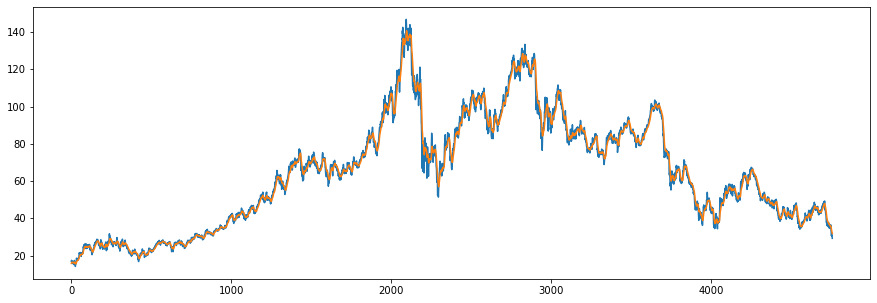

In [371]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 6/initial_indicators/APA_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [372]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4745, 15, 1)

In [373]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [374]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

In [375]:
from collections import Counter

Counter(y)

Counter({2.0: 4337, 0.0: 210, 1.0: 198})

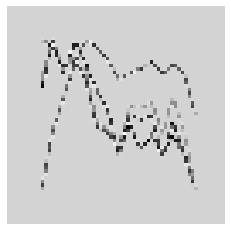

In [376]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [377]:
X = X/255

In [378]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [379]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [380]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [381]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [382]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('APA')]
    y = nr_test_data['{}_y'.format('APA')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('APA'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_non_recession.csv'.format(experiment,'APA')):
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'APA'))
    else:
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'APA'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('APA')]
    y = r_test_data['{}_y'.format('APA')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('APA'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_recession.csv'.format(experiment,'APA')):
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'APA'))
    else:
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'APA'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.531746031746032, 1: 8.0084388185654, 2: 0.36464937560038424}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2517 - accuracy: 0.3733 - mse: 1.6487 - weighted_accuracy: 0.3177 - weighted_mse: 1.7532 - val_loss: 0.2043 - val_accuracy: 0.0421 - val_mse: 1.1587 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 1.1587
Epoch 2/20
30/30 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.2627 - mse: 1.1949 - weighted_accuracy: 0.3268 - weighted_mse: 1.206 - 0s 10ms/step - loss: 0.2069 - accuracy: 0.2679 - mse: 1.1812 - weighted_accuracy: 0.3398 - weighted_mse: 1.1969 - val_loss: 0.2066 - val_accuracy: 0.0485 - val_mse: 0.9010 - val_weighted_accuracy: 0.0485 - val_weighted_mse: 0.9010
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2042 - accuracy: 0.2840 - mse: 1.1585 - weighted_accuracy: 0.3495 - weighted_mse: 1.1683 - val_loss: 0.2046 - val_accuracy: 0.0485 - val_mse: 0.9799 - val_we

7/7 [==============================] - 0s 5ms/step - loss: 0.2146 - accuracy: 0.0502 - mse: 0.9595 - weighted_accuracy: 0.0502 - weighted_mse: 0.9595
Test loss: 0.21464970707893372
Test accuracy: 0.0502283088862896


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 79
actual holds but predicted sell: 125
actual predicted holds: 0
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 4.477611940298507%
Percentage holds correct: 0%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 55.294117647058826%
Percentage high sells correct: 47.36842105263158%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.8845928366904762
Shares owned at the moment: 112
Cash capital at the moment: $0.653147696966002


Price increase from previously bought: -

Epoch 6/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1987 - accuracy: 0.2740 - mse: 1.1291 - weighted_accuracy: 0.3942 - weighted_mse: 1.1480 - val_loss: 0.1940 - val_accuracy: 0.0548 - val_mse: 1.0631 - val_weighted_accuracy: 0.0548 - val_weighted_mse: 1.0631
Epoch 7/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1968 - accuracy: 0.2742 - mse: 1.1674 - weighted_accuracy: 0.4202 - weighted_mse: 1.1816 - val_loss: 0.1982 - val_accuracy: 0.0706 - val_mse: 0.9942 - val_weighted_accuracy: 0.0706 - val_weighted_mse: 0.9942
Epoch 8/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1978 - accuracy: 0.2368 - mse: 1.1782 - weighted_accuracy: 0.3753 - weighted_mse: 1.1750 - val_loss: 0.2008 - val_accuracy: 0.0695 - val_mse: 0.9131 - val_weighted_accuracy: 0.0695 - val_weighted_mse: 0.9131
Epoch 9/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1935 - accuracy: 0.2521 - mse: 1.1724 - weighted_accuracy: 0.4115 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.2030 - accuracy: 0.0502 - mse: 1.1386 - weighted_accuracy: 0.0502 - weighted_mse: 1.1386    
Test loss: 0.20302733778953552
Test accuracy: 0.0502283088862896


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 3
actual sells but predicted hold: 0
actual holds but predicted buy: 159
actual holds but predicted sell: 45
actual predicted holds: 0
Percentage buys correct: 4.678362573099415%
Percentage sells correct: 6.25%
Percentage holds correct: 0%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9933061950990499
Shares owned at the moment: 100
Cash capital at the moment: $0.396221286442767


Price increase from previously bought: 0.66595969

30/30 [==============================] - 0s 13ms/step - loss: 0.1778 - accuracy: 0.1886 - mse: 1.3151 - weighted_accuracy: 0.5147 - weighted_mse: 1.2750 - val_loss: 0.2045 - val_accuracy: 0.1106 - val_mse: 1.0381 - val_weighted_accuracy: 0.1106 - val_weighted_mse: 1.0381
Epoch 7/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1785 - accuracy: 0.1862 - mse: 1.3048 - weighted_accuracy: 0.5286 - weighted_mse: 1.2749 - val_loss: 0.1979 - val_accuracy: 0.1243 - val_mse: 1.0854 - val_weighted_accuracy: 0.1243 - val_weighted_mse: 1.0854
Epoch 8/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1739 - accuracy: 0.1781 - mse: 1.3381 - weighted_accuracy: 0.5313 - weighted_mse: 1.3099 - val_loss: 0.2012 - val_accuracy: 0.1275 - val_mse: 1.1210 - val_weighted_accuracy: 0.1275 - val_weighted_mse: 1.1210
Epoch 9/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1752 - accuracy: 0.1865 - mse: 1.3423 - weighted_accuracy: 0.5390 - weighted_mse: 1.309

7/7 [==============================] - 0s 5ms/step - loss: 0.1993 - accuracy: 0.1507 - mse: 1.2832 - weighted_accuracy: 0.1507 - weighted_mse: 1.2832
Test loss: 0.1993390917778015
Test accuracy: 0.15068493783473969


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 1
actual holds but predicted buy: 94
actual holds but predicted sell: 88
actual predicted holds: 22
Percentage buys correct: 6.796116504854369%
Percentage sells correct: 4.3478260869565215%
Percentage holds correct: 91.66666666666667%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 54.90196078431372%
Percentage high sells correct: 55.43478260869565%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.9933061950990499
Shares owned at the moment: 100
Cash capital at the moment: $0.396221286442767


Price increase from p

Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1625 - accuracy: 0.2073 - mse: 1.4490 - weighted_accuracy: 0.5784 - weighted_mse: 1.4301 - val_loss: 0.1979 - val_accuracy: 0.1981 - val_mse: 1.1495 - val_weighted_accuracy: 0.1981 - val_weighted_mse: 1.1495
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1586 - accuracy: 0.2136 - mse: 1.4061 - weighted_accuracy: 0.6158 - weighted_mse: 1.3937 - val_loss: 0.1963 - val_accuracy: 0.2234 - val_mse: 1.2515 - val_weighted_accuracy: 0.2234 - val_weighted_mse: 1.2515
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1556 - accuracy: 0.2165 - mse: 1.4357 - weighted_accuracy: 0.6188 - weighted_mse: 1.4212 - val_loss: 0.2008 - val_accuracy: 0.2023 - val_mse: 1.3318 - val_weighted_accuracy: 0.2023 - val_weighted_mse: 1.3318
Epoch 5/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1609 - accuracy: 0.2023 - mse: 1.4400 - weighted_accuracy: 0.5970 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1938 - accuracy: 0.2466 - mse: 1.4147 - weighted_accuracy: 0.2466 - weighted_mse: 1.4147
Test loss: 0.1937715709209442
Test accuracy: 0.24657534062862396


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 81
actual holds but predicted sell: 80
actual predicted holds: 43
Percentage buys correct: 7.865168539325842%
Percentage sells correct: 4.761904761904762%
Percentage holds correct: 93.47826086956522%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 55.68181818181818%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 82.6086956521739%


Capital: 100
Share price: $0.9933061950990499
Shares owned at the moment: 100
Cash capital at the moment: $0.396221286442767


Price inc

30/30 [==============================] - 0s 16ms/step - loss: 0.1467 - accuracy: 0.2700 - mse: 1.5782 - weighted_accuracy: 0.6521 - weighted_mse: 1.5991 - val_loss: 0.1965 - val_accuracy: 0.2529 - val_mse: 1.4843 - val_weighted_accuracy: 0.2529 - val_weighted_mse: 1.4843
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1452 - accuracy: 0.2895 - mse: 1.6233 - weighted_accuracy: 0.6711 - weighted_mse: 1.6507 - val_loss: 0.1914 - val_accuracy: 0.2782 - val_mse: 1.3753 - val_weighted_accuracy: 0.2782 - val_weighted_mse: 1.3753
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1469 - accuracy: 0.2806 - mse: 1.5936 - weighted_accuracy: 0.6463 - weighted_mse: 1.6184 - val_loss: 0.1911 - val_accuracy: 0.2993 - val_mse: 1.3495 - val_weighted_accuracy: 0.2993 - val_weighted_mse: 1.3495
Epoch 4/20
30/30 [==============================] - 1s 26ms/step - loss: 0.1426 - accuracy: 0.3003 - mse: 1.6270 - weighted_accuracy: 0.6865 - weighted_mse: 1.674

7/7 [==============================] - 0s 3ms/step - loss: 0.1813 - accuracy: 0.4110 - mse: 1.5234 - weighted_accuracy: 0.4110 - weighted_mse: 1.5234
Test loss: 0.18125349283218384
Test accuracy: 0.4109589159488678


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 1
actual holds but predicted buy: 63
actual holds but predicted sell: 62
actual predicted holds: 79
Percentage buys correct: 9.722222222222221%
Percentage sells correct: 6.0606060606060606%
Percentage holds correct: 97.53086419753086%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 59.15492957746479%
Percentage high sells correct: 60.60606060606061%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.9933061950990499
Shares owned at the moment: 100
Cash capital at the moment: $0.396221286442767


Price in

30/30 [==============================] - 0s 10ms/step - loss: 0.1314 - accuracy: 0.4102 - mse: 1.8535 - weighted_accuracy: 0.7346 - weighted_mse: 2.0427 - val_loss: 0.1794 - val_accuracy: 0.4152 - val_mse: 1.4954 - val_weighted_accuracy: 0.4152 - val_weighted_mse: 1.4954
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1312 - accuracy: 0.3936 - mse: 1.7786 - weighted_accuracy: 0.7231 - weighted_mse: 1.9432 - val_loss: 0.1776 - val_accuracy: 0.4204 - val_mse: 1.5705 - val_weighted_accuracy: 0.4204 - val_weighted_mse: 1.5705
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1302 - accuracy: 0.4017 - mse: 1.8090 - weighted_accuracy: 0.7292 - weighted_mse: 2.0238 - val_loss: 0.1759 - val_accuracy: 0.4394 - val_mse: 1.6508 - val_weighted_accuracy: 0.4394 - val_weighted_mse: 1.6508
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1315 - accuracy: 0.4086 - mse: 1.8195 - weighted_accuracy: 0.7261 - weighted_mse: 1.9625

7/7 [==============================] - 0s 2ms/step - loss: 0.1627 - accuracy: 0.5982 - mse: 1.7154 - weighted_accuracy: 0.5982 - weighted_mse: 1.7154
Test loss: 0.16269055008888245
Test accuracy: 0.5981734991073608


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 3
actual holds but predicted buy: 46
actual holds but predicted sell: 35
actual predicted holds: 123
Percentage buys correct: 9.615384615384615%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 95.34883720930233%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 61.53846153846154%
Percentage high sells correct: 65.78947368421052%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.9603257607411696
Shares owned at the moment: 103
Cash capital at the moment: $0.8144343719295932


Price increase from 

Epoch 8/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1131 - accuracy: 0.5590 - mse: 2.2301 - weighted_accuracy: 0.7931 - weighted_mse: 2.8203 - val_loss: 0.1545 - val_accuracy: 0.6017 - val_mse: 1.8036 - val_weighted_accuracy: 0.6017 - val_weighted_mse: 1.8036
Epoch 9/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1127 - accuracy: 0.5622 - mse: 2.1444 - weighted_accuracy: 0.7911 - weighted_mse: 2.6704 - val_loss: 0.1543 - val_accuracy: 0.5964 - val_mse: 1.8701 - val_weighted_accuracy: 0.5964 - val_weighted_mse: 1.8701
Epoch 10/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1138 - accuracy: 0.5748 - mse: 2.1487 - weighted_accuracy: 0.7869 - weighted_mse: 2.6845 - val_loss: 0.1516 - val_accuracy: 0.6238 - val_mse: 1.9523 - val_weighted_accuracy: 0.6238 - val_weighted_mse: 1.9523
Epoch 11/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1164 - accuracy: 0.5751 - mse: 2.1694 - weighted_accuracy: 0.7791 - weight

7/7 [==============================] - 0s 2ms/step - loss: 0.1520 - accuracy: 0.6575 - mse: 2.0146 - weighted_accuracy: 0.6575 - weighted_mse: 2.0146
Test loss: 0.15195396542549133
Test accuracy: 0.6575342416763306


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 42
actual holds but predicted sell: 21
actual predicted holds: 141
Percentage buys correct: 6.521739130434782%
Percentage sells correct: 0.0%
Percentage holds correct: 92.76315789473684%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 60.869565217391305%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 83.44370860927152%


Capital: 100
Share price: $0.9603257607411696
Shares owned at the moment: 103
Cash capital at the moment: $0.8144343719295932


Price increase from 

Epoch 15/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1002 - accuracy: 0.6628 - mse: 2.7727 - weighted_accuracy: 0.8212 - weighted_mse: 3.8831 - val_loss: 0.1303 - val_accuracy: 0.7345 - val_mse: 2.1255 - val_weighted_accuracy: 0.7345 - val_weighted_mse: 2.1255
Epoch 16/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0977 - accuracy: 0.6781 - mse: 2.6810 - weighted_accuracy: 0.8260 - weighted_mse: 3.8315 - val_loss: 0.1266 - val_accuracy: 0.7534 - val_mse: 2.2065 - val_weighted_accuracy: 0.7534 - val_weighted_mse: 2.2065
Epoch 17/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0987 - accuracy: 0.6762 - mse: 2.8262 - weighted_accuracy: 0.8165 - weighted_mse: 3.9506 - val_loss: 0.1318 - val_accuracy: 0.7197 - val_mse: 2.1825 - val_weighted_accuracy: 0.7197 - val_weighted_mse: 2.1825
Epoch 18/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0942 - accuracy: 0.7023 - mse: 2.8971 - weighted_accuracy: 0.8470 - weig

30/30 [==============================] - 0s 15ms/step - loss: 0.0936 - accuracy: 0.6823 - mse: 3.0408 - weighted_accuracy: 0.8434 - weighted_mse: 4.3933 - val_loss: 0.1255 - val_accuracy: 0.7450 - val_mse: 2.2953 - val_weighted_accuracy: 0.7450 - val_weighted_mse: 2.2953
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0919 - accuracy: 0.7168 - mse: 2.9709 - weighted_accuracy: 0.8439 - weighted_mse: 4.1315 - val_loss: 0.1189 - val_accuracy: 0.7850 - val_mse: 2.4359 - val_weighted_accuracy: 0.7850 - val_weighted_mse: 2.4359
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0950 - accuracy: 0.6963 - mse: 3.0183 - weighted_accuracy: 0.8425 - weighted_mse: 4.2204 - val_loss: 0.1185 - val_accuracy: 0.7819 - val_mse: 2.4343 - val_weighted_accuracy: 0.7819 - val_weighted_mse: 2.4343
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0941 - accuracy: 0.6899 - mse: 2.9847 - weighted_accuracy: 0.8342 - weighted_mse: 4.217

7/7 [==============================] - 0s 4ms/step - loss: 0.1101 - accuracy: 0.8037 - mse: 2.9044 - weighted_accuracy: 0.8037 - weighted_mse: 2.9044
Test loss: 0.11008512228727341
Test accuracy: 0.8036529421806335


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 14
actual holds but predicted sell: 15
actual predicted holds: 175
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 0.0%
Percentage holds correct: 92.5925925925926%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 46.666666666666664%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 82.97872340425532%


Capital: 100
Share price: $0.8670846809014857
Shares owned at the moment: 115
Cash capital at the moment: $0.01104616599404551


Price increase from 

Epoch 19/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0757 - accuracy: 0.7705 - mse: 4.5325 - weighted_accuracy: 0.8640 - weighted_mse: 7.3417 - val_loss: 0.1021 - val_accuracy: 0.8388 - val_mse: 3.2788 - val_weighted_accuracy: 0.8388 - val_weighted_mse: 3.2788
Epoch 20/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0783 - accuracy: 0.7640 - mse: 4.3958 - weighted_accuracy: 0.8596 - weighted_mse: 7.0494 - val_loss: 0.0998 - val_accuracy: 0.8525 - val_mse: 3.3450 - val_weighted_accuracy: 0.8525 - val_weighted_mse: 3.3450
Validation loss: 0.09982287138700485
Validation accuracy: 0.8524762988090515


Non-Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1105 - accuracy: 0.8211 - mse: 3.5113 - weighted_accuracy: 0.8211 - weighted_mse: 3.5113
Test loss: 0.11046282202005386
Test accuracy: 0.8211008906364441


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold:

In [383]:
df = nr_log_hist['epochs_logs']
df.head(20)

Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.068807      8.333333       5.737705       0.000000   
1       0.059633      5.084746       5.128205     100.000000   
2       0.201835      7.843137       7.142857      93.750000   
3       0.261468      7.058824       7.142857      91.836735   
4       0.344037      5.405405       7.042254      90.410959   
5       0.477064      5.000000       4.255319      89.189189   
6       0.587156      3.846154       0.000000      89.361702   
7       0.678899      3.030303       0.000000      90.184049   
8       0.779817      4.545455       0.000000      91.351351   
9       0.821101      5.882353       0.000000      91.752577   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         46.875000           42.975207           0.000000     478.375827   
1         42.045455           56.410256         100.000000     -85.630910   
2         47.058824           50.000000          83.870968     -45.243204   
3         49.411765           51.190476          77.083333     -27.749372   
4         48.648649           50.704225          77.777778     -49.322969   
5         48.333333           48.936170          79.090909     -28.506958   
6         48.076923           44.000000          80.000000     -78.925033   
7         42.424242           45.454545          79.629630     -75.699557   
8         50.000000           27.272727          80.434783      10.536611   
9         41.176471           28.571429          81.347150      15.415355   

   buy_n_hold profit  
0         -62.606003  
1         -62.606003  
2         -62.606003  
3         -62.606003  
4         -62.606003  
5         -62.606003  
6         -62.606003  
7         -62.606003  
8         -62.606003  
9         -62.606003

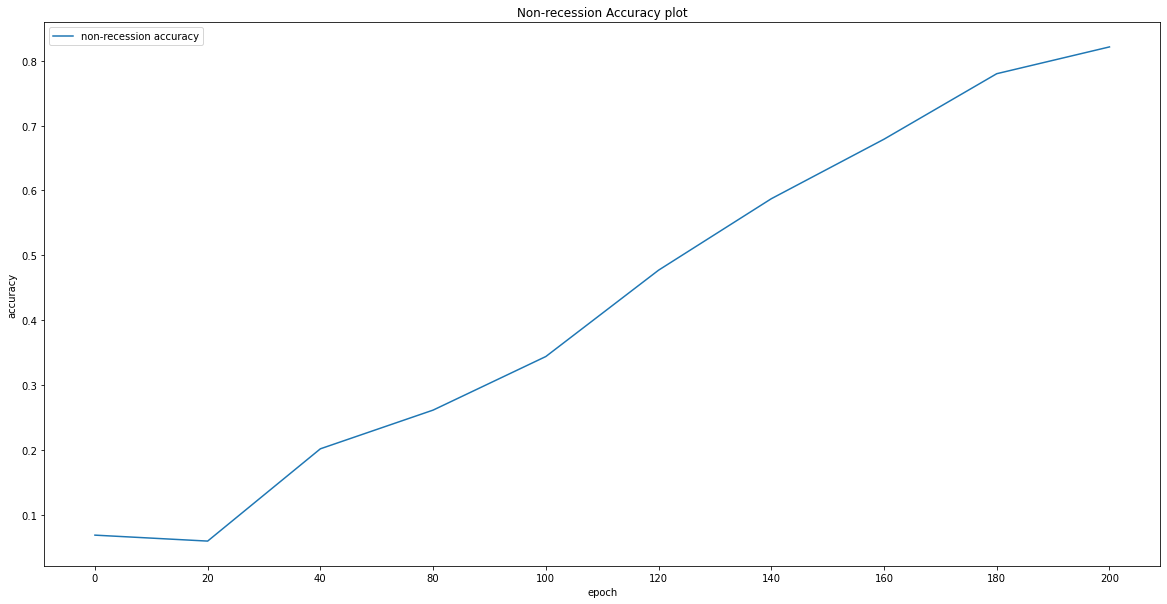

In [384]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

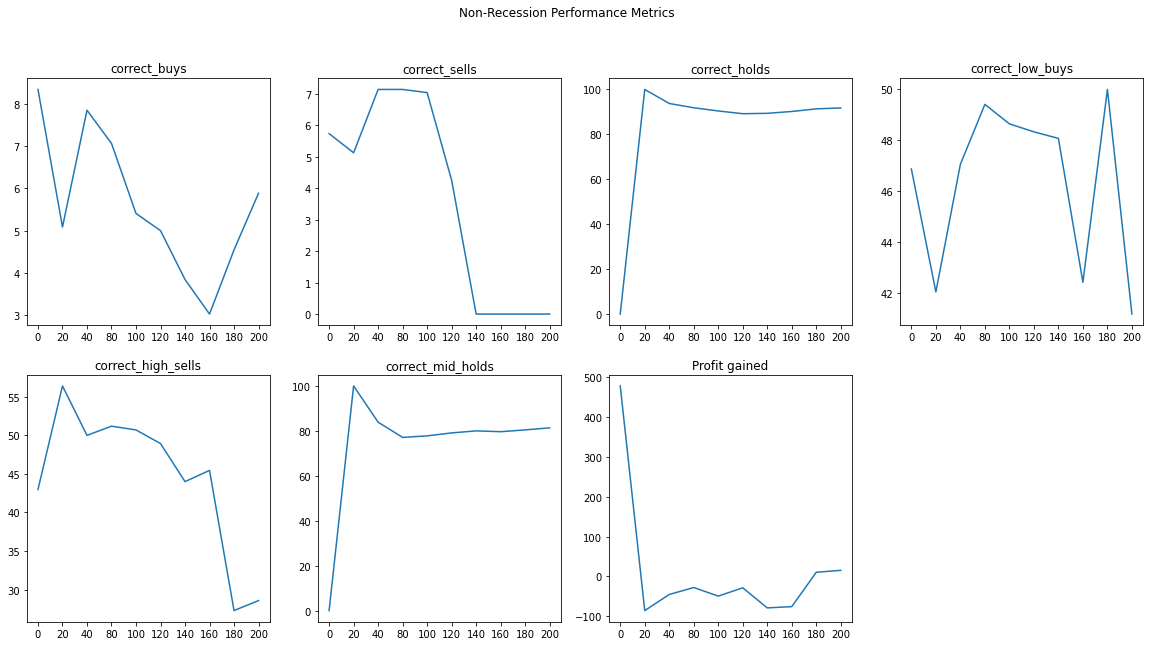

In [385]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

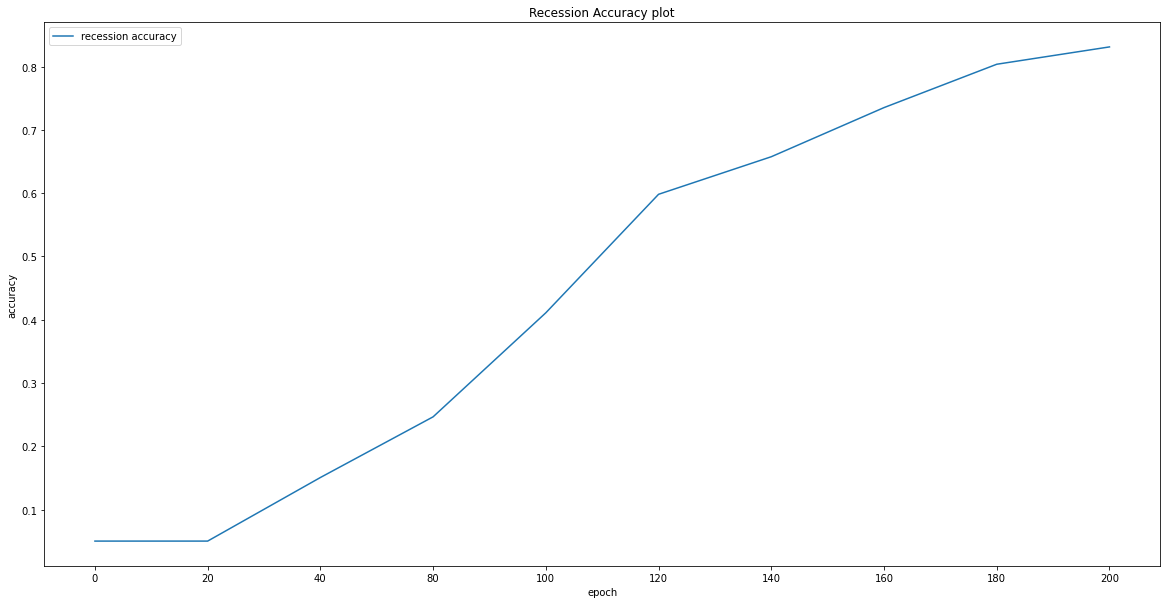

In [386]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

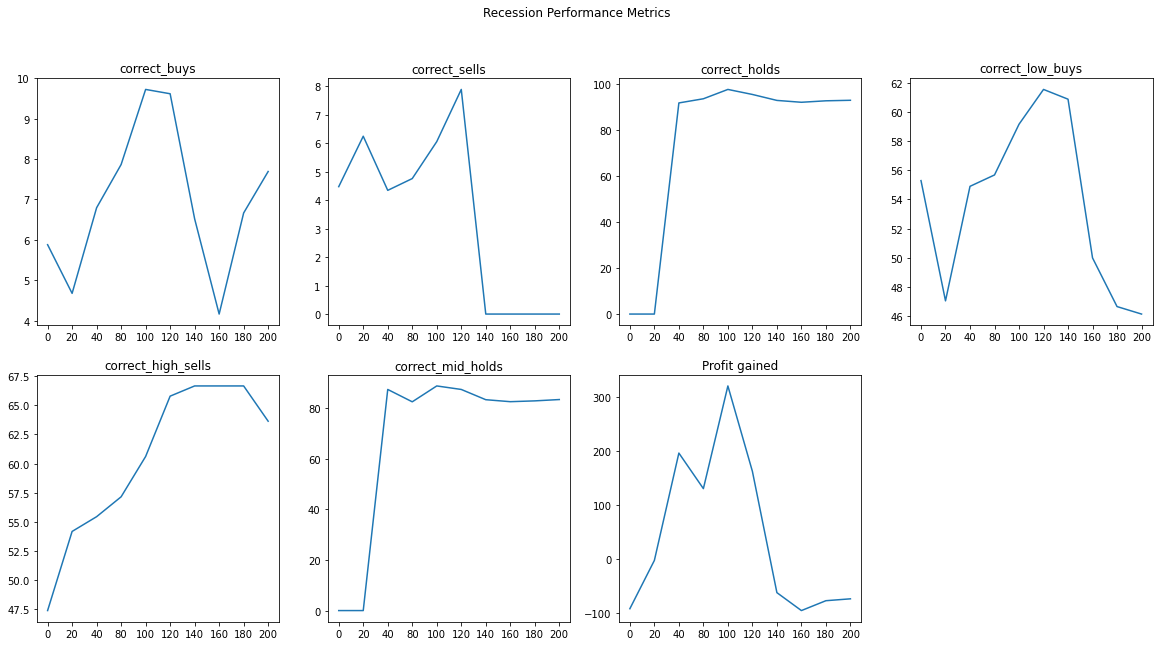

In [387]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### With Supporting Stock Price

In [388]:
nr_test_sets = ['APA']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/XOM_data_test.csv")
    df2.set_index('Date', inplace=True)
    print(df2.head())
    
    df['support'] = df2['previous_1d']
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    support_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    data_15_support = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            support_data.append(data_15_support_arr)
            labels.append(i[4])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]
            data_15_support = data_15_support[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    support_data = np.array(support_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        n = support_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)
        ax.plot(n)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    32.090000  30.219349  -6.069339  51546400.0     2.0
2019-01-23    31.520000  30.419449 -14.306331  47385100.0     1.0
2019-01-24    30.969999  30.504149 -26.101688  43194000.0     2.0
2019-01-25    31.840000  30.709665 -13.293617  47637700.0     2.0
2019-01-28    32.060001  30.917409  -9.803859  52112900.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    72.989998  71.473540  -4.975176  60118400.0     2.0
2019-01-23    71.889999  71.537611 -23.217277  45082800.0     2.0
2019-01-24    71.300003  71.501056 -40.365066  31895600.0     2.0
2019-01-25    71.400002  71.485509 -48.091584  43168100.0     2.0
2019-01-28    71.720001  71.521585 -59.245237  52164300.0     1.0


In [389]:
r_test_sets = ['APA']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/XOM_data_test2.csv")
    df2.set_index('Date', inplace=True)
    df['support'] = df2['previous_1d']
    
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    support_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    data_15_support = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            support_data.append(data_15_support_arr)
            labels.append(i[4])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]
            data_15_support = data_15_support[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    support_data = np.array(support_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    31.740000  30.898076 -22.580653  22551800.0     2.0
2020-01-23    30.870001  30.893757 -33.564805  17841100.0     2.0
2020-01-24    30.270000  30.797795 -40.697673  13024900.0     2.0
2020-01-27    29.980000  30.671980 -44.069776   9552800.0     2.0
2020-01-28    28.850000  30.391675 -95.533989   5310000.0     2.0


### training Data

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    16.829004  15.783375 -11.666669   832986.0     0.0
2000-01-24    17.424242  16.035816 -16.883143  3962574.0     2.0
2000-01-25    16.964287  16.178658 -27.922065  1711248.0     2.0
2000-01-26    17.153681  16.328661 -24.324314  3808959.0     2.0
2000-01-27    16.964287  16.426450 -34.399988  2355969.0     2.0


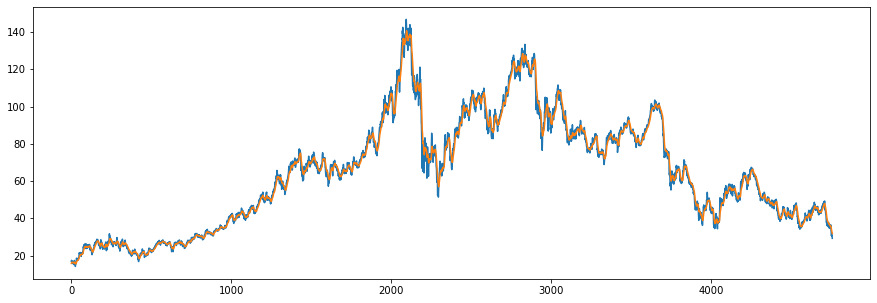

(4745, 64, 64, 1)

In [390]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 6/initial_indicators/APA_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

df2 = pd.read_csv("variation 6/initial_indicators/XOM_data.csv")
df2.set_index('Date', inplace=True)
df['support'] = df2['previous_1d']

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    n = support_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)
    ax.plot(n)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

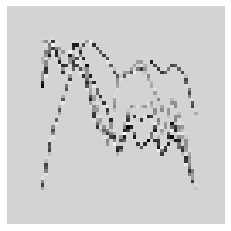

In [391]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [392]:
X = X/255

In [393]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [394]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [395]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [403]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [404]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('APA')]
    y = nr_test_data['{}_y'.format('APA')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('APA'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_non_recession.csv'.format(experiment,'APA')):
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'APA'))
    else:
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'APA'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('APA')]
    y = r_test_data['{}_y'.format('APA')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('APA'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_recession.csv'.format(experiment,'APA')):
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'APA'))
    else:
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'APA'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.531746031746032, 1: 8.0084388185654, 2: 0.36464937560038424}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2510 - accuracy: 0.3701 - mse: 1.6153 - weighted_accuracy: 0.2958 - weighted_mse: 1.7159 - val_loss: 0.2056 - val_accuracy: 0.0432 - val_mse: 1.1462 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 1.1462
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2058 - accuracy: 0.3493 - mse: 1.1908 - weighted_accuracy: 0.3491 - weighted_mse: 1.2211 - val_loss: 0.2017 - val_accuracy: 0.1454 - val_mse: 0.8624 - val_weighted_accuracy: 0.1454 - val_weighted_mse: 0.8624
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2025 - accuracy: 0.3696 - mse: 1.1659 - weighted_accuracy: 0.3546 - weighted_mse: 1.1901 - val_loss: 0.1968 - val_accuracy: 0.5153 - val_mse: 0.8700 - val_weighted_accuracy: 0.5153 - val_weighted_mse: 0.8700
Epoch 4/20
30/30 [==============================] - 0s 1

7/7 [==============================] - 0s 3ms/step - loss: 0.1933 - accuracy: 0.3744 - mse: 0.9260 - weighted_accuracy: 0.3744 - weighted_mse: 0.9260
Test loss: 0.19325324892997742
Test accuracy: 0.37442922592163086


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 1
actual sells but predicted hold: 3
actual holds but predicted buy: 110
actual holds but predicted sell: 20
actual predicted holds: 74
Percentage buys correct: 5.833333333333333%
Percentage sells correct: 4.761904761904762%
Percentage holds correct: 94.87179487179488%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 46.666666666666664%
Percentage high sells correct: 42.857142857142854%
Percentage mid holds correct: 88.31168831168831%


Capital: 100
Share price: $0.9933061950990499
Shares owned at the moment: 100
Cash capital at the moment: $0.396221286442767


Price

Epoch 14/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1945 - accuracy: 0.3617 - mse: 1.1880 - weighted_accuracy: 0.3986 - weighted_mse: 1.1814 - val_loss: 0.1935 - val_accuracy: 0.0801 - val_mse: 1.0219 - val_weighted_accuracy: 0.0801 - val_weighted_mse: 1.0219
Epoch 15/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1944 - accuracy: 0.3303 - mse: 1.2083 - weighted_accuracy: 0.3981 - weighted_mse: 1.1820 - val_loss: 0.1882 - val_accuracy: 0.4362 - val_mse: 0.9929 - val_weighted_accuracy: 0.4362 - val_weighted_mse: 0.9929
Epoch 16/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1941 - accuracy: 0.3211 - mse: 1.1926 - weighted_accuracy: 0.3955 - weighted_mse: 1.1967 - val_loss: 0.1957 - val_accuracy: 0.1749 - val_mse: 0.9318 - val_weighted_accuracy: 0.1749 - val_weighted_mse: 0.9318
Epoch 17/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1939 - accuracy: 0.3043 - mse: 1.1917 - weighted_accuracy: 0.4147 - weig

7/7 [==============================] - 0s 6ms/step - loss: 0.1953 - accuracy: 0.1553 - mse: 1.0098 - weighted_accuracy: 0.1553 - weighted_mse: 1.0098
Test loss: 0.19527551531791687
Test accuracy: 0.155251145362854


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 4
actual predicted sells: 3
actual sells but predicted hold: 0
actual holds but predicted buy: 117
actual holds but predicted sell: 63
actual predicted holds: 24
Percentage buys correct: 5.46875%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 96.0%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 48.031496062992126%
Percentage high sells correct: 51.515151515151516%
Percentage mid holds correct: 96.0%


Capital: 100
Share price: $0.9933061950990499
Shares owned at the moment: 100
Cash capital at the moment: $0.396221286442767


Price increase from previously bought: 0.66

30/30 [==============================] - 0s 13ms/step - loss: 0.1871 - accuracy: 0.2785 - mse: 1.2195 - weighted_accuracy: 0.4706 - weighted_mse: 1.2065 - val_loss: 0.1860 - val_accuracy: 0.3488 - val_mse: 1.0203 - val_weighted_accuracy: 0.3488 - val_weighted_mse: 1.0203
Epoch 8/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1853 - accuracy: 0.3030 - mse: 1.2211 - weighted_accuracy: 0.4664 - weighted_mse: 1.2154 - val_loss: 0.1895 - val_accuracy: 0.2561 - val_mse: 0.9962 - val_weighted_accuracy: 0.2561 - val_weighted_mse: 0.9962
Epoch 9/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1860 - accuracy: 0.2532 - mse: 1.2208 - weighted_accuracy: 0.4475 - weighted_mse: 1.1967 - val_loss: 0.1939 - val_accuracy: 0.1581 - val_mse: 0.9875 - val_weighted_accuracy: 0.1581 - val_weighted_mse: 0.9875
Epoch 10/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1868 - accuracy: 0.2624 - mse: 1.2258 - weighted_accuracy: 0.4817 - weighted_mse: 1.21

7/7 [==============================] - 0s 5ms/step - loss: 0.1894 - accuracy: 0.2877 - mse: 1.0622 - weighted_accuracy: 0.2877 - weighted_mse: 1.0622
Test loss: 0.18944723904132843
Test accuracy: 0.2876712381839752


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 78
actual holds but predicted sell: 74
actual predicted holds: 52
Percentage buys correct: 8.13953488372093%
Percentage sells correct: 5.128205128205129%
Percentage holds correct: 94.54545454545455%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 57.64705882352941%
Percentage high sells correct: 57.69230769230769%
Percentage mid holds correct: 87.27272727272727%


Capital: 100
Share price: $0.9933061950990499
Shares owned at the moment: 100
Cash capital at the moment: $0.396221286442767


Price incr

Epoch 8/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1737 - accuracy: 0.2389 - mse: 1.2998 - weighted_accuracy: 0.5227 - weighted_mse: 1.2511 - val_loss: 0.1872 - val_accuracy: 0.2603 - val_mse: 1.0522 - val_weighted_accuracy: 0.2603 - val_weighted_mse: 1.0522
Epoch 9/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1734 - accuracy: 0.2468 - mse: 1.2343 - weighted_accuracy: 0.5184 - weighted_mse: 1.2242 - val_loss: 0.1861 - val_accuracy: 0.2877 - val_mse: 1.0745 - val_weighted_accuracy: 0.2877 - val_weighted_mse: 1.0745
Epoch 10/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1736 - accuracy: 0.2597 - mse: 1.2938 - weighted_accuracy: 0.5122 - weighted_mse: 1.2581 - val_loss: 0.1886 - val_accuracy: 0.2529 - val_mse: 1.0436 - val_weighted_accuracy: 0.2529 - val_weighted_mse: 1.0436
Epoch 11/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1706 - accuracy: 0.2400 - mse: 1.2781 - weighted_accuracy: 0.5344 - weight

7/7 [==============================] - 0s 7ms/step - loss: 0.1880 - accuracy: 0.2466 - mse: 1.1598 - weighted_accuracy: 0.2466 - weighted_mse: 1.1598
Test loss: 0.18797333538532257
Test accuracy: 0.24657534062862396


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 66
actual holds but predicted sell: 95
actual predicted holds: 43
Percentage buys correct: 9.45945945945946%
Percentage sells correct: 4.040404040404041%
Percentage holds correct: 93.47826086956522%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 61.64383561643836%
Percentage high sells correct: 53.535353535353536%
Percentage mid holds correct: 84.78260869565217%


Capital: 100
Share price: $0.990863220095704
Shares owned at the moment: 100
Cash capital at the moment: $0.6411906049032723


Price in

30/30 [==============================] - 0s 14ms/step - loss: 0.1605 - accuracy: 0.2542 - mse: 1.3599 - weighted_accuracy: 0.5872 - weighted_mse: 1.3137 - val_loss: 0.1980 - val_accuracy: 0.1538 - val_mse: 1.2378 - val_weighted_accuracy: 0.1538 - val_weighted_mse: 1.2378
Epoch 5/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1571 - accuracy: 0.2674 - mse: 1.4037 - weighted_accuracy: 0.5808 - weighted_mse: 1.3847 - val_loss: 0.1849 - val_accuracy: 0.3035 - val_mse: 1.1604 - val_weighted_accuracy: 0.3035 - val_weighted_mse: 1.1604
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1559 - accuracy: 0.2624 - mse: 1.3868 - weighted_accuracy: 0.6171 - weighted_mse: 1.3420 - val_loss: 0.1792 - val_accuracy: 0.3783 - val_mse: 1.2245 - val_weighted_accuracy: 0.3783 - val_weighted_mse: 1.2245
Epoch 7/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1566 - accuracy: 0.2708 - mse: 1.3813 - weighted_accuracy: 0.5943 - weighted_mse: 1.380

7/7 [==============================] - 0s 6ms/step - loss: 0.1883 - accuracy: 0.3014 - mse: 1.3219 - weighted_accuracy: 0.3014 - weighted_mse: 1.3219
Test loss: 0.18830735981464386
Test accuracy: 0.30136987566947937


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 61
actual holds but predicted sell: 88
actual predicted holds: 55
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 5.376344086021505%
Percentage holds correct: 94.82758620689656%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 58.208955223880594%
Percentage high sells correct: 55.913978494623656%
Percentage mid holds correct: 91.37931034482759%


Capital: 100
Share price: $0.9933061950990499
Shares owned at the moment: 100
Cash capital at the moment: $0.396221286442767


Price 

30/30 [==============================] - 0s 13ms/step - loss: 0.1396 - accuracy: 0.3166 - mse: 1.5536 - weighted_accuracy: 0.6680 - weighted_mse: 1.6037 - val_loss: 0.1810 - val_accuracy: 0.3446 - val_mse: 1.3680 - val_weighted_accuracy: 0.3446 - val_weighted_mse: 1.3680
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1432 - accuracy: 0.3227 - mse: 1.5215 - weighted_accuracy: 0.6567 - weighted_mse: 1.5474 - val_loss: 0.1839 - val_accuracy: 0.3130 - val_mse: 1.3705 - val_weighted_accuracy: 0.3130 - val_weighted_mse: 1.3705
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1391 - accuracy: 0.3438 - mse: 1.5583 - weighted_accuracy: 0.6618 - weighted_mse: 1.5952 - val_loss: 0.1946 - val_accuracy: 0.2561 - val_mse: 1.3962 - val_weighted_accuracy: 0.2561 - val_weighted_mse: 1.3962
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1425 - accuracy: 0.3501 - mse: 1.5711 - weighted_accuracy: 0.6758 - weighted_mse: 1.579

7/7 [==============================] - 0s 7ms/step - loss: 0.1726 - accuracy: 0.4703 - mse: 1.4532 - weighted_accuracy: 0.4703 - weighted_mse: 1.4532
Test loss: 0.17257487773895264
Test accuracy: 0.47031962871551514


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 34
actual holds but predicted sell: 76
actual predicted holds: 94
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 6.172839506172839%
Percentage holds correct: 94.0%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 65.78947368421052%
Percentage high sells correct: 59.25925925925926%
Percentage mid holds correct: 84.84848484848484%


Capital: 100
Share price: $0.990863220095704
Shares owned at the moment: 100
Cash capital at the moment: $0.6411906049032723


Price increase from 

Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1291 - accuracy: 0.4818 - mse: 1.7159 - weighted_accuracy: 0.7213 - weighted_mse: 1.8693 - val_loss: 0.1569 - val_accuracy: 0.5933 - val_mse: 1.4151 - val_weighted_accuracy: 0.5933 - val_weighted_mse: 1.4151
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.4771 - mse: 1.7695 - weighted_accuracy: 0.7239 - weighted_mse: 1.9643 - val_loss: 0.1662 - val_accuracy: 0.5216 - val_mse: 1.4803 - val_weighted_accuracy: 0.5216 - val_weighted_mse: 1.4803
Epoch 8/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1207 - accuracy: 0.4808 - mse: 1.7946 - weighted_accuracy: 0.7384 - weighted_mse: 2.0341 - val_loss: 0.1678 - val_accuracy: 0.5037 - val_mse: 1.4879 - val_weighted_accuracy: 0.5037 - val_weighted_mse: 1.4879
Epoch 9/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1208 - accuracy: 0.4860 - mse: 1.8247 - weighted_accuracy: 0.7441 - weighted



Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1533 - accuracy: 0.6301 - mse: 1.6395 - weighted_accuracy: 0.6301 - weighted_mse: 1.6395
Test loss: 0.15325522422790527
Test accuracy: 0.6301369667053223


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 29
actual holds but predicted sell: 44
actual predicted holds: 131
Percentage buys correct: 9.375%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 94.24460431654676%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 59.375%
Percentage high sells correct: 64.58333333333333%
Percentage mid holds correct: 84.05797101449275%


Capital: 100
Share price: $0.8845928366904762
Shares owned at the moment: 112
Cash capital at the moment: $0.653147696966002


Price increa

30/30 [==============================] - 0s 10ms/step - loss: 0.1130 - accuracy: 0.5782 - mse: 2.0165 - weighted_accuracy: 0.7664 - weighted_mse: 2.3881 - val_loss: 0.1422 - val_accuracy: 0.6797 - val_mse: 1.5624 - val_weighted_accuracy: 0.6797 - val_weighted_mse: 1.5624
Epoch 10/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1106 - accuracy: 0.5830 - mse: 2.0410 - weighted_accuracy: 0.7703 - weighted_mse: 2.4360 - val_loss: 0.1473 - val_accuracy: 0.6438 - val_mse: 1.6370 - val_weighted_accuracy: 0.6438 - val_weighted_mse: 1.6370
Epoch 11/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1122 - accuracy: 0.5722 - mse: 2.0720 - weighted_accuracy: 0.7617 - weighted_mse: 2.4530 - val_loss: 0.1460 - val_accuracy: 0.6617 - val_mse: 1.6434 - val_weighted_accuracy: 0.6617 - val_weighted_mse: 1.6434
Epoch 12/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1052 - accuracy: 0.5854 - mse: 2.1031 - weighted_accuracy: 0.7901 - weighted_mse: 2.

7/7 [==============================] - 0s 3ms/step - loss: 0.1361 - accuracy: 0.7169 - mse: 1.6859 - weighted_accuracy: 0.7169 - weighted_mse: 1.6859
Test loss: 0.13607506453990936
Test accuracy: 0.7168949842453003


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 24
actual holds but predicted sell: 26
actual predicted holds: 154
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 3.7037037037037037%
Percentage holds correct: 92.7710843373494%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 57.69230769230769%
Percentage high sells correct: 74.07407407407408%
Percentage mid holds correct: 83.03030303030303%


Capital: 100
Share price: $0.8845928366904762
Shares owned at the moment: 112
Cash capital at the moment: $0.653147696966002


Price i

30/30 [==============================] - 0s 10ms/step - loss: 0.0954 - accuracy: 0.6488 - mse: 2.4395 - weighted_accuracy: 0.8055 - weighted_mse: 3.1355 - val_loss: 0.1333 - val_accuracy: 0.7218 - val_mse: 1.7862 - val_weighted_accuracy: 0.7218 - val_weighted_mse: 1.7862
Epoch 14/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0997 - accuracy: 0.6483 - mse: 2.4293 - weighted_accuracy: 0.7917 - weighted_mse: 3.1085 - val_loss: 0.1236 - val_accuracy: 0.7629 - val_mse: 1.7797 - val_weighted_accuracy: 0.7629 - val_weighted_mse: 1.7797
Epoch 15/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1008 - accuracy: 0.6396 - mse: 2.4273 - weighted_accuracy: 0.7871 - weighted_mse: 3.0776 - val_loss: 0.1219 - val_accuracy: 0.7671 - val_mse: 1.7702 - val_weighted_accuracy: 0.7671 - val_weighted_mse: 1.7702
Epoch 16/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0958 - accuracy: 0.6481 - mse: 2.4989 - weighted_accuracy: 0.8037 - weighted_mse: 3.

Epoch 1/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0979 - accuracy: 0.6354 - mse: 2.5796 - weighted_accuracy: 0.7852 - weighted_mse: 3.2130 - val_loss: 0.1186 - val_accuracy: 0.7829 - val_mse: 1.8082 - val_weighted_accuracy: 0.7829 - val_weighted_mse: 1.8082
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1003 - accuracy: 0.6567 - mse: 2.5656 - weighted_accuracy: 0.7953 - weighted_mse: 3.1683 - val_loss: 0.1227 - val_accuracy: 0.7471 - val_mse: 1.9006 - val_weighted_accuracy: 0.7471 - val_weighted_mse: 1.9006
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0942 - accuracy: 0.6520 - mse: 2.6610 - weighted_accuracy: 0.8144 - weighted_mse: 3.5121 - val_loss: 0.1235 - val_accuracy: 0.7397 - val_mse: 1.9376 - val_weighted_accuracy: 0.7397 - val_weighted_mse: 1.9376
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0908 - accuracy: 0.6552 - mse: 2.6771 - weighted_accuracy: 0.8099 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1045 - accuracy: 0.8128 - mse: 2.1864 - weighted_accuracy: 0.8128 - weighted_mse: 2.1864
Test loss: 0.10452297329902649
Test accuracy: 0.8127853870391846


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 9
actual holds but predicted sell: 17
actual predicted holds: 178
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 92.2279792746114%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 70.58823529411765%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.8670846809014857
Shares owned at the moment: 115
Cash capital at the moment: $0.01104616599404551


Price increase from previously bough

In [405]:
df = nr_log_hist['epochs_logs']
df.head(20)

Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.376147      7.142857       6.666667      93.506494   
1       0.155963      6.428571       7.142857      95.454545   
2       0.266055      9.278351       7.792208      97.727273   
3       0.270642      8.000000       6.451613      94.000000   
4       0.302752      5.479452       6.097561      90.476190   
5       0.449541      6.382979       6.756757      92.783505   
6       0.559633      6.122449       2.500000      91.472868   
7       0.665138      4.761905       0.000000      91.082803   
8       0.738532      7.142857       0.000000      90.909091   
9       0.798165      9.090909       0.000000      91.534392   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         43.650794           53.333333          84.210526     -55.907378   
1         45.714286           50.000000          85.714286     -71.310271   
2         52.577320           46.753247          88.372093     -71.352207   
3         50.666667           46.739130          80.000000     868.852863   
4         47.945205           47.560976          79.032258     910.859433   
5         46.808511           47.297297          82.291667     600.786247   
6         42.857143           42.500000          80.468750     523.976181   
7         40.476190           57.894737          80.128205     176.001482   
8         57.142857           53.571429          81.142857     996.439577   
9         63.636364           55.555556          80.319149     886.309762   

   buy_n_hold profit  
0         -62.606003  
1         -62.606003  
2         -62.606003  
3         -62.606003  
4         -62.606003  
5         -62.606003  
6         -62.606003  
7         -62.606003  
8         -62.606003  
9         -62.606003

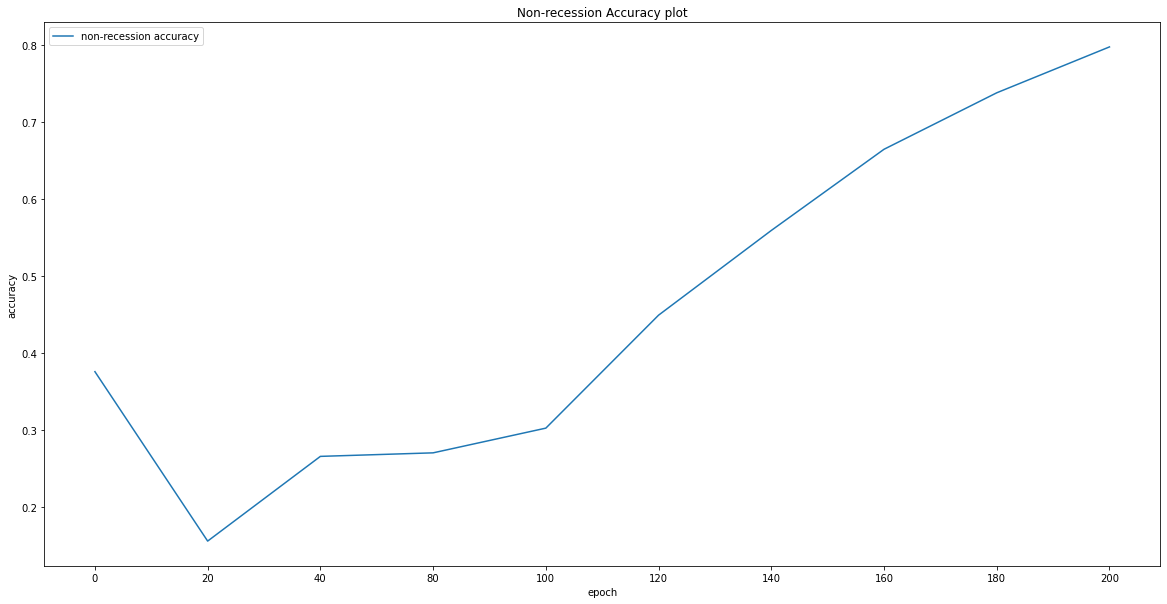

In [406]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

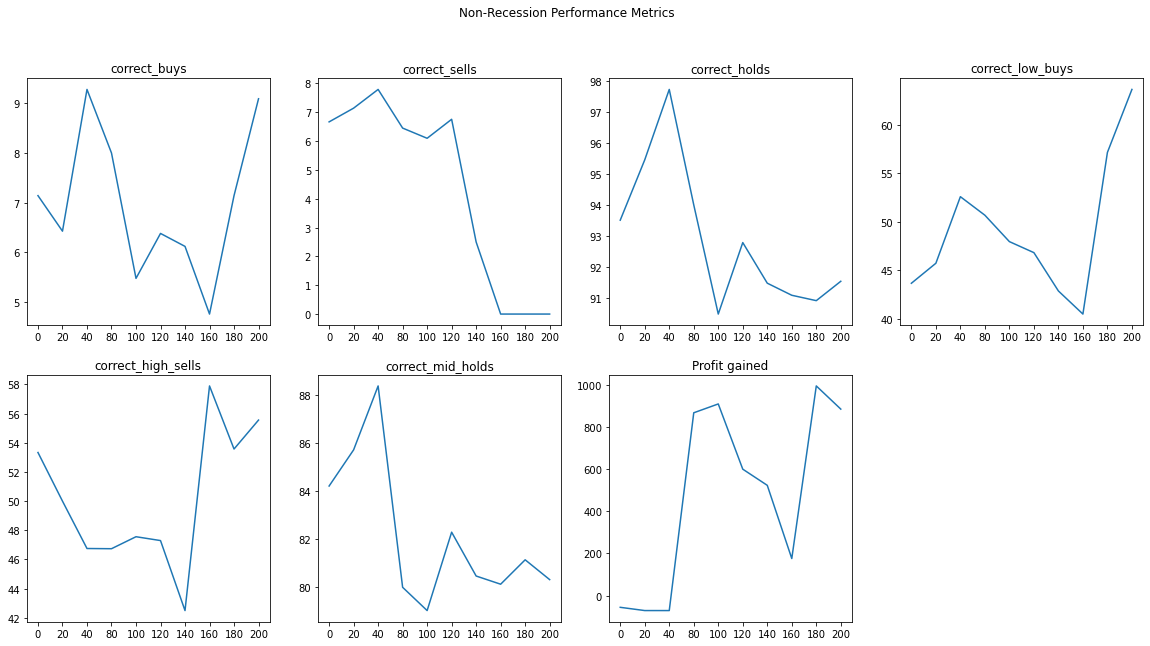

In [407]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

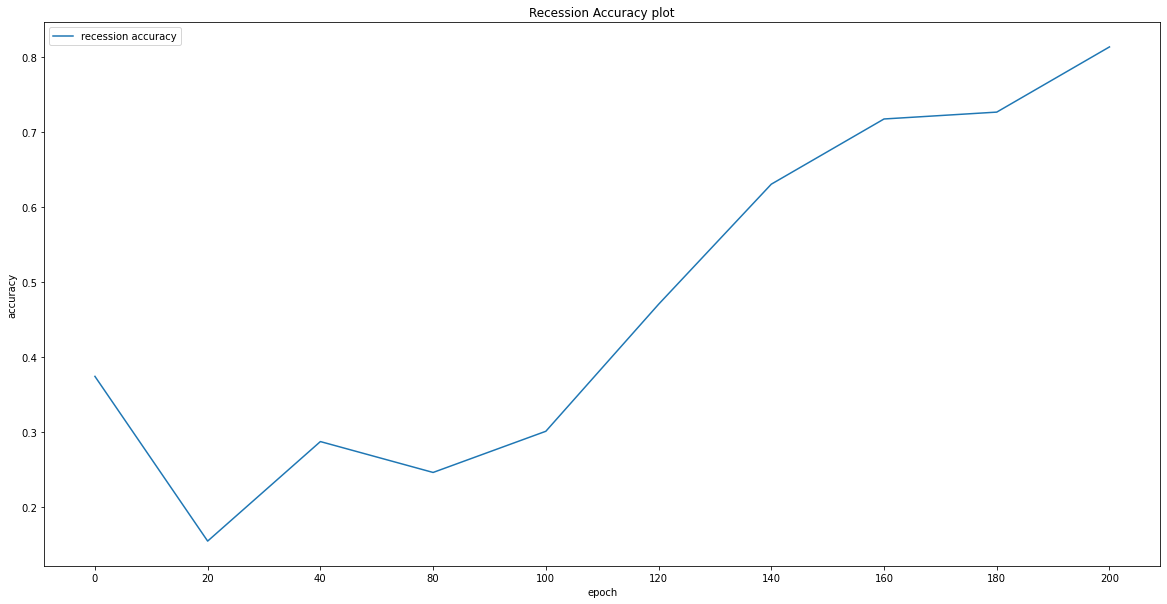

In [408]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

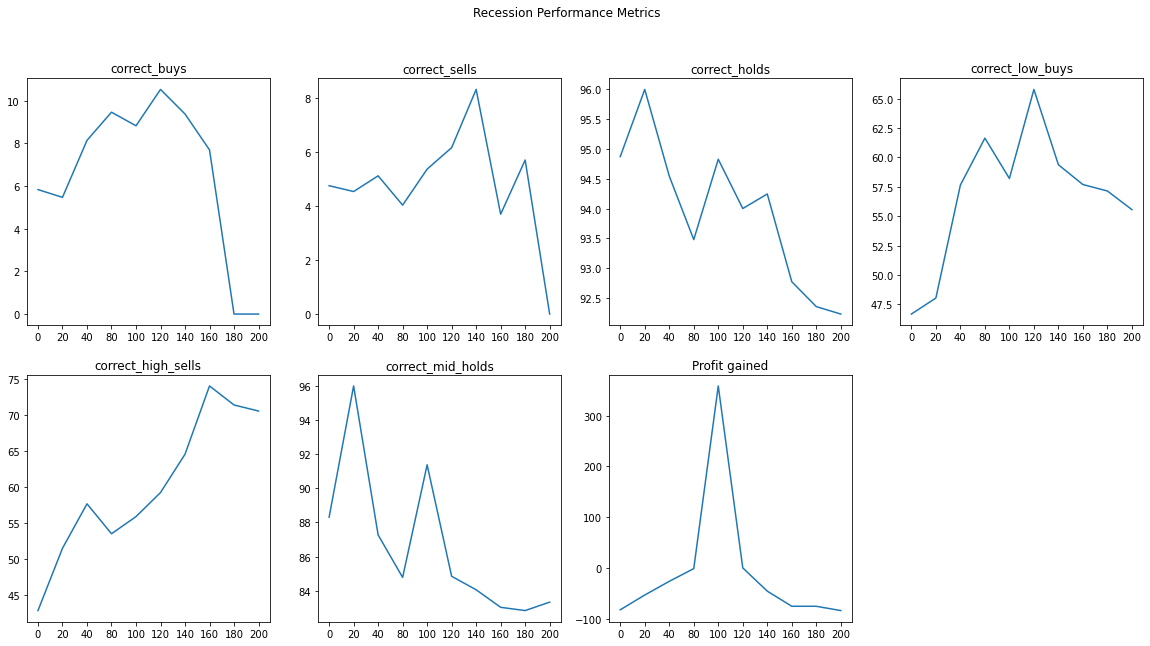

In [409]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

## JetBlue Airways Corporation

### No support Stock Price

In [191]:
nr_test_sets = ['JBLU']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    17.600000  17.005903  -4.149392  23132100.0     2.0
2019-01-23    17.370001  17.061918 -14.049519  19087600.0     2.0
2019-01-24    17.240000  17.089315 -19.421466  14999400.0     2.0
2019-01-25    18.120001  17.247882  -5.555506  23032100.0     2.0
2019-01-28    17.709999  17.318977 -26.363710  14531900.0     2.0


In [192]:
r_test_sets = ['JBLU']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    19.049999  18.785034 -29.629734  -5172900.0     2.0
2020-01-23    19.790001  18.939644 -15.920381   7229600.0     0.0
2020-01-24    21.070000  19.267391  -2.622949  23219300.0     2.0
2020-01-27    20.650000  19.480100 -18.060233  11950900.0     2.0
2020-01-28    20.040001  19.566239 -38.461529   3416600.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2002-05-02    14.761481  13.724947  -5.141986  58104336.0     2.0
2002-05-03    14.562963  13.853872 -13.413429  57315261.0     2.0
2002-05-06    15.419259  14.094701  -0.086583  58757399.0     0.0
2002-05-07    16.148148  14.410616  -4.436861  61163774.0     2.0
2002-05-08    14.696296  14.454567 -37.883964  57784724.0     2.0


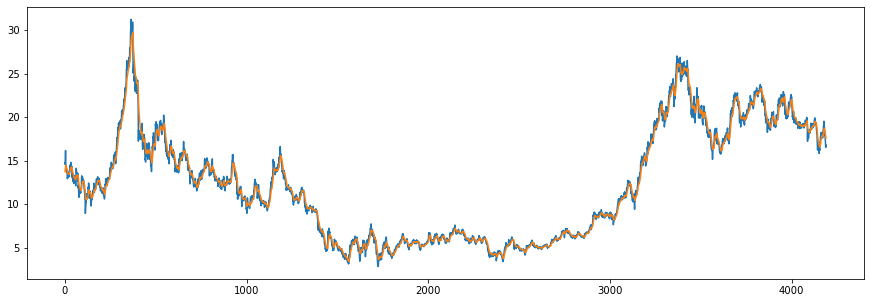

(4175, 64, 64, 1)

In [193]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 6/initial_indicators/JBLU_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

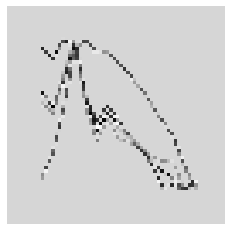

In [194]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [195]:
X = X/255

In [196]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [197]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [198]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [199]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [200]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('JBLU')]
    y = nr_test_data['{}_y'.format('JBLU')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('JBLU'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_non_recession.csv'.format(experiment,'JBLU')):
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'JBLU'))
    else:
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'JBLU'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('JBLU')]
    y = r_test_data['{}_y'.format('JBLU')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('JBLU'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_recession.csv'.format(experiment,'JBLU')):
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'JBLU'))
    else:
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'JBLU'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.276688453159041, 1: 7.6255707762557075, 2: 0.3661076400306917}



RUNNING EPOCHS 0 - 20



Epoch 1/20
27/27 [==============================] - 0s 17ms/step - loss: 0.2492 - accuracy: 0.3204 - mse: 1.6919 - weighted_accuracy: 0.3244 - weighted_mse: 1.6947 - val_loss: 0.1894 - val_accuracy: 0.5102 - val_mse: 1.0867 - val_weighted_accuracy: 0.5102 - val_weighted_mse: 1.0867
Epoch 2/20
27/27 [==============================] - 0s 9ms/step - loss: 0.2111 - accuracy: 0.2470 - mse: 1.2565 - weighted_accuracy: 0.3291 - weighted_mse: 1.2693 - val_loss: 0.1859 - val_accuracy: 0.8192 - val_mse: 1.0145 - val_weighted_accuracy: 0.8192 - val_weighted_mse: 1.0145
Epoch 3/20
27/27 [==============================] - 0s 9ms/step - loss: 0.2097 - accuracy: 0.2237 - mse: 1.1240 - weighted_accuracy: 0.3353 - weighted_mse: 1.1162 - val_loss: 0.2076 - val_accuracy: 0.0443 - val_mse: 1.0454 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 1.0454
Epoch 4/20
27/27 [==============================] - 0s 9

7/7 [==============================] - 0s 2ms/step - loss: 0.1932 - accuracy: 0.2511 - mse: 1.0933 - weighted_accuracy: 0.2511 - weighted_mse: 1.0933
Test loss: 0.1931898593902588
Test accuracy: 0.2511415481567383


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 89
actual holds but predicted sell: 65
actual predicted holds: 43
Percentage buys correct: 7.0%
Percentage sells correct: 7.042253521126761%
Percentage holds correct: 89.58333333333333%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.474747474747474%
Percentage high sells correct: 53.521126760563384%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Price increase from previously

27/27 [==============================] - 0s 9ms/step - loss: 0.1819 - accuracy: 0.2545 - mse: 1.2671 - weighted_accuracy: 0.5218 - weighted_mse: 1.2289 - val_loss: 0.1865 - val_accuracy: 0.4036 - val_mse: 0.8977 - val_weighted_accuracy: 0.4036 - val_weighted_mse: 0.8977
Epoch 13/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1802 - accuracy: 0.3180 - mse: 1.3145 - weighted_accuracy: 0.5130 - weighted_mse: 1.2575 - val_loss: 0.1972 - val_accuracy: 0.1856 - val_mse: 1.1876 - val_weighted_accuracy: 0.1856 - val_weighted_mse: 1.1876
Epoch 14/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1809 - accuracy: 0.2482 - mse: 1.3058 - weighted_accuracy: 0.5340 - weighted_mse: 1.2755 - val_loss: 0.2065 - val_accuracy: 0.1162 - val_mse: 1.1591 - val_weighted_accuracy: 0.1162 - val_weighted_mse: 1.1591
Epoch 15/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1820 - accuracy: 0.2644 - mse: 1.3276 - weighted_accuracy: 0.5253 - weighted_mse: 1.3102

7/7 [==============================] - 0s 2ms/step - loss: 0.2051 - accuracy: 0.1963 - mse: 1.0197 - weighted_accuracy: 0.1963 - weighted_mse: 1.0197
Test loss: 0.20507903397083282
Test accuracy: 0.19634702801704407


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 61
actual holds but predicted sell: 105
actual predicted holds: 31
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 6.956521739130435%
Percentage holds correct: 86.11111111111111%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.76119402985075%
Percentage high sells correct: 47.82608695652174%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Pri

27/27 [==============================] - 0s 10ms/step - loss: 0.1705 - accuracy: 0.2225 - mse: 1.3919 - weighted_accuracy: 0.5839 - weighted_mse: 1.3474 - val_loss: 0.2048 - val_accuracy: 0.1868 - val_mse: 1.1080 - val_weighted_accuracy: 0.1868 - val_weighted_mse: 1.1080
Epoch 7/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1719 - accuracy: 0.2123 - mse: 1.3522 - weighted_accuracy: 0.5679 - weighted_mse: 1.3029 - val_loss: 0.1985 - val_accuracy: 0.2084 - val_mse: 1.2029 - val_weighted_accuracy: 0.2084 - val_weighted_mse: 1.2029
Epoch 8/20
27/27 [==============================] - 0s 10ms/step - loss: 0.1663 - accuracy: 0.2769 - mse: 1.3872 - weighted_accuracy: 0.5938 - weighted_mse: 1.3746 - val_loss: 0.1999 - val_accuracy: 0.1976 - val_mse: 1.1820 - val_weighted_accuracy: 0.1976 - val_weighted_mse: 1.1820
Epoch 9/20
27/27 [==============================] - 0s 10ms/step - loss: 0.1680 - accuracy: 0.2207 - mse: 1.3650 - weighted_accuracy: 0.5983 - weighted_mse: 1.3206

7/7 [==============================] - 0s 2ms/step - loss: 0.1986 - accuracy: 0.2466 - mse: 1.2537 - weighted_accuracy: 0.2466 - weighted_mse: 1.2537
Test loss: 0.19860774278640747
Test accuracy: 0.24657534062862396


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 60
actual holds but predicted sell: 96
actual predicted holds: 41
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 6.730769230769231%
Percentage holds correct: 87.23404255319149%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 52.23880597014925%
Percentage high sells correct: 49.03846153846154%
Percentage mid holds correct: 82.97872340425532%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Pric

27/27 [==============================] - 0s 9ms/step - loss: 0.1555 - accuracy: 0.2611 - mse: 1.5095 - weighted_accuracy: 0.6494 - weighted_mse: 1.4780 - val_loss: 0.1952 - val_accuracy: 0.2683 - val_mse: 1.1593 - val_weighted_accuracy: 0.2683 - val_weighted_mse: 1.1593
Epoch 8/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1553 - accuracy: 0.2710 - mse: 1.4527 - weighted_accuracy: 0.6448 - weighted_mse: 1.4600 - val_loss: 0.1960 - val_accuracy: 0.2180 - val_mse: 1.3039 - val_weighted_accuracy: 0.2180 - val_weighted_mse: 1.3039
Epoch 9/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1576 - accuracy: 0.2539 - mse: 1.4483 - weighted_accuracy: 0.6282 - weighted_mse: 1.4345 - val_loss: 0.1913 - val_accuracy: 0.3150 - val_mse: 1.2545 - val_weighted_accuracy: 0.3150 - val_weighted_mse: 1.2545
Epoch 10/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1506 - accuracy: 0.2796 - mse: 1.5216 - weighted_accuracy: 0.6500 - weighted_mse: 1.5191 -

7/7 [==============================] - 0s 2ms/step - loss: 0.1932 - accuracy: 0.2831 - mse: 1.3463 - weighted_accuracy: 0.2831 - weighted_mse: 1.3463
Test loss: 0.19316235184669495
Test accuracy: 0.2831050157546997


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 54
actual holds but predicted sell: 93
actual predicted holds: 50
Percentage buys correct: 8.19672131147541%
Percentage sells correct: 6.930693069306931%
Percentage holds correct: 87.71929824561404%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.666666666666664%
Percentage high sells correct: 52.475247524752476%
Percentage mid holds correct: 82.45614035087719%


Capital: 100
Share price: $0.707959263378032
Shares owned at the moment: 140
Cash capital at the moment: $0.6131388106749682


Price 

27/27 [==============================] - 0s 9ms/step - loss: 0.1415 - accuracy: 0.3299 - mse: 1.6049 - weighted_accuracy: 0.6961 - weighted_mse: 1.6261 - val_loss: 0.1949 - val_accuracy: 0.2611 - val_mse: 1.3803 - val_weighted_accuracy: 0.2611 - val_weighted_mse: 1.3803
Epoch 9/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1419 - accuracy: 0.3404 - mse: 1.5525 - weighted_accuracy: 0.6915 - weighted_mse: 1.6345 - val_loss: 0.1709 - val_accuracy: 0.5030 - val_mse: 1.1925 - val_weighted_accuracy: 0.5030 - val_weighted_mse: 1.1925
Epoch 10/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1412 - accuracy: 0.3458 - mse: 1.6774 - weighted_accuracy: 0.6912 - weighted_mse: 1.7557 - val_loss: 0.1929 - val_accuracy: 0.2838 - val_mse: 1.3794 - val_weighted_accuracy: 0.2838 - val_weighted_mse: 1.3794
Epoch 11/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1421 - accuracy: 0.3419 - mse: 1.5758 - weighted_accuracy: 0.6730 - weighted_mse: 1.6575 

7/7 [==============================] - 0s 10ms/step - loss: 0.1826 - accuracy: 0.4155 - mse: 1.3903 - weighted_accuracy: 0.4155 - weighted_mse: 1.3903
Test loss: 0.18260547518730164
Test accuracy: 0.4155251085758209


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 41
actual holds but predicted sell: 76
actual predicted holds: 80
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 89.88764044943821%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.111111111111114%
Percentage high sells correct: 55.95238095238095%
Percentage mid holds correct: 84.26966292134831%


Capital: 100
Share price: $0.707959263378032
Shares owned at the moment: 140
Cash capital at the moment: $0.6131388106749682


Price

27/27 [==============================] - 0s 9ms/step - loss: 0.1302 - accuracy: 0.4614 - mse: 1.8189 - weighted_accuracy: 0.7352 - weighted_mse: 2.0213 - val_loss: 0.1789 - val_accuracy: 0.4623 - val_mse: 1.4200 - val_weighted_accuracy: 0.4623 - val_weighted_mse: 1.4200
Epoch 12/20
27/27 [==============================] - 0s 10ms/step - loss: 0.1272 - accuracy: 0.4590 - mse: 1.8403 - weighted_accuracy: 0.7352 - weighted_mse: 2.0027 - val_loss: 0.1752 - val_accuracy: 0.4707 - val_mse: 1.4875 - val_weighted_accuracy: 0.4707 - val_weighted_mse: 1.4875
Epoch 13/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1242 - accuracy: 0.4844 - mse: 1.8701 - weighted_accuracy: 0.7540 - weighted_mse: 2.1126 - val_loss: 0.1745 - val_accuracy: 0.4886 - val_mse: 1.5316 - val_weighted_accuracy: 0.4886 - val_weighted_mse: 1.5316
Epoch 14/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1248 - accuracy: 0.4898 - mse: 1.8661 - weighted_accuracy: 0.7524 - weighted_mse: 2.077

Epoch 1/20
27/27 [==============================] - 0s 10ms/step - loss: 0.1198 - accuracy: 0.5153 - mse: 1.8991 - weighted_accuracy: 0.7632 - weighted_mse: 2.2313 - val_loss: 0.1620 - val_accuracy: 0.5844 - val_mse: 1.4776 - val_weighted_accuracy: 0.5844 - val_weighted_mse: 1.4776
Epoch 2/20
27/27 [==============================] - 0s 10ms/step - loss: 0.1206 - accuracy: 0.5138 - mse: 1.9892 - weighted_accuracy: 0.7648 - weighted_mse: 2.2997 - val_loss: 0.1686 - val_accuracy: 0.5401 - val_mse: 1.5644 - val_weighted_accuracy: 0.5401 - val_weighted_mse: 1.5644
Epoch 3/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1167 - accuracy: 0.5201 - mse: 1.9816 - weighted_accuracy: 0.7779 - weighted_mse: 2.3056 - val_loss: 0.1756 - val_accuracy: 0.4982 - val_mse: 1.6035 - val_weighted_accuracy: 0.4982 - val_weighted_mse: 1.6035
Epoch 4/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1170 - accuracy: 0.5045 - mse: 1.9884 - weighted_accuracy: 0.7787 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.1497 - accuracy: 0.6301 - mse: 1.7982 - weighted_accuracy: 0.6301 - weighted_mse: 1.7982
Test loss: 0.1497499942779541
Test accuracy: 0.6301369667053223


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 31
actual holds but predicted sell: 33
actual predicted holds: 133
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 5.714285714285714%
Percentage holds correct: 88.66666666666667%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 54.54545454545455%
Percentage high sells correct: 62.857142857142854%
Percentage mid holds correct: 84.66666666666667%


Capital: 100
Share price: $0.707959263378032
Shares owned at the moment: 140
Cash capital at the moment: $0.6131388106749682


Price

27/27 [==============================] - 0s 16ms/step - loss: 0.1024 - accuracy: 0.6269 - mse: 2.2475 - weighted_accuracy: 0.8062 - weighted_mse: 2.9189 - val_loss: 0.1475 - val_accuracy: 0.6707 - val_mse: 1.7607 - val_weighted_accuracy: 0.6707 - val_weighted_mse: 1.7607
Epoch 17/20
27/27 [==============================] - 0s 14ms/step - loss: 0.1008 - accuracy: 0.6350 - mse: 2.2440 - weighted_accuracy: 0.8134 - weighted_mse: 2.8326 - val_loss: 0.1439 - val_accuracy: 0.6922 - val_mse: 1.8031 - val_weighted_accuracy: 0.6922 - val_weighted_mse: 1.8031
Epoch 18/20
27/27 [==============================] - 0s 14ms/step - loss: 0.1036 - accuracy: 0.6216 - mse: 2.2807 - weighted_accuracy: 0.8042 - weighted_mse: 2.9695 - val_loss: 0.1465 - val_accuracy: 0.6766 - val_mse: 1.6623 - val_weighted_accuracy: 0.6766 - val_weighted_mse: 1.6623
Epoch 19/20
27/27 [==============================] - 0s 14ms/step - loss: 0.1018 - accuracy: 0.6353 - mse: 2.1897 - weighted_accuracy: 0.8072 - weighted_mse: 2.

27/27 [==============================] - 0s 16ms/step - loss: 0.0989 - accuracy: 0.6557 - mse: 2.3244 - weighted_accuracy: 0.8021 - weighted_mse: 3.0177 - val_loss: 0.1369 - val_accuracy: 0.7246 - val_mse: 1.7807 - val_weighted_accuracy: 0.7246 - val_weighted_mse: 1.7807
Epoch 2/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0986 - accuracy: 0.6320 - mse: 2.2355 - weighted_accuracy: 0.8207 - weighted_mse: 2.8943 - val_loss: 0.1358 - val_accuracy: 0.7293 - val_mse: 1.7699 - val_weighted_accuracy: 0.7293 - val_weighted_mse: 1.7699
Epoch 3/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0964 - accuracy: 0.6608 - mse: 2.4146 - weighted_accuracy: 0.8122 - weighted_mse: 3.1013 - val_loss: 0.1456 - val_accuracy: 0.6814 - val_mse: 1.8834 - val_weighted_accuracy: 0.6814 - val_weighted_mse: 1.8834
Epoch 4/20
27/27 [==============================] - 0s 15ms/step - loss: 0.1013 - accuracy: 0.6317 - mse: 2.2408 - weighted_accuracy: 0.7848 - weighted_mse: 2.997

0          19.481992  


Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.1210 - accuracy: 0.7945 - mse: 2.1093 - weighted_accuracy: 0.7945 - weighted_mse: 2.1093
Test loss: 0.12101259082555771
Test accuracy: 0.7945205569267273


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 16
actual holds but predicted sell: 9
actual predicted holds: 172
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 10.0%
Percentage holds correct: 89.58333333333333%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 58.8235294117647%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 83.7696335078534%


Capital: 100
Share price: $0.707959263378032
Shares owned at the moment: 140
Cash capital at the moment: $0.61313881067

27/27 [==============================] - 0s 14ms/step - loss: 0.0791 - accuracy: 0.7317 - mse: 2.7457 - weighted_accuracy: 0.8510 - weighted_mse: 4.0333 - val_loss: 0.1187 - val_accuracy: 0.7880 - val_mse: 2.2111 - val_weighted_accuracy: 0.7880 - val_weighted_mse: 2.2111
Epoch 20/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0847 - accuracy: 0.7365 - mse: 2.9705 - weighted_accuracy: 0.8381 - weighted_mse: 4.1787 - val_loss: 0.1253 - val_accuracy: 0.7784 - val_mse: 2.3002 - val_weighted_accuracy: 0.7784 - val_weighted_mse: 2.3002
Validation loss: 0.1253347545862198
Validation accuracy: 0.7784430980682373


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.1166 - accuracy: 0.7844 - mse: 2.2858 - weighted_accuracy: 0.7844 - weighted_mse: 2.2858
Test loss: 0.11656195670366287
Test accuracy: 0.7844036817550659


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual s

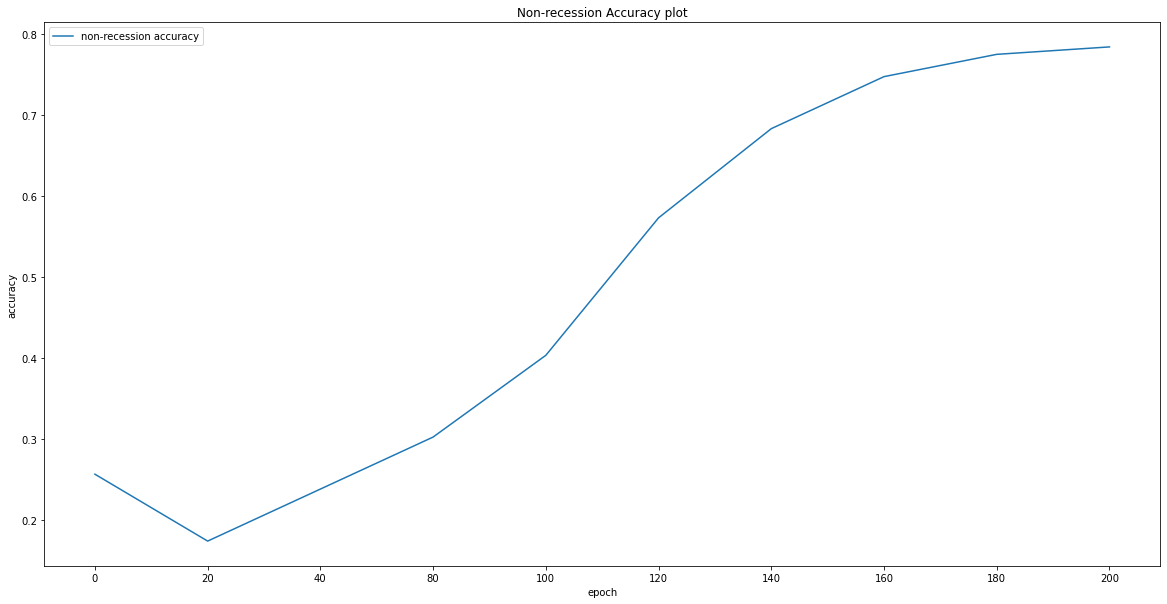

In [201]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

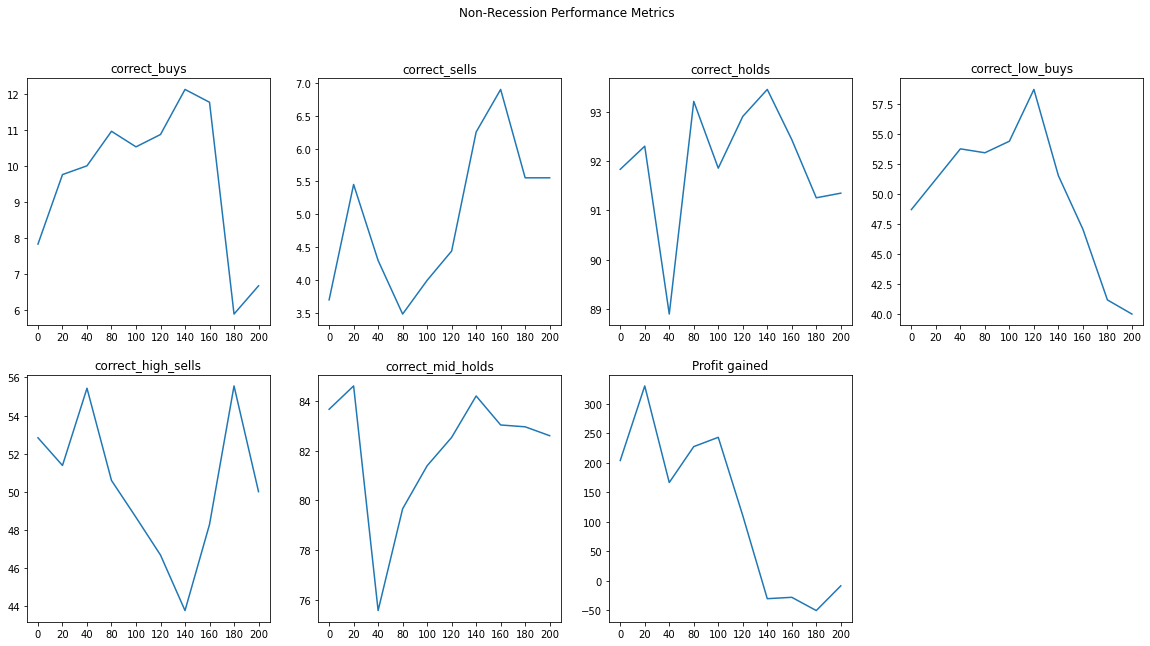

In [202]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

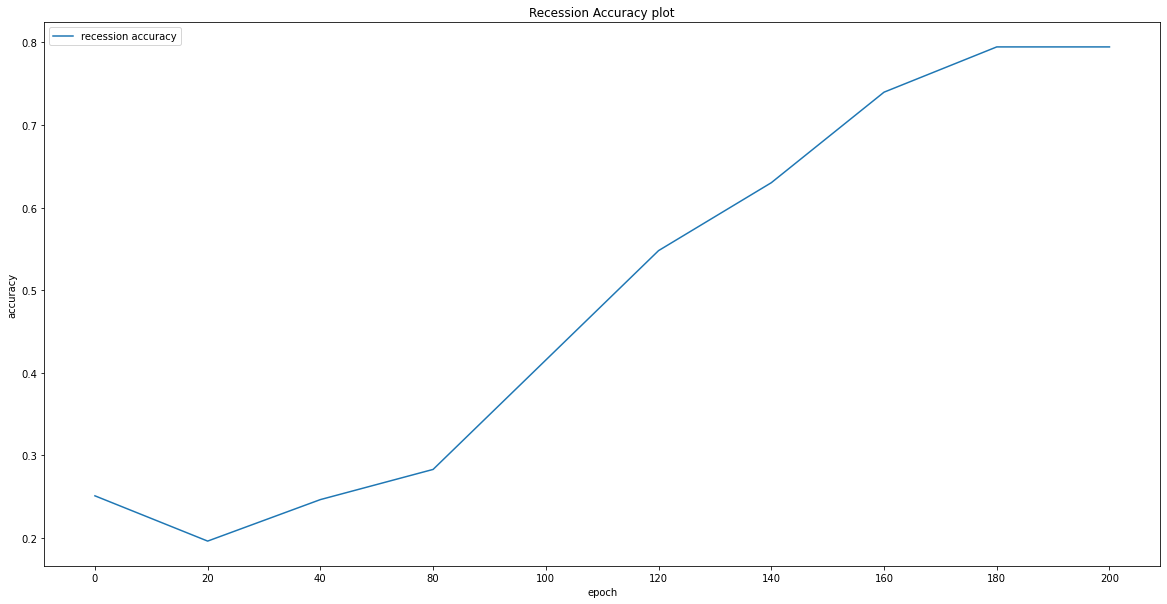

In [203]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

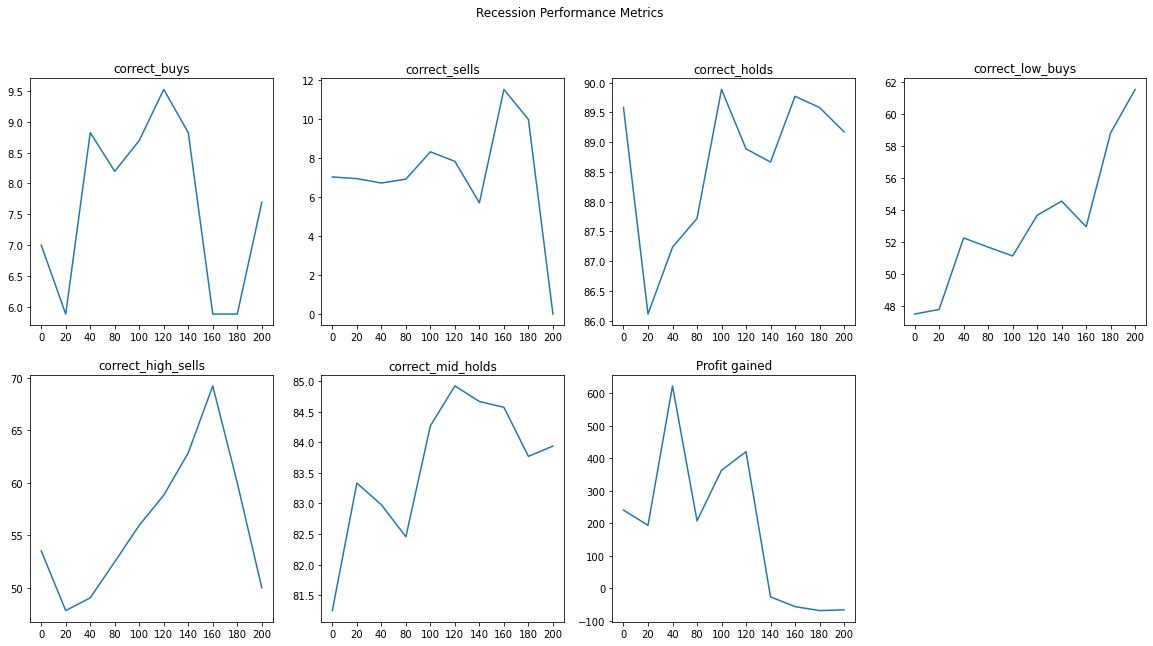

In [204]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### With Support Stock Data

In [205]:
nr_test_sets = ['JBLU']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/DAL_data_test.csv")
    df2.set_index('Date', inplace=True)
    df['support'] = df2['previous_1d']
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    support_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    data_15_support = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            support_data.append(data_15_support_arr)
            labels.append(i[4])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]
            data_15_support = data_15_support[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    support_data = np.array(support_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        n = support_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)
        ax.plot(n)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    17.600000  17.005903  -4.149392  23132100.0     2.0
2019-01-23    17.370001  17.061918 -14.049519  19087600.0     2.0
2019-01-24    17.240000  17.089315 -19.421466  14999400.0     2.0
2019-01-25    18.120001  17.247882  -5.555506  23032100.0     2.0
2019-01-28    17.709999  17.318977 -26.363710  14531900.0     2.0


In [206]:
r_test_sets = ['JBLU']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/DAL_data_test2.csv")
    df2.set_index('Date', inplace=True)
    df['support'] = df2['previous_1d']
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    support_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    data_15_support = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            support_data.append(data_15_support_arr)
            labels.append(i[4])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]
            data_15_support = data_15_support[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    support_data = np.array(support_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        n = support_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)
        ax.plot(n)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    19.049999  18.785034 -29.629734  -5172900.0     2.0
2020-01-23    19.790001  18.939644 -15.920381   7229600.0     0.0
2020-01-24    21.070000  19.267391  -2.622949  23219300.0     2.0
2020-01-27    20.650000  19.480100 -18.060233  11950900.0     2.0
2020-01-28    20.040001  19.566239 -38.461529   3416600.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2002-05-02    14.761481  13.724947  -5.141986  58104336.0     2.0
2002-05-03    14.562963  13.853872 -13.413429  57315261.0     2.0
2002-05-06    15.419259  14.094701  -0.086583  58757399.0     0.0
2002-05-07    16.148148  14.410616  -4.436861  61163774.0     2.0
2002-05-08    14.696296  14.454567 -37.883964  57784724.0     2.0


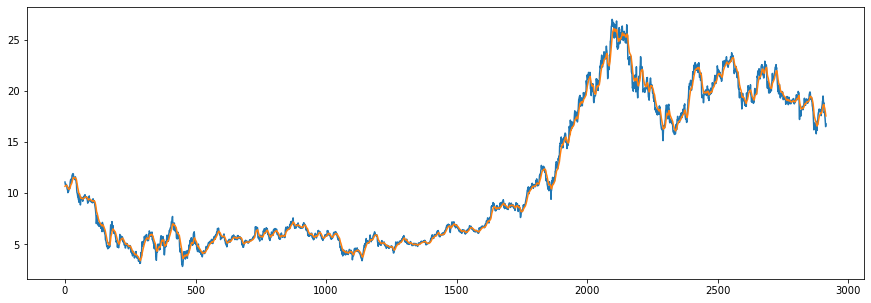

(2902, 64, 64, 1)

In [207]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 6/initial_indicators/JBLU_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

df2 = pd.read_csv("variation 6/initial_indicators/DAL_data.csv")
df2.set_index('Date', inplace=True)
df['support'] = df2['previous_1d']
df.dropna(inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    n = support_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)
    ax.plot(n)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

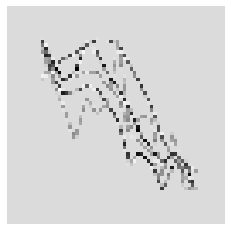

In [208]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [209]:
X = X/255

In [210]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [211]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [212]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [213]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [214]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('JBLU')]
    y = nr_test_data['{}_y'.format('JBLU')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('JBLU'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_non_recession.csv'.format(experiment,'JBLU')):
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'JBLU'))
    else:
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'JBLU'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('JBLU')]
    y = r_test_data['{}_y'.format('JBLU')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('JBLU'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_recession.csv'.format(experiment,'JBLU')):
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'JBLU'))
    else:
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'JBLU'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.29874213836478, 1: 7.439102564102564, 2: 0.36649297331438496}



RUNNING EPOCHS 0 - 20



Epoch 1/20
19/19 [==============================] - 0s 19ms/step - loss: 0.2617 - accuracy: 0.4024 - mse: 1.8939 - weighted_accuracy: 0.3614 - weighted_mse: 1.9813 - val_loss: 0.2153 - val_accuracy: 0.0620 - val_mse: 0.8033 - val_weighted_accuracy: 0.0620 - val_weighted_mse: 0.8033
Epoch 2/20
19/19 [==============================] - 0s 10ms/step - loss: 0.2119 - accuracy: 0.2848 - mse: 1.2416 - weighted_accuracy: 0.2894 - weighted_mse: 1.2387 - val_loss: 0.2179 - val_accuracy: 0.0482 - val_mse: 0.9256 - val_weighted_accuracy: 0.0482 - val_weighted_mse: 0.9256
Epoch 3/20
19/19 [==============================] - 0s 9ms/step - loss: 0.2053 - accuracy: 0.3516 - mse: 1.1481 - weighted_accuracy: 0.3350 - weighted_mse: 1.1697 - val_loss: 0.2056 - val_accuracy: 0.0448 - val_mse: 0.9647 - val_weighted_accuracy: 0.0448 - val_weighted_mse: 0.9647
Epoch 4/20
19/19 [==============================] - 0s 9

19/19 [==============================] - 0s 10ms/step - loss: 0.1982 - accuracy: 0.3598 - mse: 1.1607 - weighted_accuracy: 0.3919 - weighted_mse: 1.1586 - val_loss: 0.1971 - val_accuracy: 0.0654 - val_mse: 0.9905 - val_weighted_accuracy: 0.0654 - val_weighted_mse: 0.9905
Epoch 2/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1996 - accuracy: 0.2848 - mse: 1.1848 - weighted_accuracy: 0.3884 - weighted_mse: 1.1644 - val_loss: 0.1955 - val_accuracy: 0.3511 - val_mse: 1.0028 - val_weighted_accuracy: 0.3511 - val_weighted_mse: 1.0028
Epoch 3/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1980 - accuracy: 0.3826 - mse: 1.1649 - weighted_accuracy: 0.4302 - weighted_mse: 1.1467 - val_loss: 0.1998 - val_accuracy: 0.1394 - val_mse: 1.1226 - val_weighted_accuracy: 0.1394 - val_weighted_mse: 1.1226
Epoch 4/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1972 - accuracy: 0.3813 - mse: 1.1755 - weighted_accuracy: 0.4025 - weighted_mse: 1.1800 -

0          19.481992  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1989 - accuracy: 0.0776 - mse: 1.0662 - weighted_accuracy: 0.0776 - weighted_mse: 1.0662
Test loss: 0.19889694452285767
Test accuracy: 0.077625572681427


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 7
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 123
actual holds but predicted sell: 71
actual predicted holds: 3
Percentage buys correct: 6.474820143884892%
Percentage sells correct: 6.578947368421052%
Percentage holds correct: 75.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.82608695652174%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 75.0%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Pri

19/19 [==============================] - 0s 9ms/step - loss: 0.1854 - accuracy: 0.2882 - mse: 1.2237 - weighted_accuracy: 0.4896 - weighted_mse: 1.2028 - val_loss: 0.1969 - val_accuracy: 0.1256 - val_mse: 1.0745 - val_weighted_accuracy: 0.1256 - val_weighted_mse: 1.0745
Epoch 12/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1791 - accuracy: 0.2835 - mse: 1.2447 - weighted_accuracy: 0.5358 - weighted_mse: 1.2570 - val_loss: 0.1961 - val_accuracy: 0.1325 - val_mse: 1.0739 - val_weighted_accuracy: 0.1325 - val_weighted_mse: 1.0739
Epoch 13/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1832 - accuracy: 0.2663 - mse: 1.2676 - weighted_accuracy: 0.5024 - weighted_mse: 1.2349 - val_loss: 0.1939 - val_accuracy: 0.1343 - val_mse: 1.0813 - val_weighted_accuracy: 0.1343 - val_weighted_mse: 1.0813
Epoch 14/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1837 - accuracy: 0.2706 - mse: 1.2492 - weighted_accuracy: 0.5316 - weighted_mse: 1.2155



Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1999 - accuracy: 0.0913 - mse: 1.0771 - weighted_accuracy: 0.0913 - weighted_mse: 1.0771
Test loss: 0.19988933205604553
Test accuracy: 0.09132420271635056


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 7
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 114
actual holds but predicted sell: 77
actual predicted holds: 6
Percentage buys correct: 6.923076923076923%
Percentage sells correct: 6.097560975609756%
Percentage holds correct: 85.71428571428571%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 49.6124031007752%
Percentage high sells correct: 48.78048780487805%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.237829

19/19 [==============================] - 0s 9ms/step - loss: 0.1709 - accuracy: 0.2546 - mse: 1.2804 - weighted_accuracy: 0.5706 - weighted_mse: 1.2689 - val_loss: 0.2005 - val_accuracy: 0.1188 - val_mse: 0.9927 - val_weighted_accuracy: 0.1188 - val_weighted_mse: 0.9927
Epoch 10/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1739 - accuracy: 0.2637 - mse: 1.3221 - weighted_accuracy: 0.5498 - weighted_mse: 1.2923 - val_loss: 0.1929 - val_accuracy: 0.2134 - val_mse: 1.1382 - val_weighted_accuracy: 0.2134 - val_weighted_mse: 1.1382
Epoch 11/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1723 - accuracy: 0.2762 - mse: 1.2821 - weighted_accuracy: 0.5573 - weighted_mse: 1.2330 - val_loss: 0.1930 - val_accuracy: 0.2014 - val_mse: 1.1594 - val_weighted_accuracy: 0.2014 - val_weighted_mse: 1.1594
Epoch 12/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1725 - accuracy: 0.2564 - mse: 1.3551 - weighted_accuracy: 0.5322 - weighted_mse: 1.3293

0          19.481992  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1960 - accuracy: 0.1826 - mse: 1.1457 - weighted_accuracy: 0.1826 - weighted_mse: 1.1457
Test loss: 0.19596678018569946
Test accuracy: 0.1826484054327011


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 85
actual holds but predicted sell: 85
actual predicted holds: 27
Percentage buys correct: 7.368421052631579%
Percentage sells correct: 6.593406593406593%
Percentage holds correct: 81.81818181818181%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 46.808510638297875%
Percentage high sells correct: 50.54945054945055%
Percentage mid holds correct: 78.78787878787878%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital 

Epoch 5/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1670 - accuracy: 0.2831 - mse: 1.3235 - weighted_accuracy: 0.5779 - weighted_mse: 1.2946 - val_loss: 0.1914 - val_accuracy: 0.2496 - val_mse: 1.1603 - val_weighted_accuracy: 0.2496 - val_weighted_mse: 1.1603
Epoch 6/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1647 - accuracy: 0.2641 - mse: 1.3700 - weighted_accuracy: 0.5744 - weighted_mse: 1.3332 - val_loss: 0.1923 - val_accuracy: 0.2341 - val_mse: 1.1710 - val_weighted_accuracy: 0.2341 - val_weighted_mse: 1.1710
Epoch 7/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1613 - accuracy: 0.3262 - mse: 1.3543 - weighted_accuracy: 0.5848 - weighted_mse: 1.3695 - val_loss: 0.1884 - val_accuracy: 0.2788 - val_mse: 1.2220 - val_weighted_accuracy: 0.2788 - val_weighted_mse: 1.2220
Epoch 8/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1581 - accuracy: 0.3007 - mse: 1.4167 - weighted_accuracy: 0.6118 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1898 - accuracy: 0.2922 - mse: 1.2436 - weighted_accuracy: 0.2922 - weighted_mse: 1.2436
Test loss: 0.18976594507694244
Test accuracy: 0.29223743081092834


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 76
actual holds but predicted sell: 69
actual predicted holds: 52
Percentage buys correct: 8.235294117647058%
Percentage sells correct: 6.756756756756757%
Percentage holds correct: 86.66666666666667%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 47.2972972972973%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Price increase fro

19/19 [==============================] - 0s 9ms/step - loss: 0.1471 - accuracy: 0.3567 - mse: 1.4684 - weighted_accuracy: 0.6503 - weighted_mse: 1.5043 - val_loss: 0.1952 - val_accuracy: 0.2788 - val_mse: 1.2100 - val_weighted_accuracy: 0.2788 - val_weighted_mse: 1.2100
Epoch 10/20
19/19 [==============================] - 0s 8ms/step - loss: 0.1492 - accuracy: 0.3882 - mse: 1.5055 - weighted_accuracy: 0.6379 - weighted_mse: 1.5427 - val_loss: 0.1878 - val_accuracy: 0.3219 - val_mse: 1.1739 - val_weighted_accuracy: 0.3219 - val_weighted_mse: 1.1739
Epoch 11/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1453 - accuracy: 0.3688 - mse: 1.4680 - weighted_accuracy: 0.6727 - weighted_mse: 1.5135 - val_loss: 0.1933 - val_accuracy: 0.2926 - val_mse: 1.2258 - val_weighted_accuracy: 0.2926 - val_weighted_mse: 1.2258
Epoch 12/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1522 - accuracy: 0.3593 - mse: 1.4975 - weighted_accuracy: 0.6331 - weighted_mse: 1.5057

0          19.481992  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1887 - accuracy: 0.3699 - mse: 1.2623 - weighted_accuracy: 0.3699 - weighted_mse: 1.2623
Test loss: 0.18873129785060883
Test accuracy: 0.36986300349235535


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 72
actual holds but predicted sell: 56
actual predicted holds: 69
Percentage buys correct: 8.641975308641975%
Percentage sells correct: 8.19672131147541%
Percentage holds correct: 89.6103896103896%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 53.75%
Percentage high sells correct: 54.09836065573771%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment:

19/19 [==============================] - 0s 9ms/step - loss: 0.1353 - accuracy: 0.4507 - mse: 1.5377 - weighted_accuracy: 0.6998 - weighted_mse: 1.6456 - val_loss: 0.1861 - val_accuracy: 0.3804 - val_mse: 1.4591 - val_weighted_accuracy: 0.3804 - val_weighted_mse: 1.4591
Epoch 10/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1319 - accuracy: 0.4296 - mse: 1.6804 - weighted_accuracy: 0.6890 - weighted_mse: 1.8457 - val_loss: 0.1786 - val_accuracy: 0.4320 - val_mse: 1.2755 - val_weighted_accuracy: 0.4320 - val_weighted_mse: 1.2755
Epoch 11/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1360 - accuracy: 0.4205 - mse: 1.5511 - weighted_accuracy: 0.6856 - weighted_mse: 1.6745 - val_loss: 0.1750 - val_accuracy: 0.4441 - val_mse: 1.3178 - val_weighted_accuracy: 0.4441 - val_weighted_mse: 1.3178
Epoch 12/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1346 - accuracy: 0.4425 - mse: 1.5832 - weighted_accuracy: 0.6907 - weighted_mse: 1.7351

7/7 [==============================] - 0s 2ms/step - loss: 0.1763 - accuracy: 0.5114 - mse: 1.4738 - weighted_accuracy: 0.5114 - weighted_mse: 1.4738
Test loss: 0.17633457481861115
Test accuracy: 0.5114155411720276


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 48
actual holds but predicted sell: 48
actual predicted holds: 101
Percentage buys correct: 10.909090909090908%
Percentage sells correct: 9.433962264150944%
Percentage holds correct: 90.990990990991%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 57.407407407407405%
Percentage high sells correct: 58.490566037735846%
Percentage mid holds correct: 88.28828828828829%


Capital: 100
Share price: $0.707959263378032
Shares owned at the moment: 140
Cash capital at the moment: $0.6131388106749682


Price

19/19 [==============================] - 0s 9ms/step - loss: 0.1235 - accuracy: 0.5291 - mse: 1.7190 - weighted_accuracy: 0.7191 - weighted_mse: 1.9663 - val_loss: 0.1688 - val_accuracy: 0.5336 - val_mse: 1.3598 - val_weighted_accuracy: 0.5336 - val_weighted_mse: 1.3598
Epoch 12/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1202 - accuracy: 0.5252 - mse: 1.6887 - weighted_accuracy: 0.7180 - weighted_mse: 2.0158 - val_loss: 0.1607 - val_accuracy: 0.5818 - val_mse: 1.4456 - val_weighted_accuracy: 0.5818 - val_weighted_mse: 1.4456
Epoch 13/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1217 - accuracy: 0.5403 - mse: 1.7371 - weighted_accuracy: 0.7356 - weighted_mse: 2.0148 - val_loss: 0.1687 - val_accuracy: 0.5353 - val_mse: 1.4444 - val_weighted_accuracy: 0.5353 - val_weighted_mse: 1.4444
Epoch 14/20
19/19 [==============================] - 0s 8ms/step - loss: 0.1225 - accuracy: 0.5261 - mse: 1.8132 - weighted_accuracy: 0.7182 - weighted_mse: 2.1127


Price increase from previously bought: -15.123561460968027%
Share price: $0.31884351640756187
Shares owned at the moment: 0
Cash capital at the moment: $32.97167102460793


Share price: $0.24129253399808553
Shares owned at the moment: 136
Cash capital at the moment: $0.0656429931530127


Price increase from previously bought: 22.218176044383387%
Share price: $0.2957143181521891
Shares owned at the moment: 0
Cash capital at the moment: $40.17219310686181


Share price: $0.26918368134716425
Shares owned at the moment: 148
Cash capital at the moment: $0.22345050917320464


Price increase from previously bought: 8.546591317178343%
Share price: $0.2929932321882743
Shares owned at the moment: 0
Cash capital at the moment: $43.46720062753717


Share price: $0.22020406912089036
Shares owned at the moment: 196
Cash capital at the moment: $0.18851308658649657


Price increase from previously bought: 53.33181138344194%
Share price: $0.33857140586489626
Shares owned at the moment: 0
Cash capital 

Epoch 19/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1044 - accuracy: 0.6221 - mse: 1.8973 - weighted_accuracy: 0.7837 - weighted_mse: 2.4287 - val_loss: 0.1546 - val_accuracy: 0.6179 - val_mse: 1.5588 - val_weighted_accuracy: 0.6179 - val_weighted_mse: 1.5588
Epoch 20/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1091 - accuracy: 0.6368 - mse: 1.9033 - weighted_accuracy: 0.7859 - weighted_mse: 2.3126 - val_loss: 0.1368 - val_accuracy: 0.7332 - val_mse: 1.5218 - val_weighted_accuracy: 0.7332 - val_weighted_mse: 1.5218
Validation loss: 0.13676738739013672
Validation accuracy: 0.7332186102867126


Non-Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1308 - accuracy: 0.7752 - mse: 1.4610 - weighted_accuracy: 0.7752 - weighted_mse: 1.4610
Test loss: 0.1307961493730545
Test accuracy: 0.7752293348312378


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 

Epoch 1/20
19/19 [==============================] - 0s 10ms/step - loss: 0.1092 - accuracy: 0.6140 - mse: 1.9345 - weighted_accuracy: 0.7595 - weighted_mse: 2.4497 - val_loss: 0.1522 - val_accuracy: 0.6403 - val_mse: 1.5830 - val_weighted_accuracy: 0.6403 - val_weighted_mse: 1.5830
Epoch 2/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1064 - accuracy: 0.6075 - mse: 1.9112 - weighted_accuracy: 0.7692 - weighted_mse: 2.4576 - val_loss: 0.1410 - val_accuracy: 0.6936 - val_mse: 1.5986 - val_weighted_accuracy: 0.6936 - val_weighted_mse: 1.5986
Epoch 3/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1047 - accuracy: 0.6454 - mse: 1.9731 - weighted_accuracy: 0.7709 - weighted_mse: 2.5207 - val_loss: 0.1469 - val_accuracy: 0.6713 - val_mse: 1.5883 - val_weighted_accuracy: 0.6713 - val_weighted_mse: 1.5883
Epoch 4/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1003 - accuracy: 0.6441 - mse: 2.0903 - weighted_accuracy: 0.8005 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1380 - accuracy: 0.7260 - mse: 1.7714 - weighted_accuracy: 0.7260 - weighted_mse: 1.7714
Test loss: 0.1380489319562912
Test accuracy: 0.7260273694992065


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 25
actual holds but predicted sell: 18
actual predicted holds: 154
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 90.05847953216374%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 65.38461538461539%
Percentage high sells correct: 71.42857142857143%
Percentage mid holds correct: 84.7953216374269%


Capital: 100
Share price: $0.707959263378032
Shares owned at the moment: 140
Cash capital at the moment: $0.6131388106749682


Price i

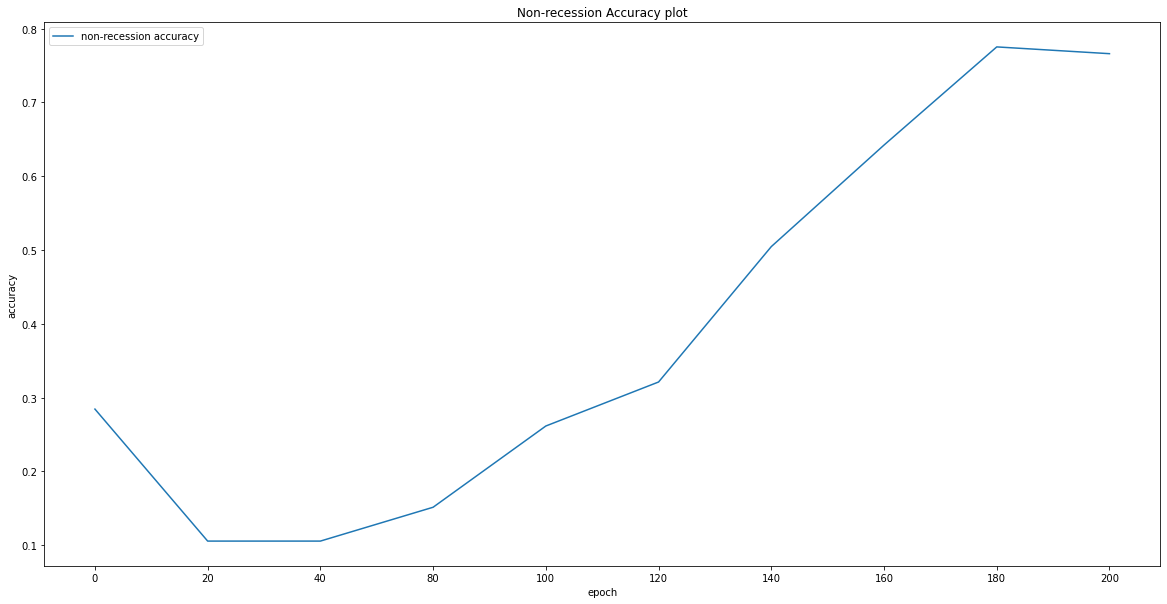

In [215]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

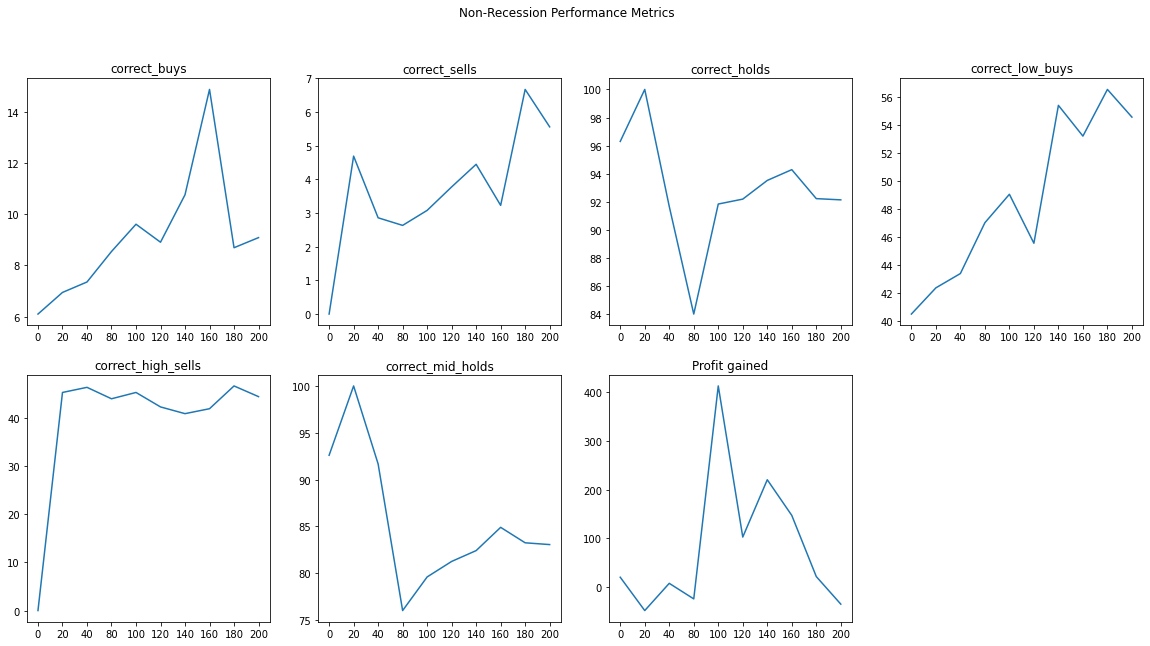

In [216]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

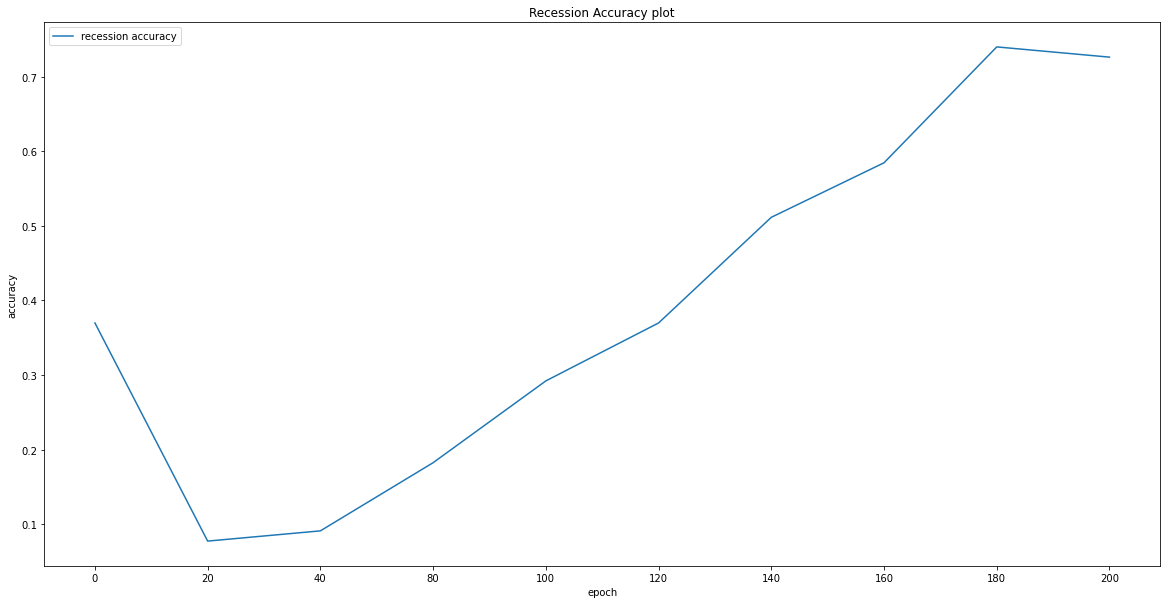

In [217]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

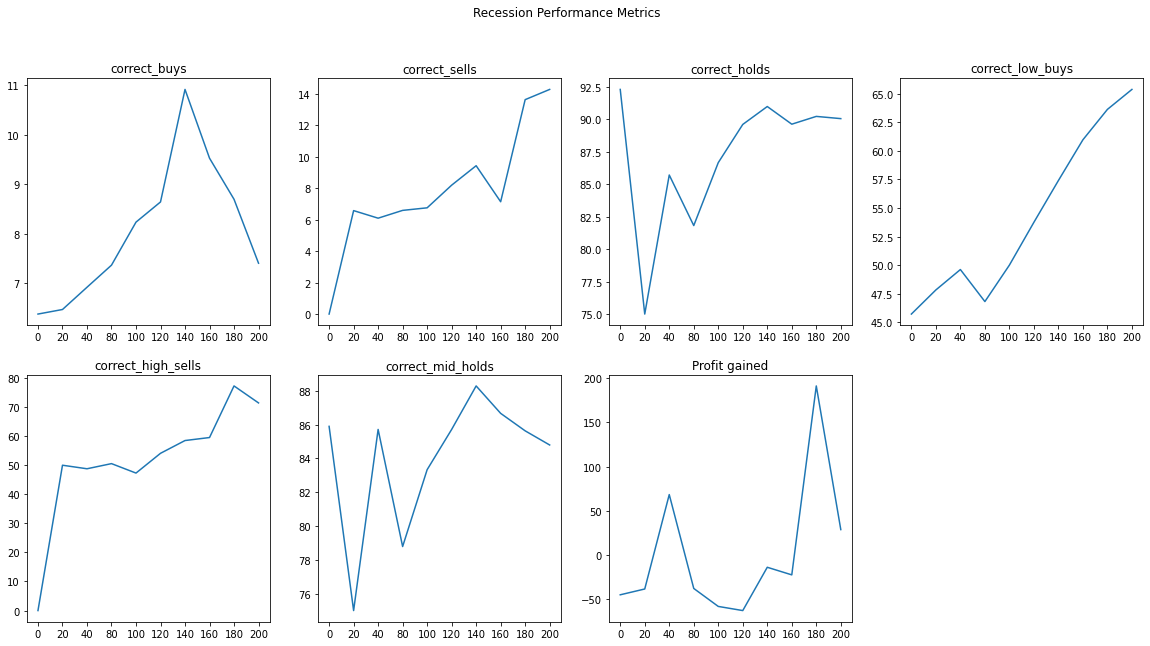

In [218]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

## The Kroger Co

### No support Stock Data

In [219]:
nr_test_sets = ['KR']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    29.430000  28.387007  -4.858258  41061300.0     2.0
2019-01-23    29.320000  28.530544  -9.311725  36484100.0     2.0
2019-01-24    29.240000  28.639691 -14.919380  31104500.0     2.0
2019-01-25    28.709999  28.650508 -38.135648  21525300.0     2.0
2019-01-28    28.120001  28.568891 -63.135567  13527400.0     2.0


In [220]:
r_test_sets = ['KR']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    28.410000  28.475794 -65.217413  9500700.0     2.0
2020-01-23    28.370001  28.459518 -68.695589  4678900.0     2.0
2020-01-24    28.440001  28.456515 -52.222168  8638500.0     2.0
2020-01-27    28.190001  28.415513 -79.999958  3996300.0     2.0
2020-01-28    28.330000  28.402357 -50.434793  8238000.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2000-01-21      8.68750  9.252111 -93.750000  -7835000.0     2.0
2000-01-24      8.40625  9.121979 -96.428571 -15986000.0     2.0
2000-01-25      8.15625  8.973405 -93.939394 -27586200.0     1.0
2000-01-26      8.06250  8.833266 -92.857143 -35302800.0     2.0
2000-01-27      8.25000  8.743533 -83.076923 -22065800.0     2.0


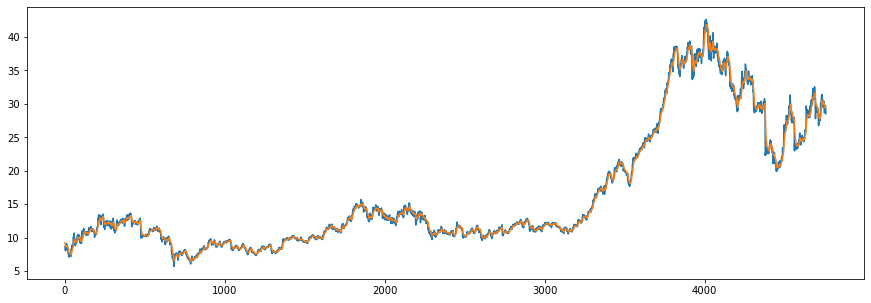

(4745, 64, 64, 1)

In [221]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 6/initial_indicators/KR_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

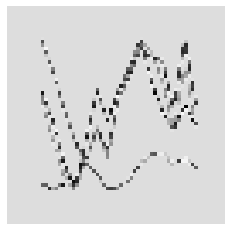

In [222]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [223]:
X = X/255

In [224]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [225]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [226]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [227]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [228]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('KR')]
    y = nr_test_data['{}_y'.format('KR')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('KR'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_non_recession.csv'.format(experiment,'KR')):
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'KR'))
    else:
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'KR'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('KR')]
    y = r_test_data['{}_y'.format('KR')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('KR'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_recession.csv'.format(experiment,'KR')):
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'KR'))
    else:
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'KR'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.3565891472868215, 1: 7.3565891472868215, 2: 0.36655079181151023}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2406 - accuracy: 0.3617 - mse: 1.6537 - weighted_accuracy: 0.3370 - weighted_mse: 1.6643 - val_loss: 0.2153 - val_accuracy: 0.0717 - val_mse: 0.8107 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 0.8107
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2067 - accuracy: 0.3290 - mse: 1.1965 - weighted_accuracy: 0.3508 - weighted_mse: 1.1901 - val_loss: 0.2122 - val_accuracy: 0.0548 - val_mse: 0.9912 - val_weighted_accuracy: 0.0548 - val_weighted_mse: 0.9912
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2038 - accuracy: 0.2827 - mse: 1.2308 - weighted_accuracy: 0.3375 - weighted_mse: 1.2095 - val_loss: 0.1974 - val_accuracy: 0.1739 - val_mse: 0.9414 - val_weighted_accuracy: 0.1739 - val_weighted_mse: 0.9414
Epoch 4/20
30/30 [==============================] - 0s

7/7 [==============================] - 0s 2ms/step - loss: 0.2010 - accuracy: 0.0776 - mse: 0.9741 - weighted_accuracy: 0.0776 - weighted_mse: 0.9741
Test loss: 0.20098206400871277
Test accuracy: 0.077625572681427


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 8
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 12
actual sells but predicted hold: 0
actual holds but predicted buy: 52
actual holds but predicted sell: 141
actual predicted holds: 0
Percentage buys correct: 8.620689655172415%
Percentage sells correct: 7.453416149068323%
Percentage holds correct: 0%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 43.85964912280702%
Percentage high sells correct: 42.857142857142854%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.03193980045076094
Shares owned at the moment: 3122
Cash capital at the moment: $0.009723835954332571


Price increase from previously bo

Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1910 - accuracy: 0.2295 - mse: 1.1952 - weighted_accuracy: 0.4598 - weighted_mse: 1.1603 - val_loss: 0.1922 - val_accuracy: 0.0706 - val_mse: 1.0491 - val_weighted_accuracy: 0.0706 - val_weighted_mse: 1.0491
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1876 - accuracy: 0.2113 - mse: 1.2353 - weighted_accuracy: 0.4605 - weighted_mse: 1.2008 - val_loss: 0.1893 - val_accuracy: 0.1338 - val_mse: 1.0127 - val_weighted_accuracy: 0.1338 - val_weighted_mse: 1.0127
Epoch 15/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1920 - accuracy: 0.2097 - mse: 1.1714 - weighted_accuracy: 0.4415 - weighted_mse: 1.1377 - val_loss: 0.1950 - val_accuracy: 0.0738 - val_mse: 0.9956 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 0.9956
Epoch 16/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1882 - accuracy: 0.2084 - mse: 1.2474 - weighted_accuracy: 0.4797 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1991 - accuracy: 0.0731 - mse: 0.9313 - weighted_accuracy: 0.0731 - weighted_mse: 0.9313
Test loss: 0.19906927645206451
Test accuracy: 0.07305935770273209


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 5
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 88
actual holds but predicted sell: 105
actual predicted holds: 0
Percentage buys correct: 7.920792079207921%
Percentage sells correct: 6.779661016949152%
Percentage holds correct: 0%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 47.0%
Percentage high sells correct: 44.91525423728814%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.21438787199088805
Shares owned at the moment: 465
Cash capital at the moment: $0.0354910329287037


Price increase from previously bought: -9.4055659

30/30 [==============================] - 0s 9ms/step - loss: 0.1820 - accuracy: 0.1620 - mse: 1.2844 - weighted_accuracy: 0.4829 - weighted_mse: 1.2233 - val_loss: 0.1965 - val_accuracy: 0.0738 - val_mse: 1.0112 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 1.0112
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1790 - accuracy: 0.1768 - mse: 1.2794 - weighted_accuracy: 0.5104 - weighted_mse: 1.2193 - val_loss: 0.1932 - val_accuracy: 0.0717 - val_mse: 1.2200 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 1.2200
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1798 - accuracy: 0.1876 - mse: 1.3250 - weighted_accuracy: 0.4886 - weighted_mse: 1.2747 - val_loss: 0.1993 - val_accuracy: 0.0695 - val_mse: 0.9841 - val_weighted_accuracy: 0.0695 - val_weighted_mse: 0.9841
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1780 - accuracy: 0.1665 - mse: 1.2927 - weighted_accuracy: 0.5011 - weighted_mse: 1.2423 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.1985 - accuracy: 0.1005 - mse: 1.1886 - weighted_accuracy: 0.1005 - weighted_mse: 1.1886
Test loss: 0.1984579712152481
Test accuracy: 0.1004566177725792


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 5
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 89
actual holds but predicted sell: 99
actual predicted holds: 5
Percentage buys correct: 7.070707070707071%
Percentage sells correct: 8.771929824561404%
Percentage holds correct: 83.33333333333333%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 51.02040816326531%
Percentage high sells correct: 48.24561403508772%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.06773673428799153
Shares owned at the moment: 1472
Cash capital at the moment: $0.017328827678667835


Pri

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1710 - accuracy: 0.1741 - mse: 1.3053 - weighted_accuracy: 0.5444 - weighted_mse: 1.2587 - val_loss: 0.1961 - val_accuracy: 0.0938 - val_mse: 1.2303 - val_weighted_accuracy: 0.0938 - val_weighted_mse: 1.2303
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1683 - accuracy: 0.1831 - mse: 1.3679 - weighted_accuracy: 0.5588 - weighted_mse: 1.3033 - val_loss: 0.1971 - val_accuracy: 0.0906 - val_mse: 1.1377 - val_weighted_accuracy: 0.0906 - val_weighted_mse: 1.1377
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1674 - accuracy: 0.1794 - mse: 1.3714 - weighted_accuracy: 0.5666 - weighted_mse: 1.3062 - val_loss: 0.1931 - val_accuracy: 0.1085 - val_mse: 1.2048 - val_weighted_accuracy: 0.1085 - val_weighted_mse: 1.2048
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1648 - accuracy: 0.1834 - mse: 1.3983 - weighted_accuracy: 0.5570 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1956 - accuracy: 0.1507 - mse: 1.2975 - weighted_accuracy: 0.1507 - weighted_mse: 1.2975
Test loss: 0.19559022784233093
Test accuracy: 0.15068493783473969


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 4
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 90
actual holds but predicted sell: 86
actual predicted holds: 17
Percentage buys correct: 7.920792079207921%
Percentage sells correct: 8.16326530612245%
Percentage holds correct: 85.0%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 55.0%
Percentage high sells correct: 51.02040816326531%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.06773673428799153
Shares owned at the moment: 1472
Cash capital at the moment: $0.017328827678667835


Price increase from previously bought: 42

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1525 - accuracy: 0.2213 - mse: 1.4447 - weighted_accuracy: 0.5967 - weighted_mse: 1.4334 - val_loss: 0.1976 - val_accuracy: 0.1349 - val_mse: 1.3050 - val_weighted_accuracy: 0.1349 - val_weighted_mse: 1.3050
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1550 - accuracy: 0.2194 - mse: 1.4733 - weighted_accuracy: 0.5868 - weighted_mse: 1.4492 - val_loss: 0.1960 - val_accuracy: 0.1391 - val_mse: 1.3563 - val_weighted_accuracy: 0.1391 - val_weighted_mse: 1.3563
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1529 - accuracy: 0.2150 - mse: 1.4851 - weighted_accuracy: 0.6073 - weighted_mse: 1.4741 - val_loss: 0.1966 - val_accuracy: 0.1591 - val_mse: 1.4026 - val_weighted_accuracy: 0.1591 - val_weighted_mse: 1.4026
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1526 - accuracy: 0.2258 - mse: 1.4815 - weighted_accuracy: 0.6149 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1923 - accuracy: 0.2740 - mse: 1.4256 - weighted_accuracy: 0.2740 - weighted_mse: 1.4256
Test loss: 0.19226214289665222
Test accuracy: 0.27397260069847107


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 73
actual holds but predicted sell: 75
actual predicted holds: 45
Percentage buys correct: 8.433734939759036%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 90.0%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 56.09756097560975%
Percentage high sells correct: 53.48837209302326%
Percentage mid holds correct: 84.0%


Capital: 100
Share price: $0.21438787199088805
Shares owned at the moment: 465
Cash capital at the moment: $0.0354910329287037


Price increase from previously 

30/30 [==============================] - 0s 9ms/step - loss: 0.1441 - accuracy: 0.3145 - mse: 1.5418 - weighted_accuracy: 0.6401 - weighted_mse: 1.5768 - val_loss: 0.1960 - val_accuracy: 0.2350 - val_mse: 1.5068 - val_weighted_accuracy: 0.2350 - val_weighted_mse: 1.5068
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1417 - accuracy: 0.3064 - mse: 1.5663 - weighted_accuracy: 0.6537 - weighted_mse: 1.6089 - val_loss: 0.1939 - val_accuracy: 0.2645 - val_mse: 1.5240 - val_weighted_accuracy: 0.2645 - val_weighted_mse: 1.5240
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1402 - accuracy: 0.3264 - mse: 1.5907 - weighted_accuracy: 0.6573 - weighted_mse: 1.6323 - val_loss: 0.1911 - val_accuracy: 0.2466 - val_mse: 1.4382 - val_weighted_accuracy: 0.2466 - val_weighted_mse: 1.4382
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1438 - accuracy: 0.3230 - mse: 1.5701 - weighted_accuracy: 0.6377 - weighted_mse: 1.6064 - 

0           10.80016  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1793 - accuracy: 0.4110 - mse: 1.5225 - weighted_accuracy: 0.4110 - weighted_mse: 1.5225
Test loss: 0.17929665744304657
Test accuracy: 0.4109589159488678


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 56
actual holds but predicted sell: 62
actual predicted holds: 75
Percentage buys correct: 10.76923076923077%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 91.46341463414635%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 54.6875%
Percentage high sells correct: 52.77777777777778%
Percentage mid holds correct: 81.70731707317073%


Capital: 100
Share price: $0.21438787199088805
Shares owned at the moment: 465
Cash capital at the mom

30/30 [==============================] - 0s 9ms/step - loss: 0.1230 - accuracy: 0.4610 - mse: 1.7566 - weighted_accuracy: 0.7067 - weighted_mse: 2.0300 - val_loss: 0.1683 - val_accuracy: 0.5216 - val_mse: 1.5095 - val_weighted_accuracy: 0.5216 - val_weighted_mse: 1.5095
Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1230 - accuracy: 0.4684 - mse: 1.7814 - weighted_accuracy: 0.7020 - weighted_mse: 2.0759 - val_loss: 0.1762 - val_accuracy: 0.4594 - val_mse: 1.5176 - val_weighted_accuracy: 0.4594 - val_weighted_mse: 1.5176
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1269 - accuracy: 0.4576 - mse: 1.7529 - weighted_accuracy: 0.6796 - weighted_mse: 2.0326 - val_loss: 0.1694 - val_accuracy: 0.5068 - val_mse: 1.5305 - val_weighted_accuracy: 0.5068 - val_weighted_mse: 1.5305
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1227 - accuracy: 0.4829 - mse: 1.7718 - weighted_accuracy: 0.7257 - weighted_mse: 2.0433 -

7/7 [==============================] - 0s 2ms/step - loss: 0.1640 - accuracy: 0.5297 - mse: 1.6388 - weighted_accuracy: 0.5297 - weighted_mse: 1.6388
Test loss: 0.16397234797477722
Test accuracy: 0.5296803712844849


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 7
actual holds but predicted buy: 36
actual holds but predicted sell: 53
actual predicted holds: 104
Percentage buys correct: 15.909090909090908%
Percentage sells correct: 8.620689655172415%
Percentage holds correct: 88.88888888888889%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 58.13953488372093%
Percentage high sells correct: 56.89655172413793%
Percentage mid holds correct: 80.34188034188034%


Capital: 100
Share price: $0.21438787199088805
Shares owned at the moment: 465
Cash capital at the moment: $0.0354910329287037


Pri

30/30 [==============================] - 0s 9ms/step - loss: 0.1103 - accuracy: 0.5938 - mse: 1.9510 - weighted_accuracy: 0.7535 - weighted_mse: 2.5101 - val_loss: 0.1500 - val_accuracy: 0.6765 - val_mse: 1.6580 - val_weighted_accuracy: 0.6765 - val_weighted_mse: 1.6580
Epoch 11/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1110 - accuracy: 0.5948 - mse: 1.9797 - weighted_accuracy: 0.7428 - weighted_mse: 2.5242 - val_loss: 0.1576 - val_accuracy: 0.6322 - val_mse: 1.7516 - val_weighted_accuracy: 0.6322 - val_weighted_mse: 1.7516
Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1088 - accuracy: 0.5817 - mse: 2.0264 - weighted_accuracy: 0.7435 - weighted_mse: 2.5646 - val_loss: 0.1507 - val_accuracy: 0.6691 - val_mse: 1.7039 - val_weighted_accuracy: 0.6691 - val_weighted_mse: 1.7039
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1094 - accuracy: 0.6085 - mse: 1.9668 - weighted_accuracy: 0.7442 - weighted_mse: 2.5320

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1001 - accuracy: 0.6325 - mse: 2.1555 - weighted_accuracy: 0.7843 - weighted_mse: 2.9576 - val_loss: 0.1453 - val_accuracy: 0.6976 - val_mse: 1.7235 - val_weighted_accuracy: 0.6976 - val_weighted_mse: 1.7235
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1039 - accuracy: 0.6462 - mse: 2.0921 - weighted_accuracy: 0.7672 - weighted_mse: 2.8382 - val_loss: 0.1482 - val_accuracy: 0.6934 - val_mse: 1.8121 - val_weighted_accuracy: 0.6934 - val_weighted_mse: 1.8121
Epoch 3/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1068 - accuracy: 0.6449 - mse: 2.1421 - weighted_accuracy: 0.7520 - weighted_mse: 2.8930 - val_loss: 0.1484 - val_accuracy: 0.6944 - val_mse: 1.8015 - val_weighted_accuracy: 0.6944 - val_weighted_mse: 1.8015
Epoch 4/20
30/30 [==============================] - 1s 26ms/step - loss: 0.1052 - accuracy: 0.6407 - mse: 2.1149 - weighted_accuracy: 0.7394 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1329 - accuracy: 0.7352 - mse: 1.8621 - weighted_accuracy: 0.7352 - weighted_mse: 1.8621
Test loss: 0.1329168975353241
Test accuracy: 0.7351598143577576


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 10
actual holds but predicted buy: 15
actual holds but predicted sell: 22
actual predicted holds: 156
Percentage buys correct: 11.764705882352942%
Percentage sells correct: 12.0%
Percentage holds correct: 88.13559322033899%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 40.0%
Percentage mid holds correct: 80.11363636363636%


Capital: 100
Share price: $0.13240181502105774
Shares owned at the moment: 753
Cash capital at the moment: $0.02726223068866318


Price increase from previou

Epoch 16/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0999 - accuracy: 0.6891 - mse: 2.5467 - weighted_accuracy: 0.7332 - weighted_mse: 3.6872 - val_loss: 0.1208 - val_accuracy: 0.8051 - val_mse: 2.0518 - val_weighted_accuracy: 0.8051 - val_weighted_mse: 2.0518
Epoch 17/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0904 - accuracy: 0.7086 - mse: 2.5997 - weighted_accuracy: 0.7754 - weighted_mse: 3.8503 - val_loss: 0.1253 - val_accuracy: 0.7935 - val_mse: 2.0554 - val_weighted_accuracy: 0.7935 - val_weighted_mse: 2.0554
Epoch 18/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0949 - accuracy: 0.7021 - mse: 2.5858 - weighted_accuracy: 0.7748 - weighted_mse: 3.8545 - val_loss: 0.1263 - val_accuracy: 0.7787 - val_mse: 2.0749 - val_weighted_accuracy: 0.7787 - val_weighted_mse: 2.0749
Epoch 19/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0919 - accuracy: 0.7047 - mse: 2.5688 - weighted_accuracy: 0.7721 - weighted

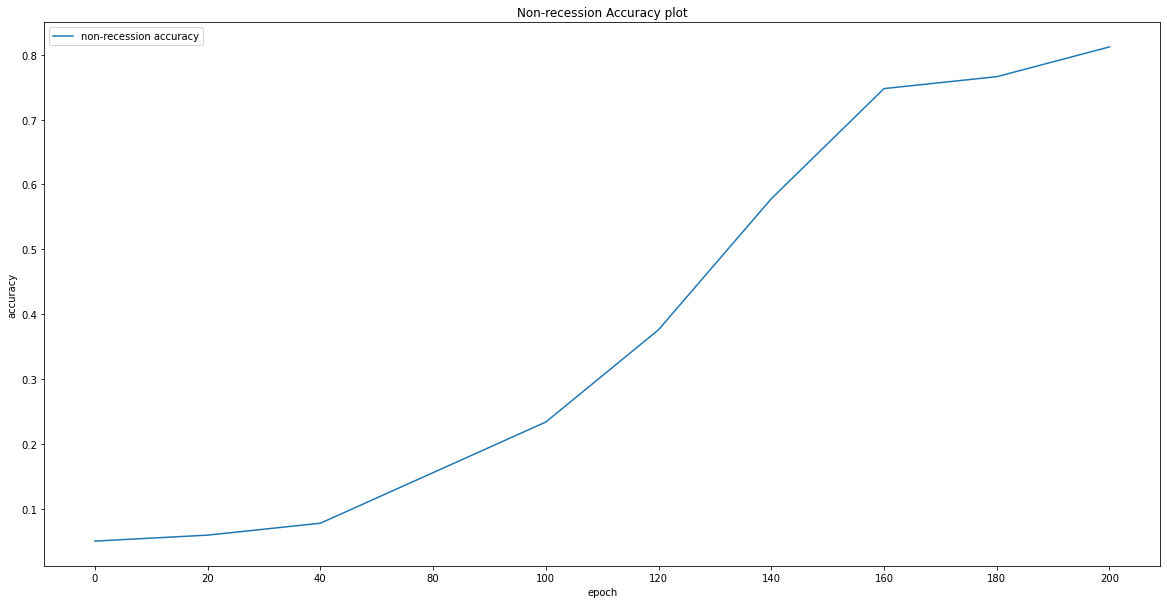

In [229]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

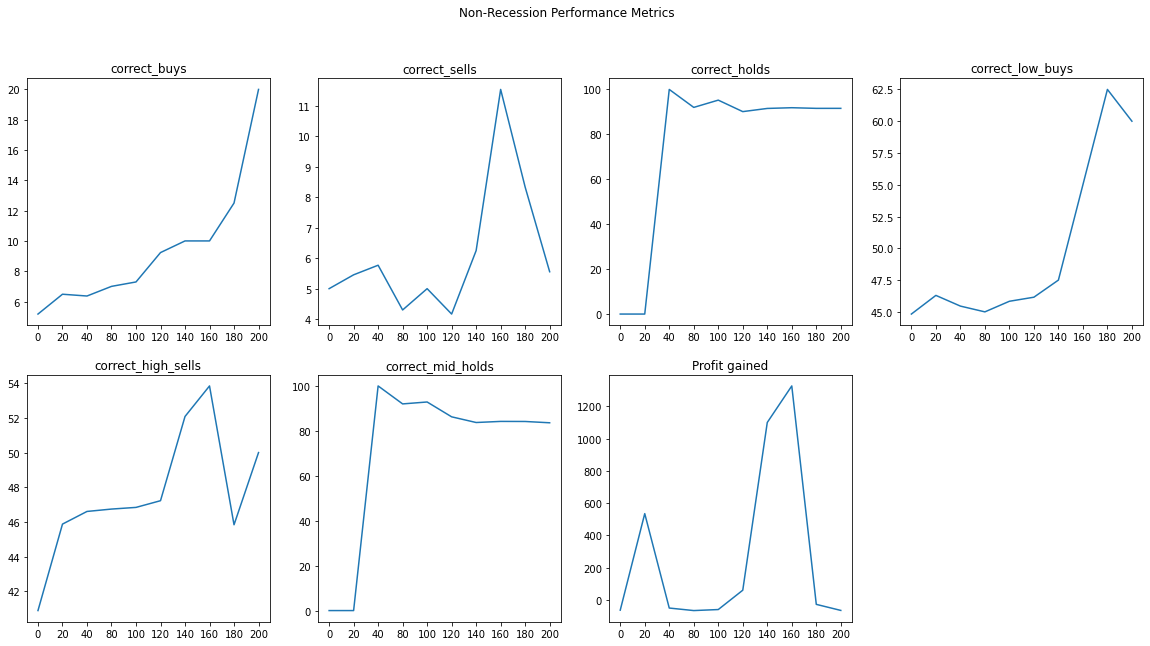

In [230]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

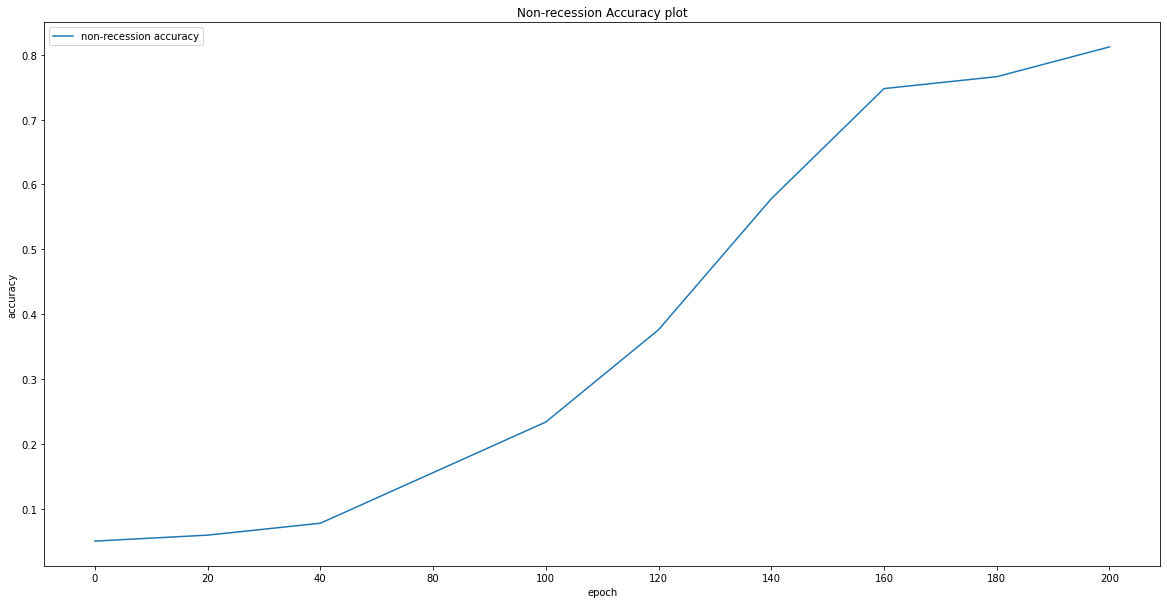

In [231]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

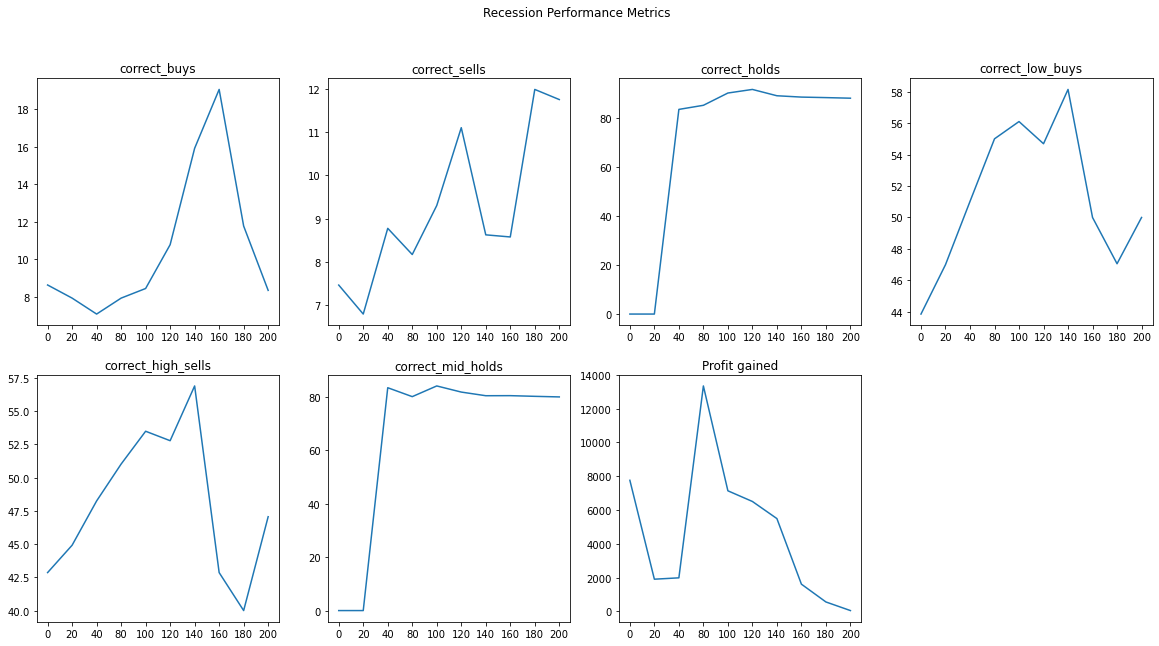

In [232]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### With Support Stock Data

In [233]:
nr_test_sets = ['KR']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/WMT_data_test.csv")
    df2.set_index('Date', inplace=True)
    print(df2.head())
    
    df['support'] = df2['previous_1d']
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    support_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    data_15_support = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            support_data.append(data_15_support_arr)
            labels.append(i[4])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]
            data_15_support = data_15_support[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    support_data = np.array(support_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        n = support_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)
        ax.plot(n)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    29.430000  28.387007  -4.858258  41061300.0     2.0
2019-01-23    29.320000  28.530544  -9.311725  36484100.0     2.0
2019-01-24    29.240000  28.639691 -14.919380  31104500.0     2.0
2019-01-25    28.709999  28.650508 -38.135648  21525300.0     2.0
2019-01-28    28.120001  28.568891 -63.135567  13527400.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


In [234]:
r_test_sets = ['KR']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/WMT_data_test2.csv")
    df2.set_index('Date', inplace=True)
    df['support'] = df2['previous_1d']
    
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    support_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    data_15_support = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            support_data.append(data_15_support_arr)
            labels.append(i[4])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]
            data_15_support = data_15_support[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    support_data = np.array(support_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    28.410000  28.475794 -65.217413  9500700.0     2.0
2020-01-23    28.370001  28.459518 -68.695589  4678900.0     2.0
2020-01-24    28.440001  28.456515 -52.222168  8638500.0     2.0
2020-01-27    28.190001  28.415513 -79.999958  3996300.0     2.0
2020-01-28    28.330000  28.402357 -50.434793  8238000.0     2.0


### training Data

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2000-01-21      8.68750  9.252111 -93.750000  -7835000.0     2.0
2000-01-24      8.40625  9.121979 -96.428571 -15986000.0     2.0
2000-01-25      8.15625  8.973405 -93.939394 -27586200.0     1.0
2000-01-26      8.06250  8.833266 -92.857143 -35302800.0     2.0
2000-01-27      8.25000  8.743533 -83.076923 -22065800.0     2.0


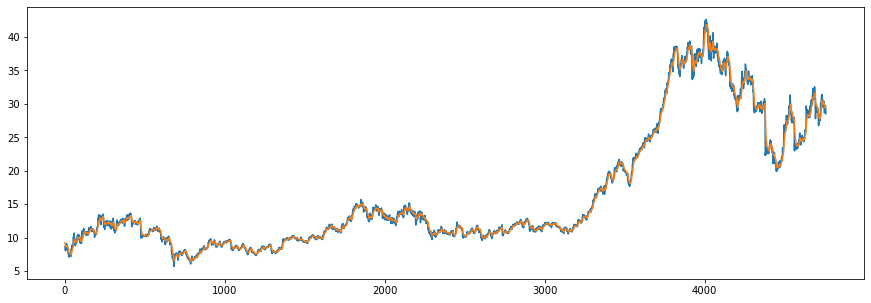

(4745, 64, 64, 1)

In [235]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 6/initial_indicators/KR_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

df2 = pd.read_csv("variation 6/initial_indicators/WMT_data.csv")
df2.set_index('Date', inplace=True)
df['support'] = df2['previous_1d']

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    n = support_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)
    ax.plot(n)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

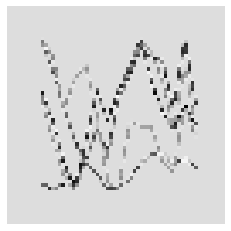

In [236]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [237]:
X = X/255

In [238]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [239]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [240]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [241]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [242]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('KR')]
    y = nr_test_data['{}_y'.format('KR')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('KR'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_non_recession.csv'.format(experiment,'KR')):
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'KR'))
    else:
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'KR'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('KR')]
    y = r_test_data['{}_y'.format('KR')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('KR'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_recession.csv'.format(experiment,'KR')):
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'KR'))
    else:
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'KR'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.3565891472868215, 1: 7.3565891472868215, 2: 0.36655079181151023}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2403 - accuracy: 0.3683 - mse: 1.6356 - weighted_accuracy: 0.3265 - weighted_mse: 1.6529 - val_loss: 0.2183 - val_accuracy: 0.0464 - val_mse: 0.7636 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.7636
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2057 - accuracy: 0.3714 - mse: 1.1878 - weighted_accuracy: 0.3424 - weighted_mse: 1.1948 - val_loss: 0.2007 - val_accuracy: 0.0632 - val_mse: 0.9773 - val_weighted_accuracy: 0.0632 - val_weighted_mse: 0.9773
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2046 - accuracy: 0.3138 - mse: 1.2069 - weighted_accuracy: 0.3305 - weighted_mse: 1.1846 - val_loss: 0.2117 - val_accuracy: 0.0485 - val_mse: 0.9683 - val_weighted_accuracy: 0.0485 - val_weighted_mse: 0.9683
Epoch 4/20
30/30 [==============================] - 

7/7 [==============================] - 0s 3ms/step - loss: 0.2039 - accuracy: 0.0639 - mse: 0.9193 - weighted_accuracy: 0.0639 - weighted_mse: 0.9193
Test loss: 0.203903466463089
Test accuracy: 0.06392694264650345


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 8
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 78
actual holds but predicted sell: 115
actual predicted holds: 0
Percentage buys correct: 5.747126436781609%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 0%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 47.674418604651166%
Percentage high sells correct: 43.18181818181818%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.05849886561184036
Shares owned at the moment: 1704
Cash capital at the moment: $0.04380731316693698


Price increase from previously boug

30/30 [==============================] - 0s 9ms/step - loss: 0.1988 - accuracy: 0.2518 - mse: 1.2022 - weighted_accuracy: 0.3851 - weighted_mse: 1.1760 - val_loss: 0.1974 - val_accuracy: 0.0685 - val_mse: 0.9588 - val_weighted_accuracy: 0.0685 - val_weighted_mse: 0.9588
Epoch 11/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1984 - accuracy: 0.3169 - mse: 1.1958 - weighted_accuracy: 0.3592 - weighted_mse: 1.1858 - val_loss: 0.1991 - val_accuracy: 0.0664 - val_mse: 0.9544 - val_weighted_accuracy: 0.0664 - val_weighted_mse: 0.9544
Epoch 12/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1936 - accuracy: 0.2497 - mse: 1.2092 - weighted_accuracy: 0.4083 - weighted_mse: 1.1841 - val_loss: 0.1994 - val_accuracy: 0.0685 - val_mse: 1.0127 - val_weighted_accuracy: 0.0685 - val_weighted_mse: 1.0127
Epoch 13/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1929 - accuracy: 0.2929 - mse: 1.1964 - weighted_accuracy: 0.4407 - weighted_mse: 1.20

7/7 [==============================] - 0s 3ms/step - loss: 0.1982 - accuracy: 0.0776 - mse: 0.9652 - weighted_accuracy: 0.0776 - weighted_mse: 0.9652
Test loss: 0.1982070505619049
Test accuracy: 0.077625572681427


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 97
actual holds but predicted sell: 96
actual predicted holds: 0
Percentage buys correct: 8.849557522123893%
Percentage sells correct: 6.60377358490566%
Percentage holds correct: 0%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 48.214285714285715%
Percentage high sells correct: 46.22641509433962%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.05849886561184036
Shares owned at the moment: 1704
Cash capital at the moment: $0.04380731316693698


Price increase from previously bought

30/30 [==============================] - 0s 12ms/step - loss: 0.1866 - accuracy: 0.1802 - mse: 1.2490 - weighted_accuracy: 0.4822 - weighted_mse: 1.2244 - val_loss: 0.1974 - val_accuracy: 0.0717 - val_mse: 0.9969 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 0.9969
Epoch 8/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1877 - accuracy: 0.1797 - mse: 1.2168 - weighted_accuracy: 0.4618 - weighted_mse: 1.1934 - val_loss: 0.1967 - val_accuracy: 0.0717 - val_mse: 1.0403 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 1.0403
Epoch 9/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1904 - accuracy: 0.1889 - mse: 1.2344 - weighted_accuracy: 0.4025 - weighted_mse: 1.1940 - val_loss: 0.1944 - val_accuracy: 0.0685 - val_mse: 1.1051 - val_weighted_accuracy: 0.0685 - val_weighted_mse: 1.1051
Epoch 10/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1874 - accuracy: 0.1665 - mse: 1.2259 - weighted_accuracy: 0.4588 - weighted_mse: 1.19

7/7 [==============================] - 0s 3ms/step - loss: 0.1969 - accuracy: 0.0822 - mse: 1.0769 - weighted_accuracy: 0.0822 - weighted_mse: 1.0769
Test loss: 0.1969425529241562
Test accuracy: 0.08219178020954132


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 103
actual holds but predicted sell: 90
actual predicted holds: 0
Percentage buys correct: 8.474576271186441%
Percentage sells correct: 7.920792079207921%
Percentage holds correct: 0%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 48.717948717948715%
Percentage high sells correct: 46.53465346534654%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.04348719135799172
Shares owned at the moment: 2293
Cash capital at the moment: $0.009650859219320296


Price increase from previously b

Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1791 - accuracy: 0.1623 - mse: 1.2897 - weighted_accuracy: 0.5088 - weighted_mse: 1.2399 - val_loss: 0.1957 - val_accuracy: 0.0769 - val_mse: 1.1416 - val_weighted_accuracy: 0.0769 - val_weighted_mse: 1.1416
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1792 - accuracy: 0.1575 - mse: 1.2532 - weighted_accuracy: 0.5015 - weighted_mse: 1.2200 - val_loss: 0.1976 - val_accuracy: 0.0769 - val_mse: 1.0924 - val_weighted_accuracy: 0.0769 - val_weighted_mse: 1.0924
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1768 - accuracy: 0.1636 - mse: 1.2972 - weighted_accuracy: 0.5185 - weighted_mse: 1.2421 - val_loss: 0.1979 - val_accuracy: 0.0759 - val_mse: 1.0720 - val_weighted_accuracy: 0.0759 - val_weighted_mse: 1.0720
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1748 - accuracy: 0.1657 - mse: 1.3048 - weighted_accuracy: 0.5358 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1987 - accuracy: 0.1370 - mse: 1.2924 - weighted_accuracy: 0.1370 - weighted_mse: 1.2924
Test loss: 0.19873668253421783
Test accuracy: 0.13698630034923553


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 5
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 84
actual holds but predicted sell: 96
actual predicted holds: 13
Percentage buys correct: 8.421052631578947%
Percentage sells correct: 8.181818181818182%
Percentage holds correct: 92.85714285714286%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 51.06382978723404%
Percentage high sells correct: 49.09090909090909%
Percentage mid holds correct: 78.57142857142857%


Capital: 100
Share price: $0.21438787199088805
Shares owned at the moment: 465
Cash capital at the moment: $0.0354910329287037


Pric

Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1625 - accuracy: 0.1699 - mse: 1.3790 - weighted_accuracy: 0.5742 - weighted_mse: 1.3342 - val_loss: 0.1977 - val_accuracy: 0.1243 - val_mse: 1.2320 - val_weighted_accuracy: 0.1243 - val_weighted_mse: 1.2320
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1675 - accuracy: 0.1686 - mse: 1.3394 - weighted_accuracy: 0.5387 - weighted_mse: 1.2817 - val_loss: 0.1970 - val_accuracy: 0.1191 - val_mse: 1.2794 - val_weighted_accuracy: 0.1191 - val_weighted_mse: 1.2794
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1622 - accuracy: 0.1765 - mse: 1.3673 - weighted_accuracy: 0.5877 - weighted_mse: 1.3256 - val_loss: 0.1972 - val_accuracy: 0.1328 - val_mse: 1.2051 - val_weighted_accuracy: 0.1328 - val_weighted_mse: 1.2051
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1622 - accuracy: 0.1770 - mse: 1.3780 - weighted_accuracy: 0.5731 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1984 - accuracy: 0.2100 - mse: 1.3559 - weighted_accuracy: 0.2100 - weighted_mse: 1.3559
Test loss: 0.19836308062076569
Test accuracy: 0.21004566550254822


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 5
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 75
actual holds but predicted sell: 88
actual predicted holds: 30
Percentage buys correct: 8.235294117647058%
Percentage sells correct: 8.823529411764707%
Percentage holds correct: 93.75%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 53.57142857142857%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.21438787199088805
Shares owned at the moment: 465
Cash capital at the moment: $0.0354910329287037


Price increase from previously bought: -9

30/30 [==============================] - 0s 13ms/step - loss: 0.1523 - accuracy: 0.2231 - mse: 1.4617 - weighted_accuracy: 0.6324 - weighted_mse: 1.4085 - val_loss: 0.1965 - val_accuracy: 0.1981 - val_mse: 1.4038 - val_weighted_accuracy: 0.1981 - val_weighted_mse: 1.4038
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1524 - accuracy: 0.2181 - mse: 1.5157 - weighted_accuracy: 0.6084 - weighted_mse: 1.4549 - val_loss: 0.1966 - val_accuracy: 0.1802 - val_mse: 1.3528 - val_weighted_accuracy: 0.1802 - val_weighted_mse: 1.3528
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1498 - accuracy: 0.2268 - mse: 1.4907 - weighted_accuracy: 0.6521 - weighted_mse: 1.4658 - val_loss: 0.1965 - val_accuracy: 0.1876 - val_mse: 1.3546 - val_weighted_accuracy: 0.1876 - val_weighted_mse: 1.3546
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1501 - accuracy: 0.2244 - mse: 1.4770 - weighted_accuracy: 0.6181 - weighted_mse: 1.453

7/7 [==============================] - 0s 3ms/step - loss: 0.1916 - accuracy: 0.3059 - mse: 1.5176 - weighted_accuracy: 0.3059 - weighted_mse: 1.5176
Test loss: 0.1916157454252243
Test accuracy: 0.3059360682964325


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 3
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 61
actual holds but predicted sell: 81
actual predicted holds: 51
Percentage buys correct: 9.859154929577464%
Percentage sells correct: 9.782608695652174%
Percentage holds correct: 91.07142857142857%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 53.26086956521739%
Percentage mid holds correct: 80.35714285714286%


Capital: 100
Share price: $0.21438787199088805
Shares owned at the moment: 465
Cash capital at the moment: $0.0354910329287037


Price

30/30 [==============================] - 0s 13ms/step - loss: 0.1352 - accuracy: 0.3143 - mse: 1.7062 - weighted_accuracy: 0.6879 - weighted_mse: 1.8095 - val_loss: 0.1901 - val_accuracy: 0.2792 - val_mse: 1.4645 - val_weighted_accuracy: 0.2792 - val_weighted_mse: 1.4645
Epoch 5/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1348 - accuracy: 0.3072 - mse: 1.6985 - weighted_accuracy: 0.7074 - weighted_mse: 1.7948 - val_loss: 0.1876 - val_accuracy: 0.2961 - val_mse: 1.4037 - val_weighted_accuracy: 0.2961 - val_weighted_mse: 1.4037
Epoch 6/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1354 - accuracy: 0.3201 - mse: 1.6409 - weighted_accuracy: 0.6900 - weighted_mse: 1.7581 - val_loss: 0.1886 - val_accuracy: 0.3119 - val_mse: 1.4721 - val_weighted_accuracy: 0.3119 - val_weighted_mse: 1.4721
Epoch 7/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1367 - accuracy: 0.3203 - mse: 1.6919 - weighted_accuracy: 0.6901 - weighted_mse: 1.809

7/7 [==============================] - 0s 3ms/step - loss: 0.1830 - accuracy: 0.3607 - mse: 1.6079 - weighted_accuracy: 0.3607 - weighted_mse: 1.6079
Test loss: 0.1829940229654312
Test accuracy: 0.3607305884361267


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 5
actual holds but predicted buy: 46
actual holds but predicted sell: 82
actual predicted holds: 65
Percentage buys correct: 12.962962962962964%
Percentage sells correct: 7.777777777777778%
Percentage holds correct: 86.66666666666667%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 58.490566037735846%
Percentage high sells correct: 51.111111111111114%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.21438787199088805
Shares owned at the moment: 465
Cash capital at the moment: $0.0354910329287037


Price increase f

30/30 [==============================] - 0s 12ms/step - loss: 0.1262 - accuracy: 0.4062 - mse: 1.8448 - weighted_accuracy: 0.7474 - weighted_mse: 2.1163 - val_loss: 0.1781 - val_accuracy: 0.4415 - val_mse: 1.6593 - val_weighted_accuracy: 0.4415 - val_weighted_mse: 1.6593
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1254 - accuracy: 0.4065 - mse: 1.9244 - weighted_accuracy: 0.7456 - weighted_mse: 2.2157 - val_loss: 0.1781 - val_accuracy: 0.4457 - val_mse: 1.6776 - val_weighted_accuracy: 0.4457 - val_weighted_mse: 1.6776
Epoch 8/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1250 - accuracy: 0.4260 - mse: 1.8699 - weighted_accuracy: 0.7472 - weighted_mse: 2.1419 - val_loss: 0.1764 - val_accuracy: 0.4447 - val_mse: 1.6335 - val_weighted_accuracy: 0.4447 - val_weighted_mse: 1.6335
Epoch 9/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1229 - accuracy: 0.4294 - mse: 1.9350 - weighted_accuracy: 0.7540 - weighted_mse: 2.212

7/7 [==============================] - 0s 3ms/step - loss: 0.1736 - accuracy: 0.4932 - mse: 1.8004 - weighted_accuracy: 0.4932 - weighted_mse: 1.8004
Test loss: 0.17362302541732788
Test accuracy: 0.4931506812572479


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 5
actual holds but predicted buy: 33
actual holds but predicted sell: 65
actual predicted holds: 95
Percentage buys correct: 15.0%
Percentage sells correct: 9.58904109589041%
Percentage holds correct: 89.62264150943396%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 55.0%
Percentage high sells correct: 53.42465753424658%
Percentage mid holds correct: 82.85714285714286%


Capital: 100
Share price: $0.03193980045076094
Shares owned at the moment: 3122
Cash capital at the moment: $0.009723835954332571


Price increase from previousl

30/30 [==============================] - 0s 12ms/step - loss: 0.1115 - accuracy: 0.5345 - mse: 2.2331 - weighted_accuracy: 0.7889 - weighted_mse: 2.8316 - val_loss: 0.1574 - val_accuracy: 0.6133 - val_mse: 1.8687 - val_weighted_accuracy: 0.6133 - val_weighted_mse: 1.8687
Epoch 11/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1194 - accuracy: 0.5403 - mse: 2.1612 - weighted_accuracy: 0.7689 - weighted_mse: 2.6704 - val_loss: 0.1609 - val_accuracy: 0.5659 - val_mse: 1.8093 - val_weighted_accuracy: 0.5659 - val_weighted_mse: 1.8093
Epoch 12/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1177 - accuracy: 0.5269 - mse: 2.1342 - weighted_accuracy: 0.7713 - weighted_mse: 2.6631 - val_loss: 0.1518 - val_accuracy: 0.6375 - val_mse: 1.9274 - val_weighted_accuracy: 0.6375 - val_weighted_mse: 1.9274
Epoch 13/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1161 - accuracy: 0.5535 - mse: 2.2276 - weighted_accuracy: 0.7811 - weighted_mse: 2.

Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1058 - accuracy: 0.6019 - mse: 2.4232 - weighted_accuracy: 0.8136 - weighted_mse: 3.2452 - val_loss: 0.1524 - val_accuracy: 0.6565 - val_mse: 2.0344 - val_weighted_accuracy: 0.6565 - val_weighted_mse: 2.0344
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1095 - accuracy: 0.5688 - mse: 2.4143 - weighted_accuracy: 0.7848 - weighted_mse: 3.1592 - val_loss: 0.1544 - val_accuracy: 0.6228 - val_mse: 1.9515 - val_weighted_accuracy: 0.6228 - val_weighted_mse: 1.9515
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1082 - accuracy: 0.5917 - mse: 2.3912 - weighted_accuracy: 0.8006 - weighted_mse: 3.2272 - val_loss: 0.1467 - val_accuracy: 0.6733 - val_mse: 1.9720 - val_weighted_accuracy: 0.6733 - val_weighted_mse: 1.9720
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1082 - accuracy: 0.5904 - mse: 2.4178 - weighted_accuracy: 0.8075 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.6484 - mse: 2.0407 - weighted_accuracy: 0.6484 - weighted_mse: 2.0407
Test loss: 0.14785893261432648
Test accuracy: 0.6484017968177795


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 8
actual holds but predicted buy: 19
actual holds but predicted sell: 42
actual predicted holds: 132
Percentage buys correct: 20.833333333333332%
Percentage sells correct: 10.416666666666666%
Percentage holds correct: 89.79591836734694%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 54.166666666666664%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 82.87671232876713%


Capital: 100
Share price: $0.03193980045076094
Shares owned at the moment: 3122
Cash capital at the moment: $0.009723835954332571

In [243]:
df = nr_log_hist['epochs_logs']
df.head(20)

Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.055046      4.761905       5.970149       0.000000   
1       0.059633      6.140351       5.769231       0.000000   
2       0.073394      6.611570       6.315789     100.000000   
3       0.119266      7.000000       5.769231      92.857143   
4       0.215596      6.521739       6.741573      94.594595   
5       0.362385      8.571429       6.756757      91.891892   
6       0.431193     11.320755       4.225352      90.425532   
7       0.545872     14.705882       4.838710      90.983607   
8       0.697248     11.111111       9.375000      91.823899   
9       0.733945     10.526316      10.000000      91.715976   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         47.619048           43.609023           0.000000     -21.940622   
1         46.491228           46.601942           0.000000     930.118072   
2         46.280992           46.808511         100.000000     -58.885084   
3         46.000000           46.601942          92.857143     -37.992114   
4         44.565217           48.863636          94.594595     -69.822100   
5         51.428571           46.575342          86.486486     -74.448975   
6         50.943396           45.714286          86.170213     -69.729169   
7         58.823529           47.540984          84.426230     216.887704   
8         59.259259           53.125000          84.177215     166.812771   
9         68.421053           56.666667          84.523810     143.417157   

   buy_n_hold profit  
0           10.80016  
1           10.80016  
2           10.80016  
3           10.80016  
4           10.80016  
5           10.80016  
6           10.80016  
7           10.80016  
8           10.80016  
9           10.80016

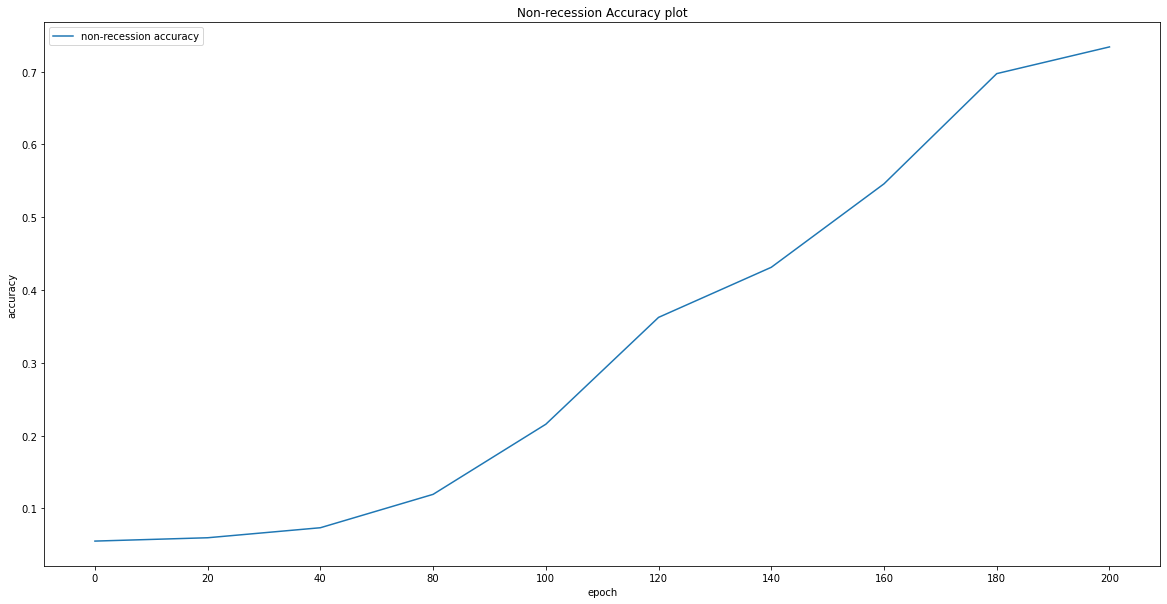

In [244]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

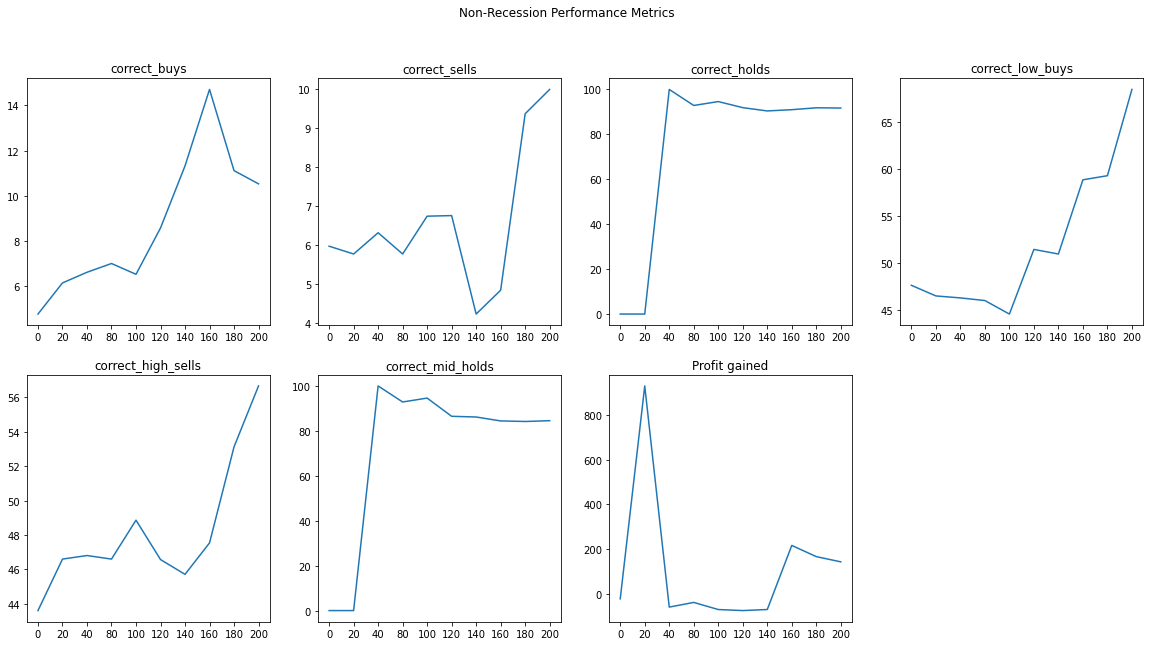

In [245]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

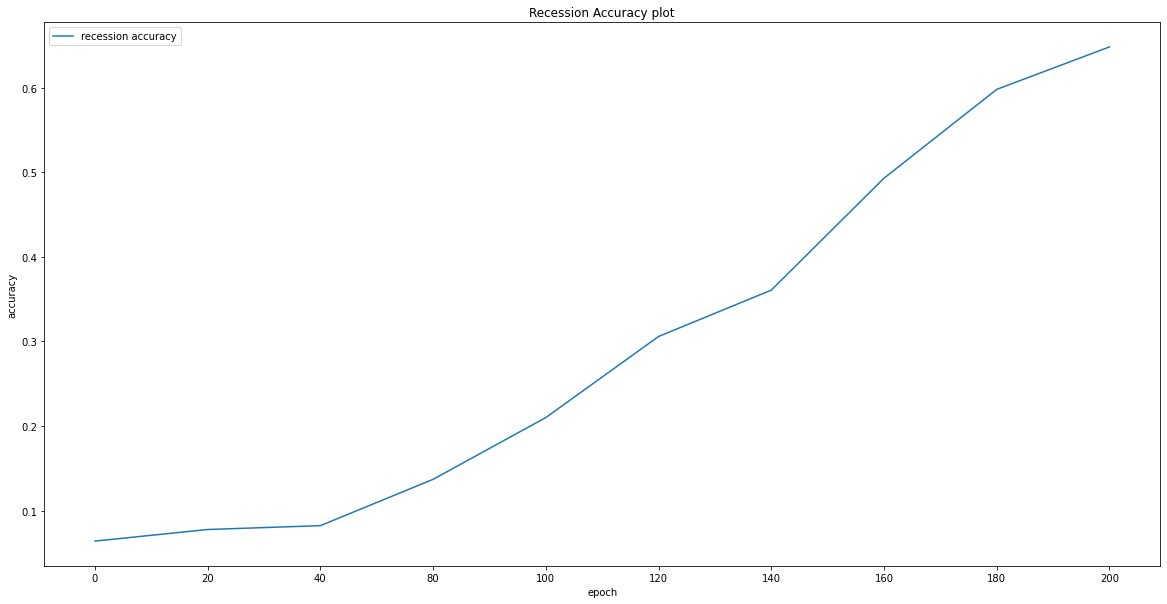

In [246]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()


Text(0.5, 1.0, 'Profit gained')

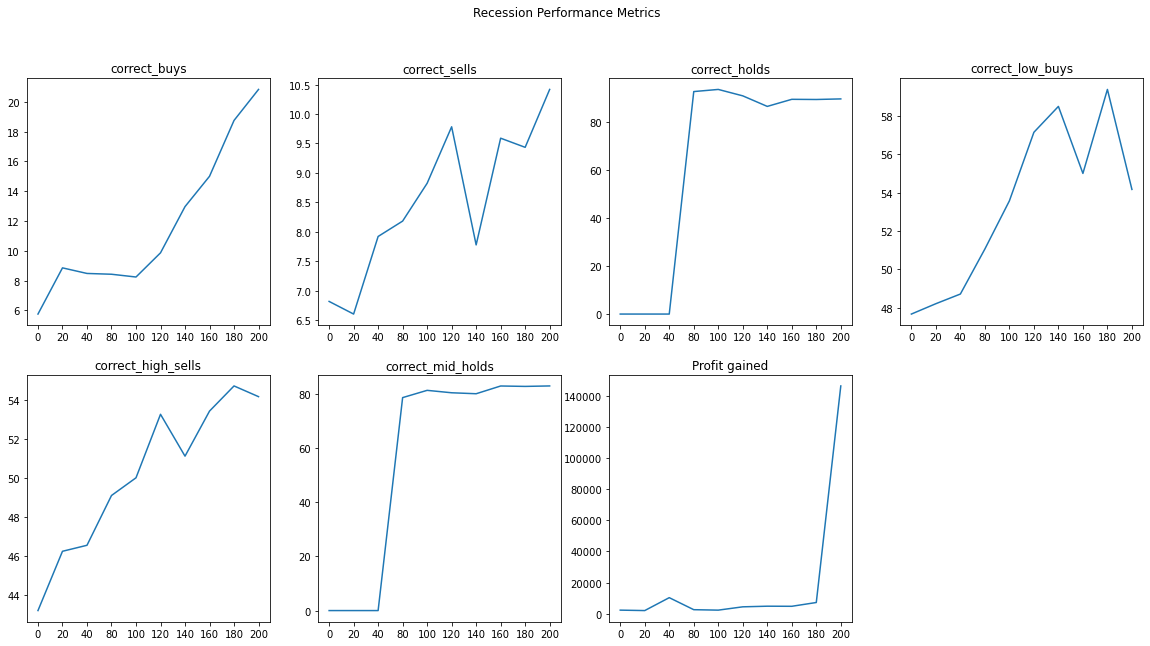

In [247]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

## Manulife Financial Corporation

### No support Stock Price

In [99]:
nr_test_sets = ['MFC']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        16.10  15.369379  -4.347841  12991200.0     2.0
2019-01-23        15.75  15.427936 -19.565241  11195700.0     2.0
2019-01-24        15.79  15.483638 -19.902947  12310800.0     2.0
2019-01-25        15.63  15.506155 -34.131754  10454700.0     2.0
2019-01-28        15.75  15.543670 -30.405447  11863600.0     2.0


In [100]:
r_test_sets = ['MFC']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    20.620001  20.787224 -56.481365  5587900.0     2.0
2020-01-23    20.760000  20.783036 -48.453572  7034300.0     2.0
2020-01-24    20.799999  20.785645 -44.329960  8383300.0     2.0
2020-01-27    20.650000  20.764777 -59.793849  5159000.0     2.0
2020-01-28    20.030001  20.651734 -87.591226  2998800.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21      6.09375  6.133837 -56.250000  1982400.0     2.0
2000-01-24      6.06250  6.122862 -60.000000  1705200.0     2.0
2000-01-25      5.96875  6.099153 -80.000000   909600.0     2.0
2000-01-26      6.00000  6.083898 -73.333333  1179600.0     2.0
2000-01-27      5.96875  6.066183 -80.000000   783000.0     2.0


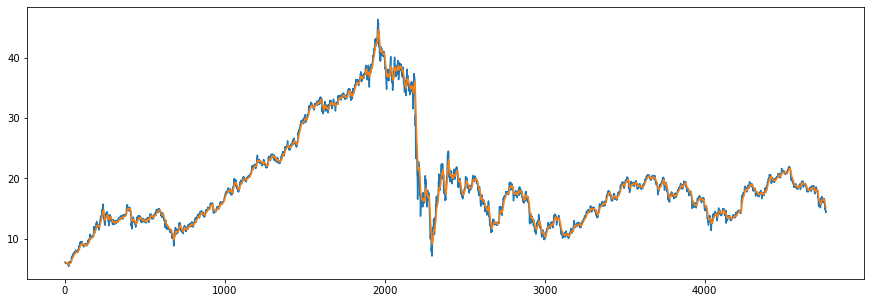

(4745, 64, 64, 1)

In [101]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 6/initial_indicators/MFC_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

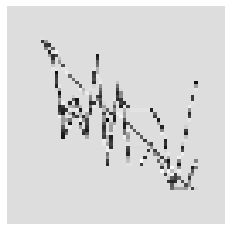

In [102]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [103]:
X = X/255

In [104]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [105]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [106]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [107]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [108]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('MFC')]
    y = nr_test_data['{}_y'.format('MFC')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('MFC'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_non_recession.csv'.format(experiment,'MFC')):
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'MFC'))
    else:
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'MFC'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('MFC')]
    y = r_test_data['{}_y'.format('MFC')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('MFC'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_recession.csv'.format(experiment,'MFC')):
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'MFC'))
    else:
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'MFC'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 6.9523809523809526, 1: 7.3996101364522415, 2: 0.3675089553683803}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2469 - accuracy: 0.3501 - mse: 1.6065 - weighted_accuracy: 0.3019 - weighted_mse: 1.7280 - val_loss: 0.2252 - val_accuracy: 0.0453 - val_mse: 0.8594 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.8594
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2065 - accuracy: 0.2745 - mse: 1.1804 - weighted_accuracy: 0.3390 - weighted_mse: 1.1879 - val_loss: 0.1970 - val_accuracy: 0.5985 - val_mse: 0.8656 - val_weighted_accuracy: 0.5985 - val_weighted_mse: 0.8656
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2037 - accuracy: 0.3791 - mse: 1.1501 - weighted_accuracy: 0.3560 - weighted_mse: 1.1677 - val_loss: 0.2062 - val_accuracy: 0.0527 - val_mse: 0.8562 - val_weighted_accuracy: 0.0527 - val_weighted_mse: 0.8562
Epoch 4/20
30/30 [==============================] - 0

0         9944.02854  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.2019 - accuracy: 0.0685 - mse: 0.9864 - weighted_accuracy: 0.0685 - weighted_mse: 0.9864
Test loss: 0.20185941457748413
Test accuracy: 0.06849315017461777


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 113
actual holds but predicted sell: 87
actual predicted holds: 0
Percentage buys correct: 4.958677685950414%
Percentage sells correct: 9.183673469387756%
Percentage holds correct: 0%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 47.5%
Percentage high sells correct: 46.93877551020408%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.965791333014149
Shares owned at the moment: 103
Cash capital at the moment: $0.24993230446639814


Price inc

30/30 [==============================] - 0s 10ms/step - loss: 0.1889 - accuracy: 0.2418 - mse: 1.2708 - weighted_accuracy: 0.4841 - weighted_mse: 1.2306 - val_loss: 0.1947 - val_accuracy: 0.1201 - val_mse: 1.0963 - val_weighted_accuracy: 0.1201 - val_weighted_mse: 1.0963
Epoch 13/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1883 - accuracy: 0.2273 - mse: 1.2751 - weighted_accuracy: 0.4551 - weighted_mse: 1.2178 - val_loss: 0.1977 - val_accuracy: 0.0822 - val_mse: 1.0389 - val_weighted_accuracy: 0.0822 - val_weighted_mse: 1.0389
Epoch 14/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1866 - accuracy: 0.2779 - mse: 1.2794 - weighted_accuracy: 0.4781 - weighted_mse: 1.2437 - val_loss: 0.1993 - val_accuracy: 0.0790 - val_mse: 0.9868 - val_weighted_accuracy: 0.0790 - val_weighted_mse: 0.9868
Epoch 15/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1846 - accuracy: 0.2210 - mse: 1.2682 - weighted_accuracy: 0.4971 - weighted_mse: 1.

7/7 [==============================] - 0s 2ms/step - loss: 0.1944 - accuracy: 0.1279 - mse: 1.0468 - weighted_accuracy: 0.1279 - weighted_mse: 1.0468
Test loss: 0.194403275847435
Test accuracy: 0.1278538852930069


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 98
actual holds but predicted sell: 89
actual predicted holds: 13
Percentage buys correct: 5.714285714285714%
Percentage sells correct: 9.0%
Percentage holds correct: 92.85714285714286%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 52.88461538461539%
Percentage high sells correct: 49.0%
Percentage mid holds correct: 92.85714285714286%


Capital: 100
Share price: $0.965791333014149
Shares owned at the moment: 103
Cash capital at the moment: $0.24993230446639814


Price increase from previously bough

30/30 [==============================] - 0s 10ms/step - loss: 0.1768 - accuracy: 0.2279 - mse: 1.3384 - weighted_accuracy: 0.5264 - weighted_mse: 1.3048 - val_loss: 0.1905 - val_accuracy: 0.1981 - val_mse: 1.1083 - val_weighted_accuracy: 0.1981 - val_weighted_mse: 1.1083
Epoch 8/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1751 - accuracy: 0.2505 - mse: 1.3366 - weighted_accuracy: 0.5426 - weighted_mse: 1.3075 - val_loss: 0.1963 - val_accuracy: 0.1359 - val_mse: 1.0404 - val_weighted_accuracy: 0.1359 - val_weighted_mse: 1.0404
Epoch 9/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1785 - accuracy: 0.2229 - mse: 1.3589 - weighted_accuracy: 0.5195 - weighted_mse: 1.2895 - val_loss: 0.1915 - val_accuracy: 0.1781 - val_mse: 1.0854 - val_weighted_accuracy: 0.1781 - val_weighted_mse: 1.0854
Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1749 - accuracy: 0.2545 - mse: 1.3600 - weighted_accuracy: 0.5224 - weighted_mse: 1.3275

7/7 [==============================] - 0s 3ms/step - loss: 0.1971 - accuracy: 0.1370 - mse: 1.1400 - weighted_accuracy: 0.1370 - weighted_mse: 1.1400
Test loss: 0.19707712531089783
Test accuracy: 0.13698630034923553


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 95
actual holds but predicted sell: 91
actual predicted holds: 14
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 9.70873786407767%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 52.475247524752476%
Percentage high sells correct: 49.51456310679612%
Percentage mid holds correct: 92.85714285714286%


Capital: 100
Share price: $0.965791333014149
Shares owned at the moment: 103
Cash capital at the moment: $0.24993230446639814


Price increase fr

30/30 [==============================] - 0s 10ms/step - loss: 0.1643 - accuracy: 0.2724 - mse: 1.4397 - weighted_accuracy: 0.5941 - weighted_mse: 1.3732 - val_loss: 0.1962 - val_accuracy: 0.1602 - val_mse: 1.1682 - val_weighted_accuracy: 0.1602 - val_weighted_mse: 1.1682
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1642 - accuracy: 0.2637 - mse: 1.4504 - weighted_accuracy: 0.5891 - weighted_mse: 1.4073 - val_loss: 0.1832 - val_accuracy: 0.3130 - val_mse: 1.1445 - val_weighted_accuracy: 0.3130 - val_weighted_mse: 1.1445
Epoch 8/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1668 - accuracy: 0.2919 - mse: 1.4175 - weighted_accuracy: 0.5690 - weighted_mse: 1.3663 - val_loss: 0.1957 - val_accuracy: 0.1380 - val_mse: 1.1565 - val_weighted_accuracy: 0.1380 - val_weighted_mse: 1.1565
Epoch 9/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1614 - accuracy: 0.2653 - mse: 1.4517 - weighted_accuracy: 0.6135 - weighted_mse: 1.407

7/7 [==============================] - 0s 3ms/step - loss: 0.1904 - accuracy: 0.2146 - mse: 1.2280 - weighted_accuracy: 0.2146 - weighted_mse: 1.2280
Test loss: 0.19040298461914062
Test accuracy: 0.21461187303066254


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 87
actual holds but predicted sell: 81
actual predicted holds: 32
Percentage buys correct: 5.376344086021505%
Percentage sells correct: 10.75268817204301%
Percentage holds correct: 96.96969696969697%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 52.17391304347826%
Percentage high sells correct: 49.46236559139785%
Percentage mid holds correct: 93.93939393939394%


Capital: 100
Share price: $0.965791333014149
Shares owned at the moment: 103
Cash capital at the moment: $0.24993230446639814


Price

Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1533 - accuracy: 0.3045 - mse: 1.5085 - weighted_accuracy: 0.6315 - weighted_mse: 1.4579 - val_loss: 0.1840 - val_accuracy: 0.2950 - val_mse: 1.3011 - val_weighted_accuracy: 0.2950 - val_weighted_mse: 1.3011
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1482 - accuracy: 0.3156 - mse: 1.6094 - weighted_accuracy: 0.6334 - weighted_mse: 1.6200 - val_loss: 0.1877 - val_accuracy: 0.2529 - val_mse: 1.3262 - val_weighted_accuracy: 0.2529 - val_weighted_mse: 1.3262
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1509 - accuracy: 0.3138 - mse: 1.5111 - weighted_accuracy: 0.6458 - weighted_mse: 1.4755 - val_loss: 0.1930 - val_accuracy: 0.2171 - val_mse: 1.2597 - val_weighted_accuracy: 0.2171 - val_weighted_mse: 1.2597
Epoch 9/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1463 - accuracy: 0.3022 - mse: 1.5897 - weighted_accuracy: 0.6412 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1866 - accuracy: 0.3242 - mse: 1.3571 - weighted_accuracy: 0.3242 - weighted_mse: 1.3571
Test loss: 0.18660810589790344
Test accuracy: 0.32420089840888977


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 74
actual holds but predicted sell: 67
actual predicted holds: 59
Percentage buys correct: 5.063291139240507%
Percentage sells correct: 10.38961038961039%
Percentage holds correct: 93.65079365079364%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 51.282051282051285%
Percentage high sells correct: 50.64935064935065%
Percentage mid holds correct: 90.47619047619048%


Capital: 100
Share price: $0.965791333014149
Shares owned at the moment: 103
Cash capital at the moment: $0.24993230446639814


Price

Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1377 - accuracy: 0.3967 - mse: 1.6889 - weighted_accuracy: 0.6752 - weighted_mse: 1.7344 - val_loss: 0.1728 - val_accuracy: 0.4594 - val_mse: 1.3625 - val_weighted_accuracy: 0.4594 - val_weighted_mse: 1.3625
Epoch 8/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1394 - accuracy: 0.4204 - mse: 1.6078 - weighted_accuracy: 0.6925 - weighted_mse: 1.6650 - val_loss: 0.1798 - val_accuracy: 0.3941 - val_mse: 1.4569 - val_weighted_accuracy: 0.3941 - val_weighted_mse: 1.4569
Epoch 9/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1372 - accuracy: 0.4212 - mse: 1.7174 - weighted_accuracy: 0.6993 - weighted_mse: 1.7391 - val_loss: 0.1778 - val_accuracy: 0.4341 - val_mse: 1.3645 - val_weighted_accuracy: 0.4341 - val_weighted_mse: 1.3645
Epoch 10/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1358 - accuracy: 0.4368 - mse: 1.6975 - weighted_accuracy: 0.6916 - weighte

7/7 [==============================] - 0s 3ms/step - loss: 0.1817 - accuracy: 0.4292 - mse: 1.5766 - weighted_accuracy: 0.4292 - weighted_mse: 1.5766
Test loss: 0.1816508173942566
Test accuracy: 0.4292237460613251


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 65
actual holds but predicted sell: 50
actual predicted holds: 85
Percentage buys correct: 4.3478260869565215%
Percentage sells correct: 10.344827586206897%
Percentage holds correct: 92.3913043478261%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 51.470588235294116%
Percentage high sells correct: 46.55172413793103%
Percentage mid holds correct: 86.95652173913044%


Capital: 100
Share price: $0.965791333014149
Shares owned at the moment: 103
Cash capital at the moment: $0.24993230446639814


Price 

30/30 [==============================] - 0s 10ms/step - loss: 0.1185 - accuracy: 0.5219 - mse: 1.9661 - weighted_accuracy: 0.7547 - weighted_mse: 2.2643 - val_loss: 0.1718 - val_accuracy: 0.5037 - val_mse: 1.7277 - val_weighted_accuracy: 0.5037 - val_weighted_mse: 1.7277
Epoch 11/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1193 - accuracy: 0.5229 - mse: 1.9813 - weighted_accuracy: 0.7497 - weighted_mse: 2.2111 - val_loss: 0.1641 - val_accuracy: 0.5574 - val_mse: 1.6707 - val_weighted_accuracy: 0.5574 - val_weighted_mse: 1.6707
Epoch 12/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1175 - accuracy: 0.5453 - mse: 1.9147 - weighted_accuracy: 0.7686 - weighted_mse: 2.1987 - val_loss: 0.1666 - val_accuracy: 0.5416 - val_mse: 1.8019 - val_weighted_accuracy: 0.5416 - val_weighted_mse: 1.8019
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1164 - accuracy: 0.5477 - mse: 1.9789 - weighted_accuracy: 0.7708 - weighted_mse: 2.31

Epoch 1/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1067 - accuracy: 0.5777 - mse: 2.2035 - weighted_accuracy: 0.8047 - weighted_mse: 2.7521 - val_loss: 0.1619 - val_accuracy: 0.5680 - val_mse: 1.8186 - val_weighted_accuracy: 0.5680 - val_weighted_mse: 1.8186
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1072 - accuracy: 0.5682 - mse: 2.1234 - weighted_accuracy: 0.8007 - weighted_mse: 2.5906 - val_loss: 0.1523 - val_accuracy: 0.6407 - val_mse: 1.8203 - val_weighted_accuracy: 0.6407 - val_weighted_mse: 1.8203
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1048 - accuracy: 0.5975 - mse: 2.1594 - weighted_accuracy: 0.8138 - weighted_mse: 2.6813 - val_loss: 0.1569 - val_accuracy: 0.6196 - val_mse: 1.9369 - val_weighted_accuracy: 0.6196 - val_weighted_mse: 1.9369
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1054 - accuracy: 0.5719 - mse: 2.2488 - weighted_accuracy: 0.7957 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.6347 - mse: 2.0557 - weighted_accuracy: 0.6347 - weighted_mse: 2.0557
Test loss: 0.14786873757839203
Test accuracy: 0.6347032189369202


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 36
actual holds but predicted sell: 32
actual predicted holds: 132
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 13.513513513513514%
Percentage holds correct: 91.66666666666667%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 54.054054054054056%
Percentage high sells correct: 45.945945945945944%
Percentage mid holds correct: 85.41666666666667%


Capital: 100
Share price: $0.9542971538006071
Shares owned at the moment: 104
Cash capital at the moment: $0.48016701874988144


P

30/30 [==============================] - 0s 9ms/step - loss: 0.0906 - accuracy: 0.6823 - mse: 2.4839 - weighted_accuracy: 0.8301 - weighted_mse: 3.3871 - val_loss: 0.1454 - val_accuracy: 0.6881 - val_mse: 2.1601 - val_weighted_accuracy: 0.6881 - val_weighted_mse: 2.1601
Epoch 11/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0805 - accuracy: 0.7031 - mse: 2.6548 - weighted_accuracy: 0.8591 - weighted_mse: 3.7878 - val_loss: 0.1242 - val_accuracy: 0.7587 - val_mse: 2.2303 - val_weighted_accuracy: 0.7587 - val_weighted_mse: 2.2303
Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0851 - accuracy: 0.7171 - mse: 2.6480 - weighted_accuracy: 0.8463 - weighted_mse: 3.6084 - val_loss: 0.1266 - val_accuracy: 0.7597 - val_mse: 2.1437 - val_weighted_accuracy: 0.7597 - val_weighted_mse: 2.1437
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0839 - accuracy: 0.7065 - mse: 2.6699 - weighted_accuracy: 0.8606 - weighted_mse: 3.6566

Epoch 1/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0813 - accuracy: 0.7229 - mse: 2.8225 - weighted_accuracy: 0.8662 - weighted_mse: 3.8341 - val_loss: 0.1299 - val_accuracy: 0.7429 - val_mse: 2.3626 - val_weighted_accuracy: 0.7429 - val_weighted_mse: 2.3626
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0817 - accuracy: 0.7208 - mse: 2.9121 - weighted_accuracy: 0.8584 - weighted_mse: 4.0510 - val_loss: 0.1246 - val_accuracy: 0.7640 - val_mse: 2.3142 - val_weighted_accuracy: 0.7640 - val_weighted_mse: 2.3142
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0762 - accuracy: 0.7403 - mse: 2.8238 - weighted_accuracy: 0.8690 - weighted_mse: 4.0915 - val_loss: 0.1257 - val_accuracy: 0.7513 - val_mse: 2.2664 - val_weighted_accuracy: 0.7513 - val_weighted_mse: 2.2664
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0804 - accuracy: 0.7205 - mse: 2.7810 - weighted_accuracy: 0.8478 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1189 - accuracy: 0.7489 - mse: 2.7478 - weighted_accuracy: 0.7489 - weighted_mse: 2.7478
Test loss: 0.11894168704748154
Test accuracy: 0.7488584518432617


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 27
actual holds but predicted sell: 13
actual predicted holds: 160
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 91.42857142857143%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 53.57142857142857%
Percentage high sells correct: 26.666666666666668%
Percentage mid holds correct: 86.28571428571429%


Capital: 100
Share price: $0.9825906736887231
Shares owned at the moment: 101
Cash capital at the moment: $0.48542739782192257


Pri

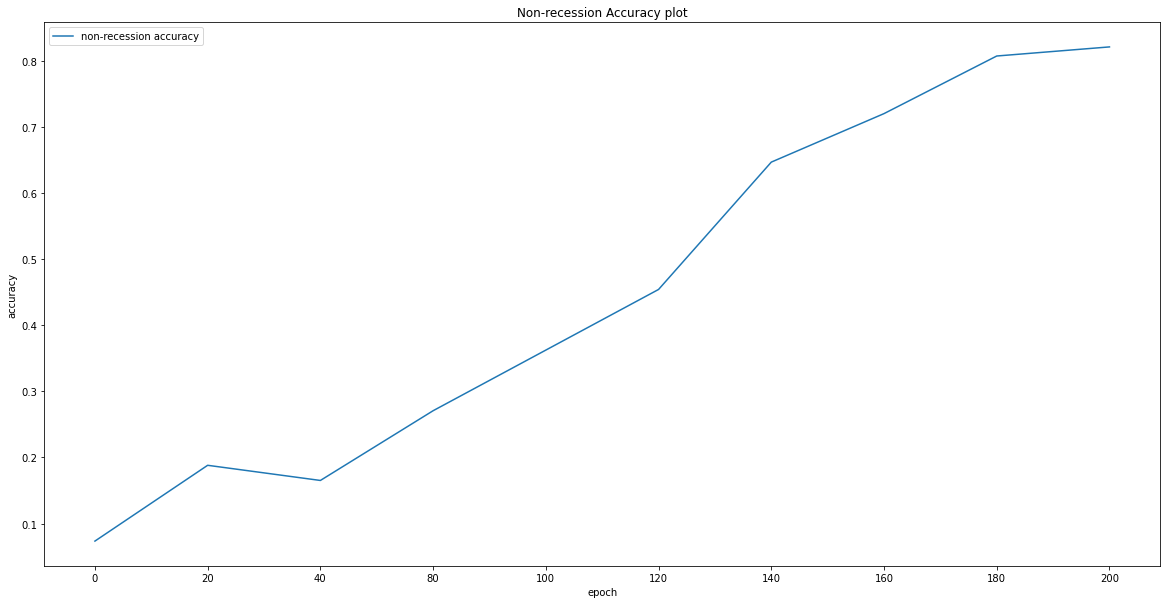

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

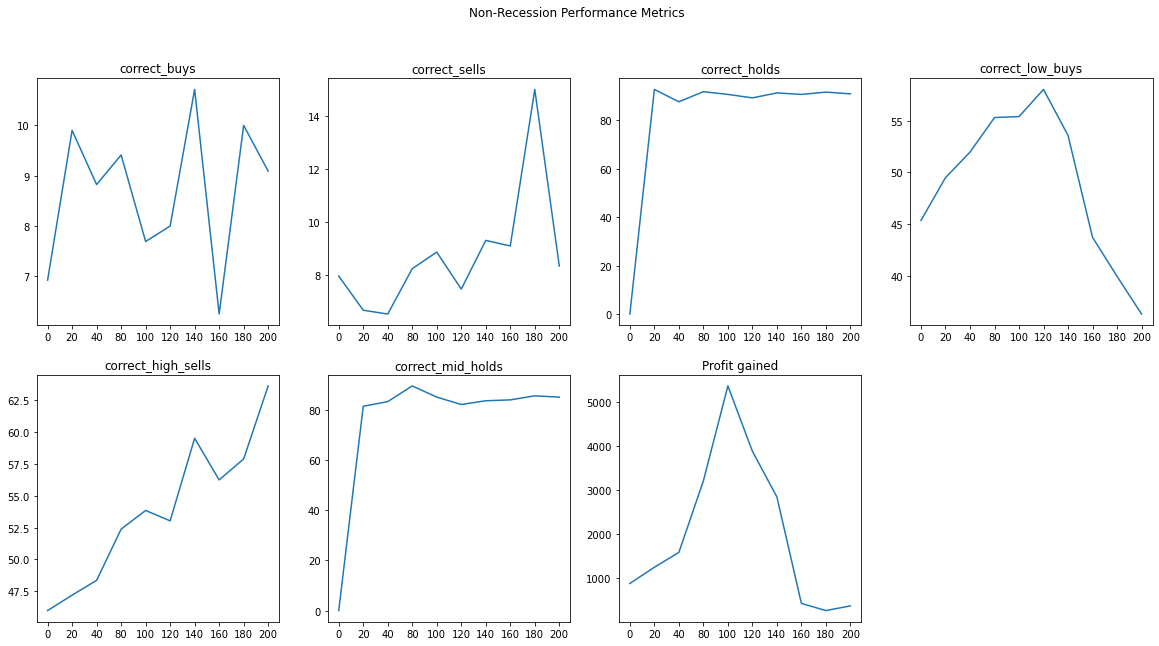

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

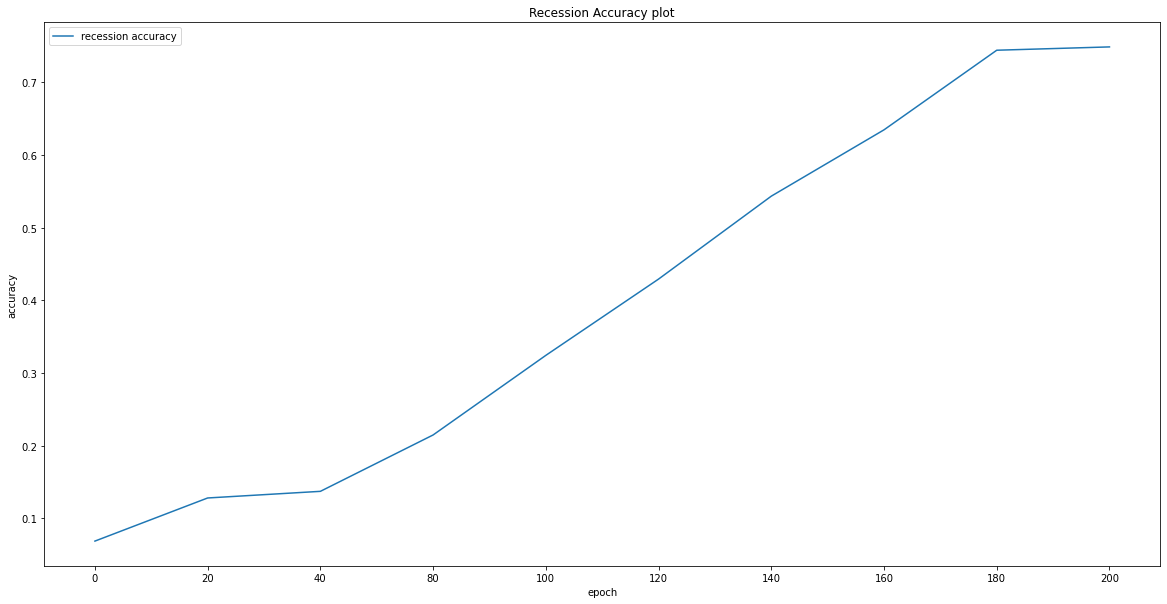

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

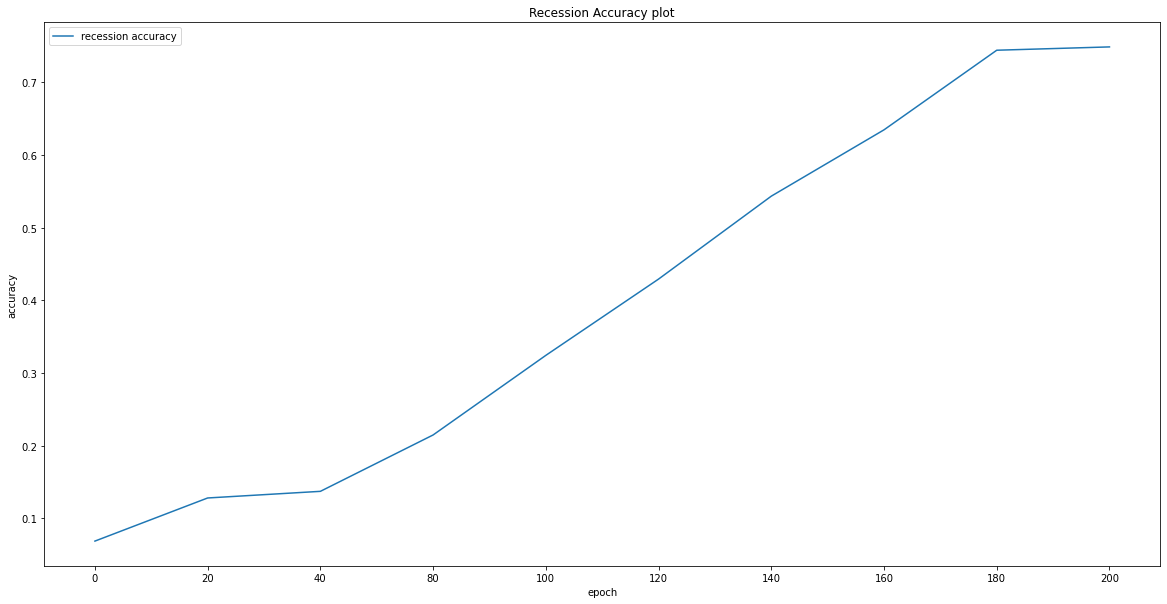

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

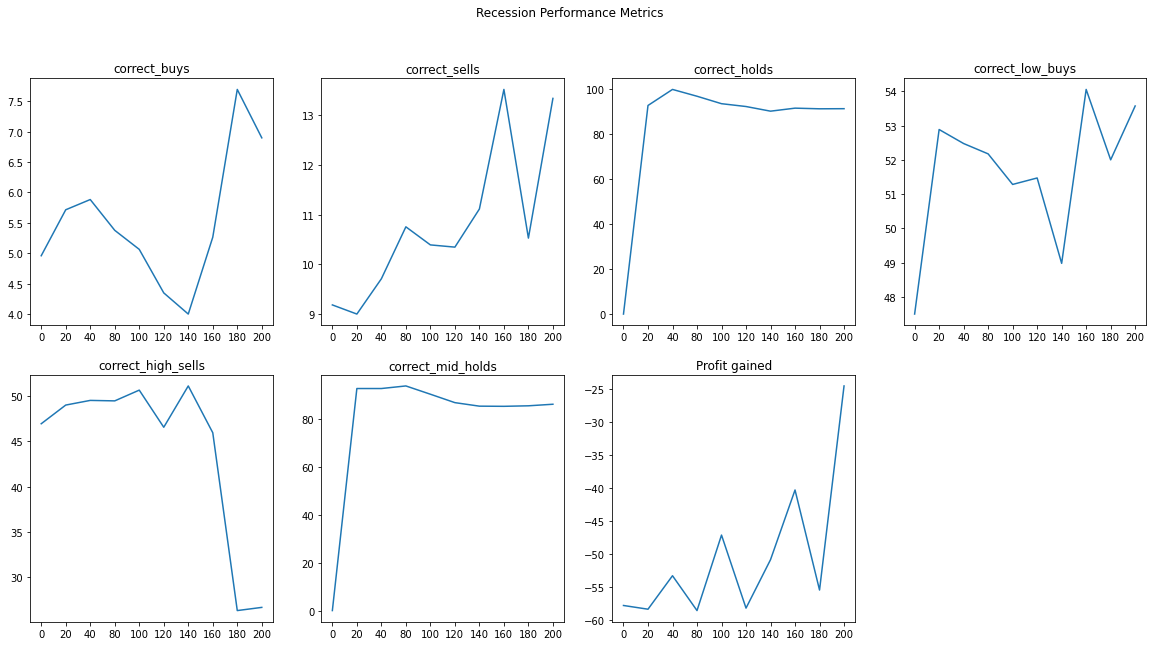

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### With Support Stock Data

In [114]:
nr_test_sets = ['MFC']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/JPM_data_test.csv")
    df2.set_index('Date', inplace=True)
    df['support'] = df2['previous_1d']
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    support_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    data_15_support = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            support_data.append(data_15_support_arr)
            labels.append(i[4])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]
            data_15_support = data_15_support[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    support_data = np.array(support_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        n = support_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)
        ax.plot(n)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        16.10  15.369379  -4.347841  12991200.0     2.0
2019-01-23        15.75  15.427936 -19.565241  11195700.0     2.0
2019-01-24        15.79  15.483638 -19.902947  12310800.0     2.0
2019-01-25        15.63  15.506155 -34.131754  10454700.0     2.0
2019-01-28        15.75  15.543670 -30.405447  11863600.0     2.0


In [115]:
r_test_sets = ['MFC']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/JPM_data_test2.csv")
    df2.set_index('Date', inplace=True)
    df['support'] = df2['previous_1d']
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    support_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    data_15_support = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            support_data.append(data_15_support_arr)
            labels.append(i[4])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]
            data_15_support = data_15_support[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    support_data = np.array(support_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        n = support_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)
        ax.plot(n)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    20.620001  20.787224 -56.481365  5587900.0     2.0
2020-01-23    20.760000  20.783036 -48.453572  7034300.0     2.0
2020-01-24    20.799999  20.785645 -44.329960  8383300.0     2.0
2020-01-27    20.650000  20.764777 -59.793849  5159000.0     2.0
2020-01-28    20.030001  20.651734 -87.591226  2998800.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21      6.09375  6.133837 -56.250000  1982400.0     2.0
2000-01-24      6.06250  6.122862 -60.000000  1705200.0     2.0
2000-01-25      5.96875  6.099153 -80.000000   909600.0     2.0
2000-01-26      6.00000  6.083898 -73.333333  1179600.0     2.0
2000-01-27      5.96875  6.066183 -80.000000   783000.0     2.0


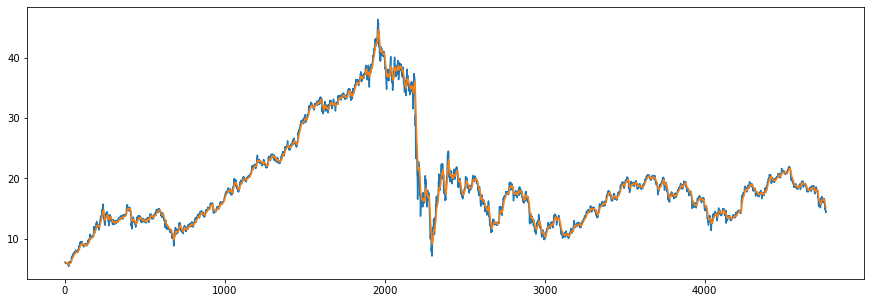

(4745, 64, 64, 1)

In [116]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 6/initial_indicators/MFC_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

df2 = pd.read_csv("variation 6/initial_indicators/JPM_data.csv")
df2.set_index('Date', inplace=True)
df['support'] = df2['previous_1d']
df.dropna(inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    n = support_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)
    ax.plot(n)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

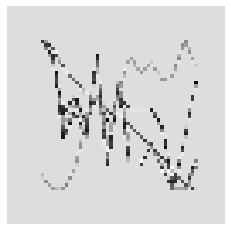

In [117]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [118]:
X = X/255

In [119]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [120]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [121]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [122]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [123]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('MFC')]
    y = nr_test_data['{}_y'.format('MFC')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('MFC'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_non_recession.csv'.format(experiment,'MFC')):
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'MFC'))
    else:
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'MFC'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('MFC')]
    y = r_test_data['{}_y'.format('MFC')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('MFC'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_recession.csv'.format(experiment,'MFC')):
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'MFC'))
    else:
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'MFC'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 6.9523809523809526, 1: 7.3996101364522415, 2: 0.3675089553683803}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2494 - accuracy: 0.3672 - mse: 1.6285 - weighted_accuracy: 0.2908 - weighted_mse: 1.7629 - val_loss: 0.2206 - val_accuracy: 0.0453 - val_mse: 0.8624 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.8624
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2061 - accuracy: 0.3243 - mse: 1.1550 - weighted_accuracy: 0.3426 - weighted_mse: 1.1793 - val_loss: 0.2125 - val_accuracy: 0.0485 - val_mse: 0.8873 - val_weighted_accuracy: 0.0485 - val_weighted_mse: 0.8873
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2046 - accuracy: 0.3654 - mse: 1.1631 - weighted_accuracy: 0.3521 - weighted_mse: 1.1787 - val_loss: 0.2009 - val_accuracy: 0.1602 - val_mse: 0.9062 - val_weighted_accuracy: 0.1602 - val_weighted_mse: 0.9062
Epoch 4/20
30/30 [==============================] - 0

7/7 [==============================] - 0s 2ms/step - loss: 0.2014 - accuracy: 0.0639 - mse: 0.9600 - weighted_accuracy: 0.0639 - weighted_mse: 0.9600
Test loss: 0.20140032470226288
Test accuracy: 0.06392694264650345


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 123
actual holds but predicted sell: 77
actual predicted holds: 0
Percentage buys correct: 4.545454545454546%
Percentage sells correct: 9.195402298850574%
Percentage holds correct: 0%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 45.80152671755725%
Percentage high sells correct: 45.97701149425287%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9542971538006071
Shares owned at the moment: 104
Cash capital at the moment: $0.48016701874988144


Price increase from previously bought

30/30 [==============================] - 0s 9ms/step - loss: 0.1952 - accuracy: 0.2460 - mse: 1.2141 - weighted_accuracy: 0.4030 - weighted_mse: 1.2044 - val_loss: 0.2002 - val_accuracy: 0.0727 - val_mse: 0.9628 - val_weighted_accuracy: 0.0727 - val_weighted_mse: 0.9628
Epoch 11/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1967 - accuracy: 0.2355 - mse: 1.1955 - weighted_accuracy: 0.3948 - weighted_mse: 1.1622 - val_loss: 0.1978 - val_accuracy: 0.0717 - val_mse: 0.9943 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 0.9943
Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1947 - accuracy: 0.2268 - mse: 1.2031 - weighted_accuracy: 0.4156 - weighted_mse: 1.1892 - val_loss: 0.2005 - val_accuracy: 0.0727 - val_mse: 0.9003 - val_weighted_accuracy: 0.0727 - val_weighted_mse: 0.9003
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1961 - accuracy: 0.2363 - mse: 1.2094 - weighted_accuracy: 0.4047 - weighted_mse: 1.1882

7/7 [==============================] - 0s 2ms/step - loss: 0.1955 - accuracy: 0.0685 - mse: 1.0430 - weighted_accuracy: 0.0685 - weighted_mse: 1.0430
Test loss: 0.19545897841453552
Test accuracy: 0.06849315017461777


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 104
actual holds but predicted sell: 96
actual predicted holds: 0
Percentage buys correct: 5.357142857142857%
Percentage sells correct: 8.411214953271028%
Percentage holds correct: 0%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 49.549549549549546%
Percentage high sells correct: 46.728971962616825%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.965791333014149
Shares owned at the moment: 103
Cash capital at the moment: $0.24993230446639814


Price increase from previously bough

30/30 [==============================] - 0s 9ms/step - loss: 0.1836 - accuracy: 0.1747 - mse: 1.2622 - weighted_accuracy: 0.5079 - weighted_mse: 1.2327 - val_loss: 0.1979 - val_accuracy: 0.0801 - val_mse: 1.0064 - val_weighted_accuracy: 0.0801 - val_weighted_mse: 1.0064
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1825 - accuracy: 0.1633 - mse: 1.2348 - weighted_accuracy: 0.4880 - weighted_mse: 1.2047 - val_loss: 0.1980 - val_accuracy: 0.0790 - val_mse: 1.0074 - val_weighted_accuracy: 0.0790 - val_weighted_mse: 1.0074
Epoch 9/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1821 - accuracy: 0.1670 - mse: 1.2872 - weighted_accuracy: 0.5175 - weighted_mse: 1.2386 - val_loss: 0.1955 - val_accuracy: 0.0685 - val_mse: 1.0718 - val_weighted_accuracy: 0.0685 - val_weighted_mse: 1.0718
Epoch 10/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1820 - accuracy: 0.1589 - mse: 1.2788 - weighted_accuracy: 0.4981 - weighted_mse: 1.2591

7/7 [==============================] - 0s 3ms/step - loss: 0.1980 - accuracy: 0.1005 - mse: 1.1604 - weighted_accuracy: 0.1005 - weighted_mse: 1.1604
Test loss: 0.1980208158493042
Test accuracy: 0.1004566177725792


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 95
actual holds but predicted sell: 99
actual predicted holds: 6
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 9.00900900900901%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 50.495049504950494%
Percentage high sells correct: 48.648648648648646%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.965791333014149
Shares owned at the moment: 103
Cash capital at the moment: $0.24993230446639814


Price increase from previously 

Epoch 5/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1695 - accuracy: 0.1628 - mse: 1.3295 - weighted_accuracy: 0.5628 - weighted_mse: 1.2828 - val_loss: 0.1984 - val_accuracy: 0.1243 - val_mse: 1.2073 - val_weighted_accuracy: 0.1243 - val_weighted_mse: 1.2073
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1705 - accuracy: 0.1633 - mse: 1.3328 - weighted_accuracy: 0.5371 - weighted_mse: 1.2581 - val_loss: 0.1992 - val_accuracy: 0.1233 - val_mse: 1.1746 - val_weighted_accuracy: 0.1233 - val_weighted_mse: 1.1746
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1696 - accuracy: 0.1654 - mse: 1.3568 - weighted_accuracy: 0.5335 - weighted_mse: 1.3052 - val_loss: 0.1951 - val_accuracy: 0.1233 - val_mse: 1.1937 - val_weighted_accuracy: 0.1233 - val_weighted_mse: 1.1937
Epoch 8/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1712 - accuracy: 0.1731 - mse: 1.3307 - weighted_accuracy: 0.5388 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.2014 - accuracy: 0.1142 - mse: 1.2757 - weighted_accuracy: 0.1142 - weighted_mse: 1.2757
Test loss: 0.20143109560012817
Test accuracy: 0.11415524780750275


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 96
actual holds but predicted sell: 93
actual predicted holds: 11
Percentage buys correct: 4.901960784313726%
Percentage sells correct: 8.653846153846153%
Percentage holds correct: 84.61538461538461%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 49.504950495049506%
Percentage high sells correct: 48.07692307692308%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.965791333014149
Shares owned at the moment: 103
Cash capital at the moment: $0.24993230446639814


Price

Epoch 5/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1554 - accuracy: 0.2028 - mse: 1.4633 - weighted_accuracy: 0.5859 - weighted_mse: 1.4430 - val_loss: 0.1936 - val_accuracy: 0.1612 - val_mse: 1.3029 - val_weighted_accuracy: 0.1612 - val_weighted_mse: 1.3029
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1557 - accuracy: 0.2013 - mse: 1.5000 - weighted_accuracy: 0.6015 - weighted_mse: 1.4423 - val_loss: 0.1980 - val_accuracy: 0.1644 - val_mse: 1.3019 - val_weighted_accuracy: 0.1644 - val_weighted_mse: 1.3019
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1543 - accuracy: 0.1981 - mse: 1.4864 - weighted_accuracy: 0.6208 - weighted_mse: 1.4656 - val_loss: 0.1981 - val_accuracy: 0.1686 - val_mse: 1.3390 - val_weighted_accuracy: 0.1686 - val_weighted_mse: 1.3390
Epoch 8/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1541 - accuracy: 0.1910 - mse: 1.4778 - weighted_accuracy: 0.6055 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1952 - accuracy: 0.2009 - mse: 1.3810 - weighted_accuracy: 0.2009 - weighted_mse: 1.3810
Test loss: 0.19523604214191437
Test accuracy: 0.2009132355451584


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 72
actual holds but predicted sell: 97
actual predicted holds: 31
Percentage buys correct: 5.194805194805195%
Percentage sells correct: 8.256880733944953%
Percentage holds correct: 93.93939393939394%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 53.94736842105263%
Percentage high sells correct: 46.788990825688074%
Percentage mid holds correct: 90.9090909090909%


Capital: 100
Share price: $0.965791333014149
Shares owned at the moment: 103
Cash capital at the moment: $0.24993230446639814


Price i

Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1446 - accuracy: 0.2453 - mse: 1.5874 - weighted_accuracy: 0.6619 - weighted_mse: 1.6001 - val_loss: 0.1917 - val_accuracy: 0.2192 - val_mse: 1.4190 - val_weighted_accuracy: 0.2192 - val_weighted_mse: 1.4190
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1470 - accuracy: 0.2426 - mse: 1.5392 - weighted_accuracy: 0.6466 - weighted_mse: 1.5349 - val_loss: 0.1945 - val_accuracy: 0.2308 - val_mse: 1.4852 - val_weighted_accuracy: 0.2308 - val_weighted_mse: 1.4852
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1441 - accuracy: 0.2497 - mse: 1.6097 - weighted_accuracy: 0.6507 - weighted_mse: 1.6657 - val_loss: 0.1933 - val_accuracy: 0.2360 - val_mse: 1.4825 - val_weighted_accuracy: 0.2360 - val_weighted_mse: 1.4825
Epoch 5/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1445 - accuracy: 0.2468 - mse: 1.6077 - weighted_accuracy: 0.6443 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1940 - accuracy: 0.2648 - mse: 1.5507 - weighted_accuracy: 0.2648 - weighted_mse: 1.5507
Test loss: 0.1939704418182373
Test accuracy: 0.26484018564224243


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 67
actual holds but predicted sell: 87
actual predicted holds: 46
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 8.16326530612245%
Percentage holds correct: 93.87755102040816%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 50.70422535211268%
Percentage high sells correct: 46.93877551020408%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.965791333014149
Shares owned at the moment: 103
Cash capital at the moment: $0.24993230446639814


Price in

Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1341 - accuracy: 0.3330 - mse: 1.7464 - weighted_accuracy: 0.6998 - weighted_mse: 1.8821 - val_loss: 0.1875 - val_accuracy: 0.3298 - val_mse: 1.5160 - val_weighted_accuracy: 0.3298 - val_weighted_mse: 1.5160
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1343 - accuracy: 0.3269 - mse: 1.7385 - weighted_accuracy: 0.6959 - weighted_mse: 1.9095 - val_loss: 0.1868 - val_accuracy: 0.3066 - val_mse: 1.5323 - val_weighted_accuracy: 0.3066 - val_weighted_mse: 1.5323
Epoch 5/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1366 - accuracy: 0.3332 - mse: 1.7023 - weighted_accuracy: 0.6922 - weighted_mse: 1.8465 - val_loss: 0.1824 - val_accuracy: 0.3414 - val_mse: 1.4761 - val_weighted_accuracy: 0.3414 - val_weighted_mse: 1.4761
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1350 - accuracy: 0.3330 - mse: 1.7282 - weighted_accuracy: 0.7101 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1876 - accuracy: 0.3881 - mse: 1.7151 - weighted_accuracy: 0.3881 - weighted_mse: 1.7151
Test loss: 0.18763580918312073
Test accuracy: 0.388127863407135


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 69
actual holds but predicted sell: 58
actual predicted holds: 73
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 10.447761194029852%
Percentage holds correct: 94.8051948051948%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 48.648648648648646%
Percentage high sells correct: 52.23880597014925%
Percentage mid holds correct: 87.01298701298701%


Capital: 100
Share price: $0.965791333014149
Shares owned at the moment: 103
Cash capital at the moment: $0.24993230446639814


Price i

Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1236 - accuracy: 0.4389 - mse: 1.9684 - weighted_accuracy: 0.7334 - weighted_mse: 2.3683 - val_loss: 0.1707 - val_accuracy: 0.4910 - val_mse: 1.7196 - val_weighted_accuracy: 0.4910 - val_weighted_mse: 1.7196
Epoch 8/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1207 - accuracy: 0.4557 - mse: 1.9533 - weighted_accuracy: 0.7611 - weighted_mse: 2.3293 - val_loss: 0.1680 - val_accuracy: 0.5058 - val_mse: 1.6947 - val_weighted_accuracy: 0.5058 - val_weighted_mse: 1.6947
Epoch 9/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1274 - accuracy: 0.4497 - mse: 1.9924 - weighted_accuracy: 0.7339 - weighted_mse: 2.3498 - val_loss: 0.1743 - val_accuracy: 0.4721 - val_mse: 1.7304 - val_weighted_accuracy: 0.4721 - val_weighted_mse: 1.7304
Epoch 10/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1210 - accuracy: 0.4602 - mse: 1.9748 - weighted_accuracy: 0.7556 - weighte

7/7 [==============================] - 0s 3ms/step - loss: 0.1671 - accuracy: 0.5251 - mse: 1.8414 - weighted_accuracy: 0.5251 - weighted_mse: 1.8414
Test loss: 0.1671271175146103
Test accuracy: 0.5251141786575317


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 42
actual holds but predicted sell: 52
actual predicted holds: 106
Percentage buys correct: 6.521739130434782%
Percentage sells correct: 10.0%
Percentage holds correct: 93.80530973451327%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 48.888888888888886%
Percentage high sells correct: 51.666666666666664%
Percentage mid holds correct: 87.61061946902655%


Capital: 100
Share price: $0.9542971538006071
Shares owned at the moment: 104
Cash capital at the moment: $0.48016701874988144


Price increase fr

Epoch 9/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1104 - accuracy: 0.5461 - mse: 2.3100 - weighted_accuracy: 0.7890 - weighted_mse: 2.9903 - val_loss: 0.1564 - val_accuracy: 0.5954 - val_mse: 1.8667 - val_weighted_accuracy: 0.5954 - val_weighted_mse: 1.8667
Epoch 10/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1115 - accuracy: 0.5556 - mse: 2.2690 - weighted_accuracy: 0.7910 - weighted_mse: 2.9758 - val_loss: 0.1656 - val_accuracy: 0.5490 - val_mse: 1.9611 - val_weighted_accuracy: 0.5490 - val_weighted_mse: 1.9611
Epoch 11/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1083 - accuracy: 0.5508 - mse: 2.4069 - weighted_accuracy: 0.7821 - weighted_mse: 3.3412 - val_loss: 0.1538 - val_accuracy: 0.6291 - val_mse: 2.0105 - val_weighted_accuracy: 0.6291 - val_weighted_mse: 2.0105
Epoch 12/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1106 - accuracy: 0.5835 - mse: 2.3064 - weighted_accuracy: 0.7972 - weigh

7/7 [==============================] - 0s 3ms/step - loss: 0.1672 - accuracy: 0.5525 - mse: 2.1321 - weighted_accuracy: 0.5525 - weighted_mse: 2.1321
Test loss: 0.16722923517227173
Test accuracy: 0.5525113940238953


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 43
actual holds but predicted sell: 43
actual predicted holds: 114
Percentage buys correct: 6.25%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 92.6829268292683%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 48.93617021276596%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 86.17886178861788%


Capital: 100
Share price: $0.9542971538006071
Shares owned at the moment: 104
Cash capital at the moment: $0.48016701874988144


Price increase from previously b

30/30 [==============================] - 0s 12ms/step - loss: 0.1036 - accuracy: 0.6375 - mse: 2.6552 - weighted_accuracy: 0.8228 - weighted_mse: 3.7161 - val_loss: 0.1379 - val_accuracy: 0.7134 - val_mse: 2.2573 - val_weighted_accuracy: 0.7134 - val_weighted_mse: 2.2573
Epoch 11/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1004 - accuracy: 0.6457 - mse: 2.6414 - weighted_accuracy: 0.8418 - weighted_mse: 3.7227 - val_loss: 0.1409 - val_accuracy: 0.6997 - val_mse: 2.1987 - val_weighted_accuracy: 0.6997 - val_weighted_mse: 2.1987
Epoch 12/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1000 - accuracy: 0.6546 - mse: 2.7009 - weighted_accuracy: 0.8208 - weighted_mse: 3.9978 - val_loss: 0.1488 - val_accuracy: 0.6596 - val_mse: 2.1681 - val_weighted_accuracy: 0.6596 - val_weighted_mse: 2.1681
Epoch 13/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1030 - accuracy: 0.6399 - mse: 2.6840 - weighted_accuracy: 0.8217 - weighted_mse: 3.

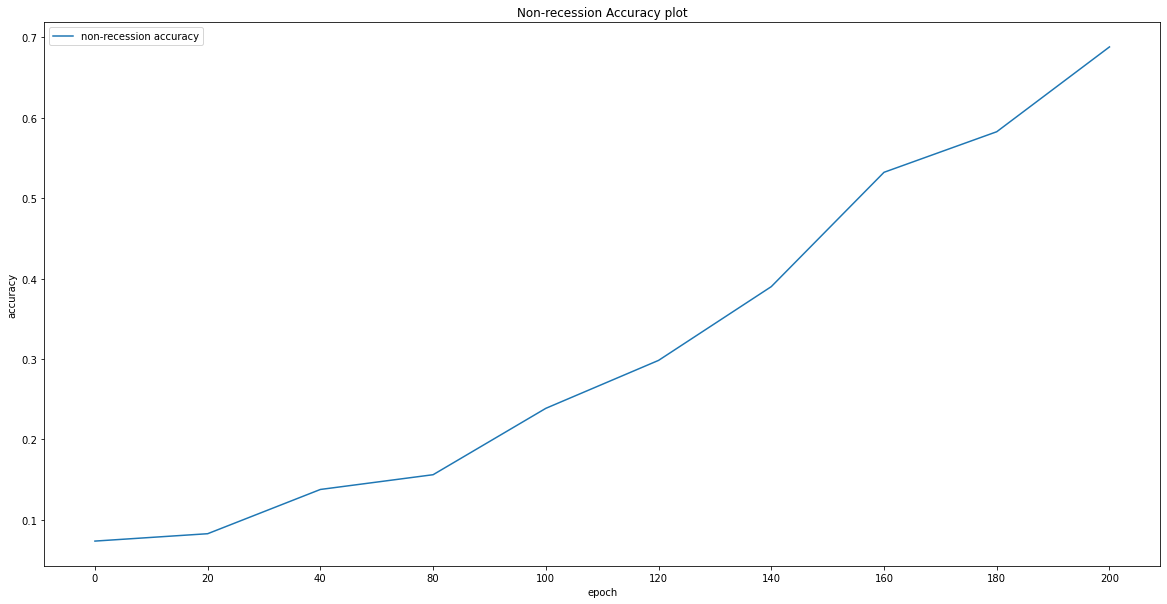

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

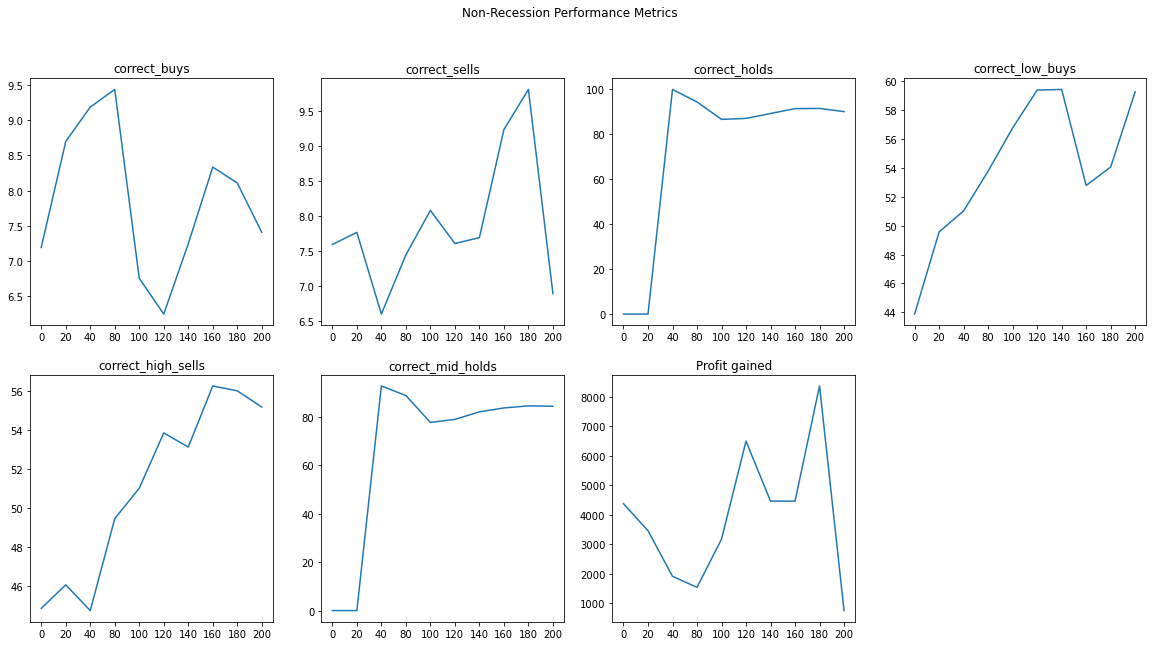

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

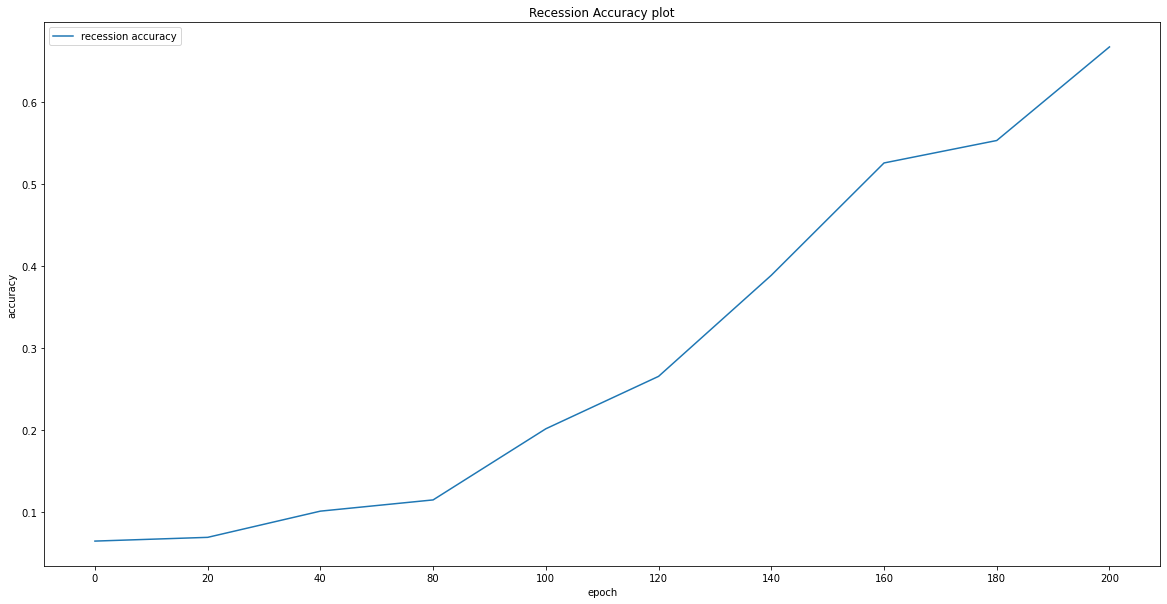

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

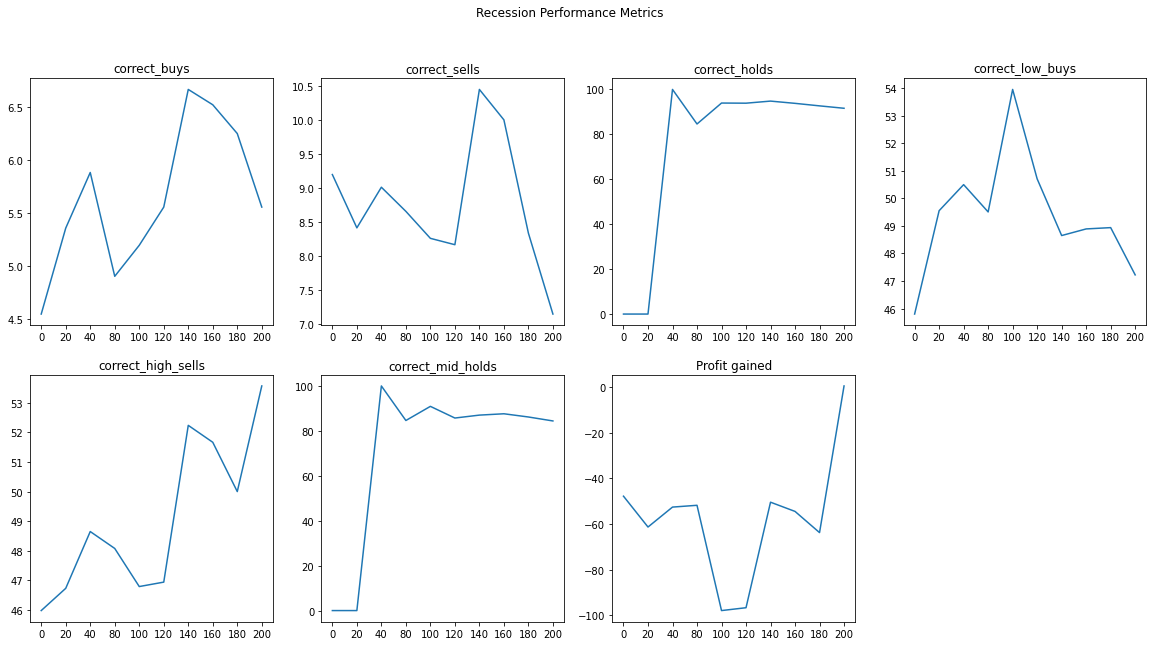

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

## ON Semiconductor Corporation

### No support Stock Data

In [410]:
nr_test_sets = ['ON']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    18.410000  17.463881 -16.959062  38067400.0     2.0
2019-01-23    17.760000  17.509437 -35.964898  32120500.0     1.0
2019-01-24    17.610001  17.524909 -40.350852  27571200.0     2.0
2019-01-25    18.990000  17.750307  -5.688638  39283300.0     2.0
2019-01-28    20.120001  18.114876  -3.499985  49475700.0     2.0


In [411]:
r_test_sets = ['ON']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    24.790001  24.846573 -58.549170  15793400.0     2.0
2020-01-23    24.799999  24.839408 -58.031122  19314300.0     2.0
2020-01-24    25.469999  24.936422 -23.316098  25250200.0     2.0
2020-01-27    24.990000  24.944665 -48.186537  19824200.0     2.0
2020-01-28    23.660000  24.747024 -96.170207  12158200.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-05-22      22.7500  21.868590 -31.896552  -691100.0     2.0
2000-05-23      20.0000  21.581114 -67.289720 -1747800.0     2.0
2000-05-24      19.8750  21.318635 -69.158879 -3059300.0     2.0
2000-05-25      19.5000  21.038845 -74.766355 -3905000.0     2.0
2000-05-26      18.1875  20.600177 -94.392523 -4983300.0     1.0


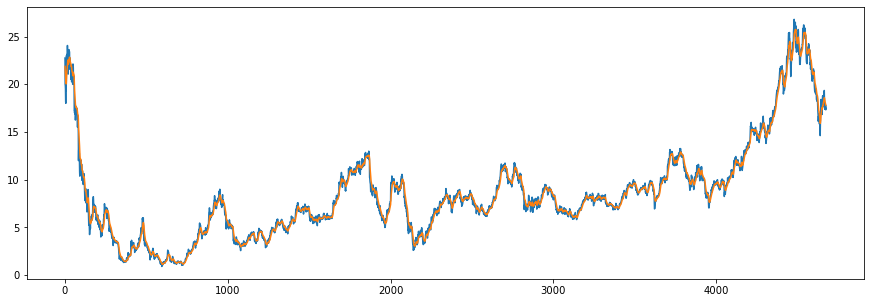

(4661, 64, 64, 1)

In [412]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 6/initial_indicators/ON_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

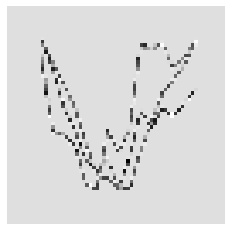

In [413]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [414]:
X = X/255

In [415]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [416]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [417]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [418]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [419]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('ON')]
    y = nr_test_data['{}_y'.format('ON')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('ON'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_non_recession.csv'.format(experiment,'ON')):
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'ON'))
    else:
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'ON'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('ON')]
    y = r_test_data['{}_y'.format('ON')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('ON'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_recession.csv'.format(experiment,'ON')):
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'ON'))
    else:
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'ON'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.864978902953586, 1: 7.766666666666667, 2: 0.36441837732160315}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2386 - accuracy: 0.4410 - mse: 1.5372 - weighted_accuracy: 0.3087 - weighted_mse: 1.6160 - val_loss: 0.1927 - val_accuracy: 0.8424 - val_mse: 0.9103 - val_weighted_accuracy: 0.8424 - val_weighted_mse: 0.9103
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2059 - accuracy: 0.3342 - mse: 1.1591 - weighted_accuracy: 0.3193 - weighted_mse: 1.1876 - val_loss: 0.2118 - val_accuracy: 0.0439 - val_mse: 0.9720 - val_weighted_accuracy: 0.0439 - val_weighted_mse: 0.9720
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2061 - accuracy: 0.3018 - mse: 1.1515 - weighted_accuracy: 0.3356 - weighted_mse: 1.1544 - val_loss: 0.2034 - val_accuracy: 0.0461 - val_mse: 1.0394 - val_weighted_accuracy: 0.0461 - val_weighted_mse: 1.0394
Epoch 4/20
30/30 [==============================] - 0s 

7/7 [==============================] - 0s 2ms/step - loss: 0.2002 - accuracy: 0.0548 - mse: 1.0047 - weighted_accuracy: 0.0548 - weighted_mse: 1.0047
Test loss: 0.20020431280136108
Test accuracy: 0.054794520139694214


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 7
actual predicted sells: 3
actual sells but predicted hold: 0
actual holds but predicted buy: 161
actual holds but predicted sell: 37
actual predicted holds: 0
Percentage buys correct: 5.084745762711864%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 0%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 42.04545454545455%
Percentage high sells correct: 42.857142857142854%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price increase from previously boug

30/30 [==============================] - 0s 9ms/step - loss: 0.1950 - accuracy: 0.2363 - mse: 1.1770 - weighted_accuracy: 0.4257 - weighted_mse: 1.1660 - val_loss: 0.1942 - val_accuracy: 0.0729 - val_mse: 1.0172 - val_weighted_accuracy: 0.0729 - val_weighted_mse: 1.0172
Epoch 10/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1936 - accuracy: 0.2546 - mse: 1.2377 - weighted_accuracy: 0.4166 - weighted_mse: 1.2446 - val_loss: 0.1992 - val_accuracy: 0.0761 - val_mse: 0.9409 - val_weighted_accuracy: 0.0761 - val_weighted_mse: 0.9409
Epoch 11/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1934 - accuracy: 0.2594 - mse: 1.1793 - weighted_accuracy: 0.4203 - weighted_mse: 1.1709 - val_loss: 0.1979 - val_accuracy: 0.0740 - val_mse: 0.9681 - val_weighted_accuracy: 0.0740 - val_weighted_mse: 0.9681
Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1909 - accuracy: 0.2578 - mse: 1.2209 - weighted_accuracy: 0.4455 - weighted_mse: 1.187

7/7 [==============================] - 0s 2ms/step - loss: 0.1980 - accuracy: 0.0731 - mse: 0.9625 - weighted_accuracy: 0.0731 - weighted_mse: 0.9625
Test loss: 0.1979857087135315
Test accuracy: 0.07305935770273209


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 108
actual holds but predicted sell: 90
actual predicted holds: 0
Percentage buys correct: 7.5%
Percentage sells correct: 7.070707070707071%
Percentage holds correct: 0%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 45.378151260504204%
Percentage high sells correct: 48.484848484848484%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price increase from previously bought: 0.028384493

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1835 - accuracy: 0.2009 - mse: 1.2896 - weighted_accuracy: 0.4951 - weighted_mse: 1.2335 - val_loss: 0.1943 - val_accuracy: 0.0761 - val_mse: 1.1130 - val_weighted_accuracy: 0.0761 - val_weighted_mse: 1.1130
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1889 - accuracy: 0.1762 - mse: 1.2346 - weighted_accuracy: 0.4461 - weighted_mse: 1.1981 - val_loss: 0.1966 - val_accuracy: 0.0772 - val_mse: 1.0183 - val_weighted_accuracy: 0.0772 - val_weighted_mse: 1.0183
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1843 - accuracy: 0.1851 - mse: 1.2429 - weighted_accuracy: 0.4871 - weighted_mse: 1.2222 - val_loss: 0.1961 - val_accuracy: 0.0740 - val_mse: 1.0085 - val_weighted_accuracy: 0.0740 - val_weighted_mse: 1.0085
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1825 - accuracy: 0.1894 - mse: 1.2701 - weighted_accuracy: 0.4889 - weighted_ms

Cash capital at the moment: $59.89730648783455


Share price: $0.985609742748722
Shares owned at the moment: 60
Cash capital at the moment: $0.5980963153576795




Capital at the end of test period: $61.03144631535768
profit gained: -38.96855368464232%


Capital at the end of test period if Buy and Hold: $127.57847630429416
profit gained: 27.57847630429416%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.114679      5.785124       7.228916      85.714286   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         48.760331           45.121951          71.428571     -38.968554   

   buy_n_hold profit  
0          27.578476  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1990 - accuracy: 0.1644 - mse: 1.0899 - weighted_accuracy: 0.1644 - weighted_mse: 1.0899
Test loss: 0.19895559549331665
Test accuracy: 0.16438356041908264


number of predictions: 219
actual predicted buys: 8
actual buys but predi

30/30 [==============================] - 0s 10ms/step - loss: 0.1689 - accuracy: 0.1746 - mse: 1.3538 - weighted_accuracy: 0.5535 - weighted_mse: 1.3401 - val_loss: 0.1980 - val_accuracy: 0.1233 - val_mse: 1.1094 - val_weighted_accuracy: 0.1233 - val_weighted_mse: 1.1094
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1712 - accuracy: 0.1647 - mse: 1.2981 - weighted_accuracy: 0.5358 - weighted_mse: 1.2723 - val_loss: 0.1970 - val_accuracy: 0.1490 - val_mse: 1.2283 - val_weighted_accuracy: 0.1490 - val_weighted_mse: 1.2283
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1690 - accuracy: 0.1762 - mse: 1.3267 - weighted_accuracy: 0.5440 - weighted_mse: 1.2948 - val_loss: 0.1962 - val_accuracy: 0.1383 - val_mse: 1.1936 - val_weighted_accuracy: 0.1383 - val_weighted_mse: 1.1936
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1661 - accuracy: 0.1899 - mse: 1.3936 - weighted_accuracy: 0.5651 - weighted_mse: 1.375

7/7 [==============================] - 0s 2ms/step - loss: 0.1978 - accuracy: 0.2055 - mse: 1.2219 - weighted_accuracy: 0.2055 - weighted_mse: 1.2219
Test loss: 0.1978030502796173
Test accuracy: 0.2054794579744339


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 79
actual holds but predicted sell: 87
actual predicted holds: 32
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 7.216494845360825%
Percentage holds correct: 88.88888888888889%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 44.18604651162791%
Percentage high sells correct: 49.48453608247423%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price i

Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1533 - accuracy: 0.2192 - mse: 1.4827 - weighted_accuracy: 0.6177 - weighted_mse: 1.5009 - val_loss: 0.1945 - val_accuracy: 0.1811 - val_mse: 1.3020 - val_weighted_accuracy: 0.1811 - val_weighted_mse: 1.3020
Epoch 3/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1560 - accuracy: 0.2138 - mse: 1.4438 - weighted_accuracy: 0.6058 - weighted_mse: 1.4428 - val_loss: 0.1955 - val_accuracy: 0.2090 - val_mse: 1.3189 - val_weighted_accuracy: 0.2090 - val_weighted_mse: 1.3189
Epoch 4/20
30/30 [==============================] - 1s 26ms/step - loss: 0.1553 - accuracy: 0.2151 - mse: 1.4864 - weighted_accuracy: 0.6122 - weighted_mse: 1.4698 - val_loss: 0.1967 - val_accuracy: 0.1961 - val_mse: 1.3917 - val_weighted_accuracy: 0.1961 - val_weighted_mse: 1.3917
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1549 - accuracy: 0.2098 - mse: 1.4929 - weighted_accuracy: 0.6022 - weighted_m

7/7 [==============================] - 0s 2ms/step - loss: 0.1962 - accuracy: 0.2511 - mse: 1.4523 - weighted_accuracy: 0.2511 - weighted_mse: 1.4523
Test loss: 0.19621795415878296
Test accuracy: 0.2511415481567383


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 4
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 58
actual holds but predicted sell: 99
actual predicted holds: 41
Percentage buys correct: 9.23076923076923%
Percentage sells correct: 7.207207207207207%
Percentage holds correct: 95.34883720930233%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 47.69230769230769%
Percentage high sells correct: 51.351351351351354%
Percentage mid holds correct: 90.47619047619048%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price 

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1437 - accuracy: 0.2648 - mse: 1.6212 - weighted_accuracy: 0.6600 - weighted_mse: 1.6974 - val_loss: 0.1931 - val_accuracy: 0.2529 - val_mse: 1.4263 - val_weighted_accuracy: 0.2529 - val_weighted_mse: 1.4263
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1502 - accuracy: 0.2610 - mse: 1.5904 - weighted_accuracy: 0.6228 - weighted_mse: 1.6100 - val_loss: 0.1911 - val_accuracy: 0.2637 - val_mse: 1.4443 - val_weighted_accuracy: 0.2637 - val_weighted_mse: 1.4443
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1462 - accuracy: 0.2519 - mse: 1.6171 - weighted_accuracy: 0.6317 - weighted_mse: 1.6376 - val_loss: 0.1926 - val_accuracy: 0.2637 - val_mse: 1.4568 - val_weighted_accuracy: 0.2637 - val_weighted_mse: 1.4568
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1455 - accuracy: 0.2631 - mse: 1.6283 - weighted_accuracy: 0.6377 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1905 - accuracy: 0.3425 - mse: 1.5845 - weighted_accuracy: 0.3425 - weighted_mse: 1.5845
Test loss: 0.19050715863704681
Test accuracy: 0.34246575832366943


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 4
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 54
actual holds but predicted sell: 81
actual predicted holds: 63
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 7.608695652173913%
Percentage holds correct: 94.02985074626865%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 50.0%
Percentage high sells correct: 52.17391304347826%
Percentage mid holds correct: 87.87878787878788%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price increase fro




RUNNING EPOCHS 120 - 140



Epoch 1/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1353 - accuracy: 0.3313 - mse: 1.8406 - weighted_accuracy: 0.6924 - weighted_mse: 1.9370 - val_loss: 0.1878 - val_accuracy: 0.3408 - val_mse: 1.5732 - val_weighted_accuracy: 0.3408 - val_weighted_mse: 1.5732
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1348 - accuracy: 0.3310 - mse: 1.8061 - weighted_accuracy: 0.6902 - weighted_mse: 1.9350 - val_loss: 0.1837 - val_accuracy: 0.3612 - val_mse: 1.6124 - val_weighted_accuracy: 0.3612 - val_weighted_mse: 1.6124
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1349 - accuracy: 0.3337 - mse: 1.8409 - weighted_accuracy: 0.6852 - weighted_mse: 1.9984 - val_loss: 0.1861 - val_accuracy: 0.3462 - val_mse: 1.6115 - val_weighted_accuracy: 0.3462 - val_weighted_mse: 1.6115
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1366 - accuracy: 0.3246 - mse: 1.7829 - weighte

7/7 [==============================] - 0s 2ms/step - loss: 0.1773 - accuracy: 0.4795 - mse: 1.7463 - weighted_accuracy: 0.4795 - weighted_mse: 1.7463
Test loss: 0.17728766798973083
Test accuracy: 0.4794520437717438


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 4
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 42
actual holds but predicted sell: 62
actual predicted holds: 94
Percentage buys correct: 10.416666666666666%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 94.94949494949495%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 52.083333333333336%
Percentage high sells correct: 51.388888888888886%
Percentage mid holds correct: 88.77551020408163%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Pri

Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1288 - accuracy: 0.4399 - mse: 2.0028 - weighted_accuracy: 0.7379 - weighted_mse: 2.3289 - val_loss: 0.1718 - val_accuracy: 0.4845 - val_mse: 1.7987 - val_weighted_accuracy: 0.4845 - val_weighted_mse: 1.7987
Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1259 - accuracy: 0.4324 - mse: 2.0263 - weighted_accuracy: 0.7332 - weighted_mse: 2.4232 - val_loss: 0.1774 - val_accuracy: 0.4169 - val_mse: 1.6790 - val_weighted_accuracy: 0.4169 - val_weighted_mse: 1.6790
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1294 - accuracy: 0.4284 - mse: 1.8706 - weighted_accuracy: 0.7316 - weighted_mse: 2.1524 - val_loss: 0.1691 - val_accuracy: 0.5016 - val_mse: 1.7701 - val_weighted_accuracy: 0.5016 - val_weighted_mse: 1.7701
Epoch 8/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1216 - accuracy: 0.4611 - mse: 2.0068 - weighted_accuracy: 0.7736 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1715 - accuracy: 0.5571 - mse: 1.9287 - weighted_accuracy: 0.5571 - weighted_mse: 1.9287
Test loss: 0.17152006924152374
Test accuracy: 0.5570776462554932


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 4
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 34
actual holds but predicted sell: 51
actual predicted holds: 113
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 93.38842975206612%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 57.89473684210526%
Percentage high sells correct: 56.666666666666664%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price increase f

Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1141 - accuracy: 0.5225 - mse: 2.2983 - weighted_accuracy: 0.7841 - weighted_mse: 2.9663 - val_loss: 0.1610 - val_accuracy: 0.5616 - val_mse: 1.8715 - val_weighted_accuracy: 0.5616 - val_weighted_mse: 1.8715
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1196 - accuracy: 0.5325 - mse: 2.2738 - weighted_accuracy: 0.7756 - weighted_mse: 2.7624 - val_loss: 0.1608 - val_accuracy: 0.5520 - val_mse: 1.8742 - val_weighted_accuracy: 0.5520 - val_weighted_mse: 1.8742
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1193 - accuracy: 0.5346 - mse: 2.2642 - weighted_accuracy: 0.7763 - weighted_mse: 2.7994 - val_loss: 0.1495 - val_accuracy: 0.6249 - val_mse: 1.8508 - val_weighted_accuracy: 0.6249 - val_weighted_mse: 1.8508
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1180 - accuracy: 0.5174 - mse: 2.2637 - weighted_accuracy: 0.7661 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1531 - accuracy: 0.6621 - mse: 2.1450 - weighted_accuracy: 0.6621 - weighted_mse: 2.1450
Test loss: 0.15311960875988007
Test accuracy: 0.6621004343032837


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 2
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 22
actual holds but predicted sell: 36
actual predicted holds: 140
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 7.317073170731708%
Percentage holds correct: 90.9090909090909%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 62.5%
Percentage high sells correct: 63.41463414634146%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.5477969547099459
Shares owned at the moment: 182
Cash capital at the moment: $0.026781866957506395


Price increase fro

Epoch 15/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1023 - accuracy: 0.6143 - mse: 3.0058 - weighted_accuracy: 0.8314 - weighted_mse: 4.3461 - val_loss: 0.1393 - val_accuracy: 0.6902 - val_mse: 2.2936 - val_weighted_accuracy: 0.6902 - val_weighted_mse: 2.2936
Epoch 16/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1049 - accuracy: 0.6239 - mse: 2.8781 - weighted_accuracy: 0.8148 - weighted_mse: 4.0552 - val_loss: 0.1373 - val_accuracy: 0.7160 - val_mse: 2.3626 - val_weighted_accuracy: 0.7160 - val_weighted_mse: 2.3626
Epoch 17/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1064 - accuracy: 0.6349 - mse: 2.8877 - weighted_accuracy: 0.8168 - weighted_mse: 3.9716 - val_loss: 0.1342 - val_accuracy: 0.7245 - val_mse: 2.4159 - val_weighted_accuracy: 0.7245 - val_weighted_mse: 2.4159
Epoch 18/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1077 - accuracy: 0.6339 - mse: 2.9329 - weighted_accuracy: 0.8046 - weigh

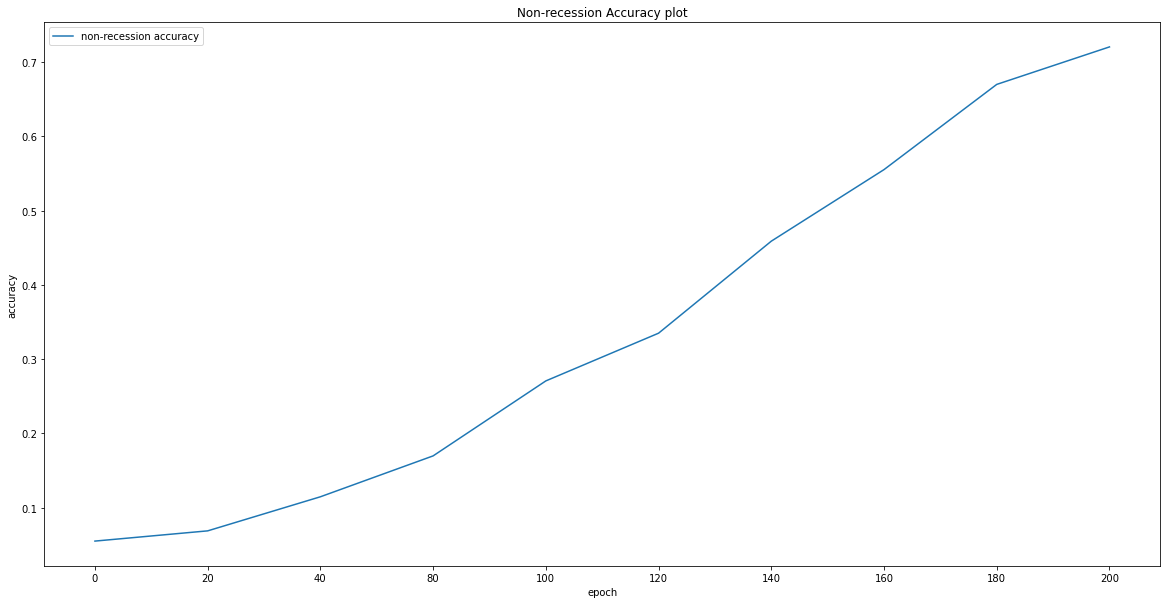

In [420]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

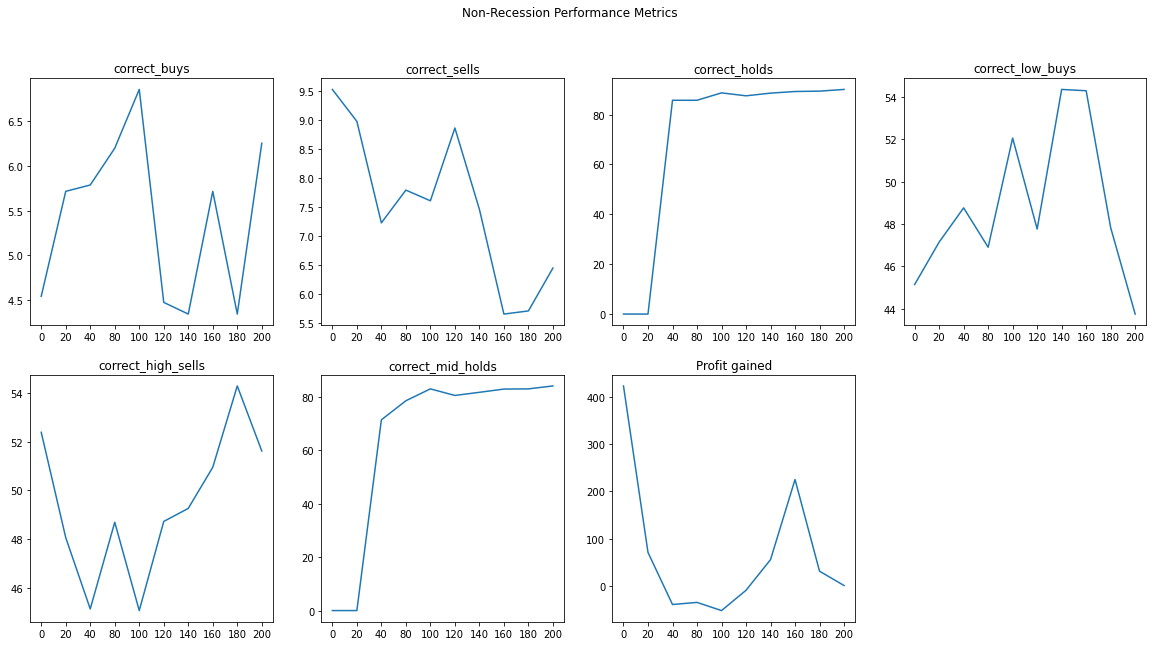

In [421]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

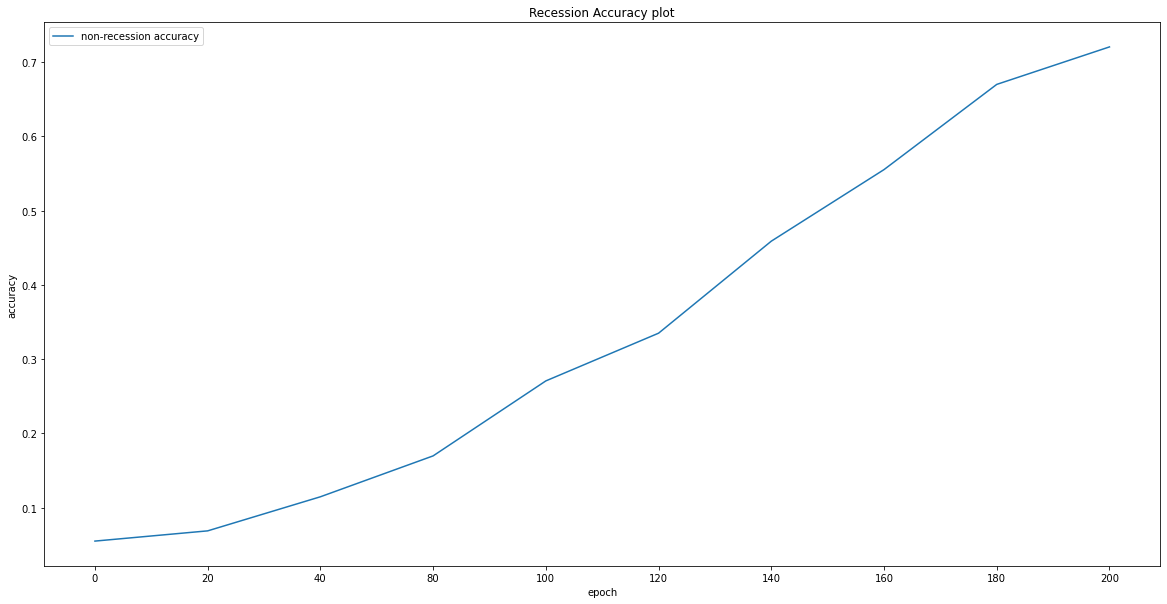

In [422]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

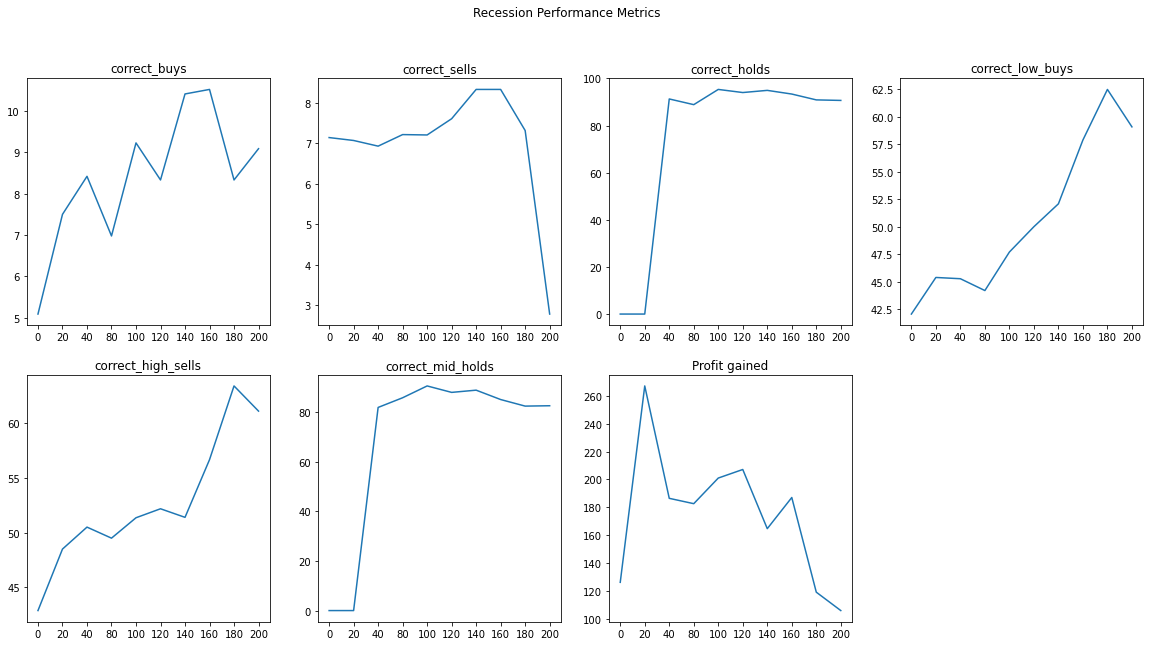

In [423]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### With Support Stock Data

In [424]:
nr_test_sets = ['ON']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/TSM_data_test.csv")
    df2.set_index('Date', inplace=True)
    print(df2.head())
    
    df['support'] = df2['previous_1d']
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    support_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    data_15_support = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            support_data.append(data_15_support_arr)
            labels.append(i[4])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]
            data_15_support = data_15_support[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    support_data = np.array(support_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        n = support_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)
        ax.plot(n)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    18.410000  17.463881 -16.959062  38067400.0     2.0
2019-01-23    17.760000  17.509437 -35.964898  32120500.0     1.0
2019-01-24    17.610001  17.524909 -40.350852  27571200.0     2.0
2019-01-25    18.990000  17.750307  -5.688638  39283300.0     2.0
2019-01-28    20.120001  18.114876  -3.499985  49475700.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    36.840000  35.988585 -22.189342  49908500.0     2.0
2019-01-23    36.369999  36.047264 -22.857127  36526800.0     2.0
2019-01-24    36.490002  36.115377 -18.571314  50445400.0     2.0
2019-01-25    37.639999  36.349935  -0.000000  64539500.0     2.0
2019-01-28    38.139999  36.625329  -3.314889  81303200.0     2.0


In [425]:
r_test_sets = ['ON']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/TSM_data_test2.csv")
    df2.set_index('Date', inplace=True)
    df['support'] = df2['previous_1d']
    
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    support_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    data_15_support = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            support_data.append(data_15_support_arr)
            labels.append(i[4])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]
            data_15_support = data_15_support[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            data_15_support.append([i[-1]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    support_data = np.array(support_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    24.790001  24.846573 -58.549170  15793400.0     2.0
2020-01-23    24.799999  24.839408 -58.031122  19314300.0     2.0
2020-01-24    25.469999  24.936422 -23.316098  25250200.0     2.0
2020-01-27    24.990000  24.944665 -48.186537  19824200.0     2.0
2020-01-28    23.660000  24.747024 -96.170207  12158200.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-05-22      22.7500  21.868590 -31.896552  -691100.0     2.0
2000-05-23      20.0000  21.581114 -67.289720 -1747800.0     2.0
2000-05-24      19.8750  21.318635 -69.158879 -3059300.0     2.0
2000-05-25      19.5000  21.038845 -74.766355 -3905000.0     2.0
2000-05-26      18.1875  20.600177 -94.392523 -4983300.0     1.0


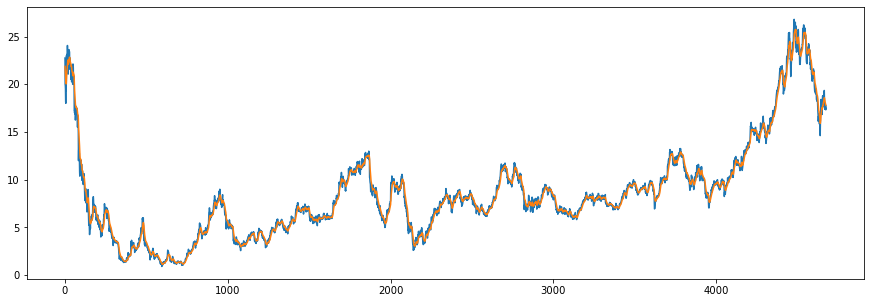

(4661, 64, 64, 1)

In [426]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 6/initial_indicators/ON_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

df2 = pd.read_csv("variation 6/initial_indicators/TSM_data.csv")
df2.set_index('Date', inplace=True)
df['support'] = df2['previous_1d']

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    n = support_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)
    ax.plot(n)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

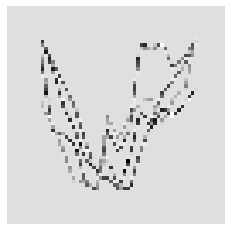

In [427]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [428]:
X = X/255

In [429]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [430]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [431]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [432]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [433]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('ON')]
    y = nr_test_data['{}_y'.format('ON')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('ON'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_non_recession.csv'.format(experiment,'ON')):
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'ON'))
    else:
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'ON'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('ON')]
    y = r_test_data['{}_y'.format('ON')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('ON'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_recession.csv'.format(experiment,'ON')):
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'ON'))
    else:
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'ON'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.864978902953586, 1: 7.766666666666667, 2: 0.36441837732160315}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2427 - accuracy: 0.4590 - mse: 1.5260 - weighted_accuracy: 0.3191 - weighted_mse: 1.6083 - val_loss: 0.1678 - val_accuracy: 0.9143 - val_mse: 0.7943 - val_weighted_accuracy: 0.9143 - val_weighted_mse: 0.7943
Epoch 2/20
30/30 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.5490 - mse: 1.0963 - weighted_accuracy: 0.3151 - weighted_mse: 1.170 - 0s 10ms/step - loss: 0.2114 - accuracy: 0.5373 - mse: 1.0953 - weighted_accuracy: 0.3238 - weighted_mse: 1.1590 - val_loss: 0.1960 - val_accuracy: 0.0932 - val_mse: 0.8192 - val_weighted_accuracy: 0.0932 - val_weighted_mse: 0.8192
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2061 - accuracy: 0.5239 - mse: 1.1094 - weighted_accuracy: 0.3286 - weighted_mse: 1.1559 - val_loss: 0.1814 - val_accuracy: 0.9143 - val_mse: 0.8518 - val



Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1928 - accuracy: 0.6210 - mse: 0.8943 - weighted_accuracy: 0.6210 - weighted_mse: 0.8943
Test loss: 0.19282837212085724
Test accuracy: 0.621004581451416


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 58
actual holds but predicted sell: 9
actual predicted holds: 131
Percentage buys correct: 6.451612903225806%
Percentage sells correct: 10.0%
Percentage holds correct: 89.1156462585034%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 46.774193548387096%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 80.82191780821918%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price increase

30/30 [==============================] - 0s 9ms/step - loss: 0.1941 - accuracy: 0.2969 - mse: 1.2172 - weighted_accuracy: 0.4119 - weighted_mse: 1.2304 - val_loss: 0.1981 - val_accuracy: 0.0911 - val_mse: 0.9687 - val_weighted_accuracy: 0.0911 - val_weighted_mse: 0.9687
Epoch 19/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1930 - accuracy: 0.2779 - mse: 1.2006 - weighted_accuracy: 0.4089 - weighted_mse: 1.1902 - val_loss: 0.1957 - val_accuracy: 0.0986 - val_mse: 0.9778 - val_weighted_accuracy: 0.0986 - val_weighted_mse: 0.9778
Epoch 20/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1905 - accuracy: 0.2758 - mse: 1.1817 - weighted_accuracy: 0.4519 - weighted_mse: 1.1758 - val_loss: 0.1903 - val_accuracy: 0.2540 - val_mse: 0.9853 - val_weighted_accuracy: 0.2540 - val_weighted_mse: 0.9853
Validation loss: 0.19027481973171234
Validation accuracy: 0.25401929020881653


Non-Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1889 - accuracy: 0.2830 - mse: 1.2123 - weighted_accuracy: 0.4629 - weighted_mse: 1.1814 - val_loss: 0.1865 - val_accuracy: 0.2669 - val_mse: 1.0942 - val_weighted_accuracy: 0.2669 - val_weighted_mse: 1.0942
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1925 - accuracy: 0.2731 - mse: 1.2254 - weighted_accuracy: 0.4113 - weighted_mse: 1.2143 - val_loss: 0.1935 - val_accuracy: 0.1233 - val_mse: 0.9998 - val_weighted_accuracy: 0.1233 - val_weighted_mse: 0.9998
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1891 - accuracy: 0.2774 - mse: 1.2060 - weighted_accuracy: 0.4383 - weighted_mse: 1.1918 - val_loss: 0.1901 - val_accuracy: 0.1865 - val_mse: 1.0400 - val_weighted_accuracy: 0.1865 - val_weighted_mse: 1.0400
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1892 - accuracy: 0.3045 - mse: 1.2529 - weighted_accuracy: 0.4567 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1960 - accuracy: 0.1644 - mse: 1.0500 - weighted_accuracy: 0.1644 - weighted_mse: 1.0500
Test loss: 0.19595852494239807
Test accuracy: 0.16438356041908264


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 84
actual holds but predicted sell: 94
actual predicted holds: 20
Percentage buys correct: 9.574468085106384%
Percentage sells correct: 6.796116504854369%
Percentage holds correct: 90.9090909090909%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 48.38709677419355%
Percentage high sells correct: 49.51456310679612%
Percentage mid holds correct: 86.36363636363636%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price 

Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1714 - accuracy: 0.2438 - mse: 1.3515 - weighted_accuracy: 0.5346 - weighted_mse: 1.2985 - val_loss: 0.1844 - val_accuracy: 0.2787 - val_mse: 1.1357 - val_weighted_accuracy: 0.2787 - val_weighted_mse: 1.1357
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1716 - accuracy: 0.2433 - mse: 1.3239 - weighted_accuracy: 0.5123 - weighted_mse: 1.2932 - val_loss: 0.1933 - val_accuracy: 0.1919 - val_mse: 1.1062 - val_weighted_accuracy: 0.1919 - val_weighted_mse: 1.1062
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1722 - accuracy: 0.2428 - mse: 1.2694 - weighted_accuracy: 0.5201 - weighted_mse: 1.2438 - val_loss: 0.1836 - val_accuracy: 0.2937 - val_mse: 1.1848 - val_weighted_accuracy: 0.2937 - val_weighted_mse: 1.1848
Epoch 9/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1733 - accuracy: 0.2344 - mse: 1.3024 - weighted_accuracy: 0.5171 - weighted_m

7/7 [==============================] - 0s 2ms/step - loss: 0.1833 - accuracy: 0.3607 - mse: 1.1704 - weighted_accuracy: 0.3607 - weighted_mse: 1.1704
Test loss: 0.1832846999168396
Test accuracy: 0.3607305884361267


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 60
actual holds but predicted sell: 70
actual predicted holds: 68
Percentage buys correct: 7.575757575757576%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 90.66666666666667%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 48.484848484848484%
Percentage high sells correct: 52.56410256410256%
Percentage mid holds correct: 83.78378378378379%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price

Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1601 - accuracy: 0.2597 - mse: 1.4300 - weighted_accuracy: 0.5780 - weighted_mse: 1.3880 - val_loss: 0.2000 - val_accuracy: 0.1340 - val_mse: 1.2375 - val_weighted_accuracy: 0.1340 - val_weighted_mse: 1.2375
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1545 - accuracy: 0.2422 - mse: 1.3945 - weighted_accuracy: 0.5977 - weighted_mse: 1.3733 - val_loss: 0.1937 - val_accuracy: 0.2015 - val_mse: 1.3381 - val_weighted_accuracy: 0.2015 - val_weighted_mse: 1.3381
Epoch 9/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1548 - accuracy: 0.2631 - mse: 1.4362 - weighted_accuracy: 0.6034 - weighted_mse: 1.4151 - val_loss: 0.1887 - val_accuracy: 0.2605 - val_mse: 1.3699 - val_weighted_accuracy: 0.2605 - val_weighted_mse: 1.3699
Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1511 - accuracy: 0.2639 - mse: 1.4936 - weighted_accuracy: 0.6277 - weighted_m

7/7 [==============================] - 0s 2ms/step - loss: 0.1878 - accuracy: 0.3059 - mse: 1.4275 - weighted_accuracy: 0.3059 - weighted_mse: 1.4275
Test loss: 0.1877574622631073
Test accuracy: 0.3059360682964325


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 3
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 60
actual holds but predicted sell: 84
actual predicted holds: 54
Percentage buys correct: 7.575757575757576%
Percentage sells correct: 8.421052631578947%
Percentage holds correct: 93.10344827586206%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 51.515151515151516%
Percentage high sells correct: 53.68421052631579%
Percentage mid holds correct: 89.47368421052632%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price 

30/30 [==============================] - 0s 9ms/step - loss: 0.1424 - accuracy: 0.3130 - mse: 1.5971 - weighted_accuracy: 0.6496 - weighted_mse: 1.6514 - val_loss: 0.1860 - val_accuracy: 0.3301 - val_mse: 1.3903 - val_weighted_accuracy: 0.3301 - val_weighted_mse: 1.3903
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1412 - accuracy: 0.3549 - mse: 1.6222 - weighted_accuracy: 0.6787 - weighted_mse: 1.6474 - val_loss: 0.1693 - val_accuracy: 0.4544 - val_mse: 1.4537 - val_weighted_accuracy: 0.4544 - val_weighted_mse: 1.4537
Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1378 - accuracy: 0.3796 - mse: 1.7050 - weighted_accuracy: 0.6617 - weighted_mse: 1.7971 - val_loss: 0.1634 - val_accuracy: 0.5263 - val_mse: 1.4632 - val_weighted_accuracy: 0.5263 - val_weighted_mse: 1.4632
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1386 - accuracy: 0.3511 - mse: 1.6310 - weighted_accuracy: 0.6792 - weighted_mse: 1.6594 

7/7 [==============================] - 0s 2ms/step - loss: 0.1747 - accuracy: 0.4658 - mse: 1.5803 - weighted_accuracy: 0.4658 - weighted_mse: 1.5803
Test loss: 0.17474159598350525
Test accuracy: 0.465753436088562


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 3
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 46
actual holds but predicted sell: 60
actual predicted holds: 92
Percentage buys correct: 9.615384615384615%
Percentage sells correct: 7.352941176470588%
Percentage holds correct: 92.92929292929293%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 57.69230769230769%
Percentage high sells correct: 57.35294117647059%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price i

Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1302 - accuracy: 0.4281 - mse: 1.7752 - weighted_accuracy: 0.7053 - weighted_mse: 1.9223 - val_loss: 0.1680 - val_accuracy: 0.5188 - val_mse: 1.5052 - val_weighted_accuracy: 0.5188 - val_weighted_mse: 1.5052
Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1253 - accuracy: 0.4496 - mse: 1.8333 - weighted_accuracy: 0.7112 - weighted_mse: 2.0124 - val_loss: 0.1673 - val_accuracy: 0.5155 - val_mse: 1.5524 - val_weighted_accuracy: 0.5155 - val_weighted_mse: 1.5524
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1272 - accuracy: 0.4447 - mse: 1.8938 - weighted_accuracy: 0.7073 - weighted_mse: 2.0290 - val_loss: 0.1647 - val_accuracy: 0.5413 - val_mse: 1.5073 - val_weighted_accuracy: 0.5413 - val_weighted_mse: 1.5073
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1343 - accuracy: 0.4697 - mse: 1.7301 - weighted_accuracy: 0.6984 - weighted_m

7/7 [==============================] - 0s 2ms/step - loss: 0.1627 - accuracy: 0.5845 - mse: 1.6103 - weighted_accuracy: 0.5845 - weighted_mse: 1.6103
Test loss: 0.16265124082565308
Test accuracy: 0.5844748616218567


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 40
actual holds but predicted sell: 37
actual predicted holds: 121
Percentage buys correct: 8.88888888888889%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 91.66666666666667%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 60.0%
Percentage high sells correct: 52.38095238095238%
Percentage mid holds correct: 82.44274809160305%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price increase from

Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1168 - accuracy: 0.5531 - mse: 1.9709 - weighted_accuracy: 0.7427 - weighted_mse: 2.3136 - val_loss: 0.1525 - val_accuracy: 0.6206 - val_mse: 1.6311 - val_weighted_accuracy: 0.6206 - val_weighted_mse: 1.6311
Epoch 8/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1144 - accuracy: 0.5724 - mse: 2.0166 - weighted_accuracy: 0.7458 - weighted_mse: 2.3491 - val_loss: 0.1664 - val_accuracy: 0.5413 - val_mse: 1.7196 - val_weighted_accuracy: 0.5413 - val_weighted_mse: 1.7196
Epoch 9/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1107 - accuracy: 0.5518 - mse: 2.0731 - weighted_accuracy: 0.7604 - weighted_mse: 2.4526 - val_loss: 0.1547 - val_accuracy: 0.6141 - val_mse: 1.7353 - val_weighted_accuracy: 0.6141 - val_weighted_mse: 1.7353
Epoch 10/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1106 - accuracy: 0.5711 - mse: 2.0756 - weighted_accuracy: 0.7674 - weighte

Price increase from previously bought: 11.397252671822011%
Share price: $0.4782505761696361
Shares owned at the moment: 0
Cash capital at the moment: $176.63613325413138


Share price: $0.48645786005787545
Shares owned at the moment: 362
Cash capital at the moment: $0.05411911349284537


Price increase from previously bought: -4.082096085901988%
Share price: $0.4678833332955708
Shares owned at the moment: 0
Cash capital at the moment: $168.96210790819373


Share price: $0.5076241563432623
Shares owned at the moment: 331
Cash capital at the moment: $0.47644727026244027


Price increase from previously bought: 6.429871981146396%
Share price: $0.5417494650257977
Shares owned at the moment: 0
Cash capital at the moment: $179.30239274326175


Share price: $0.5452051851868633
Shares owned at the moment: 327
Cash capital at the moment: $0.530021424378134


Price increase from previously bought: 11.893686535385694%
Share price: $0.611727818885099
Shares owned at the moment: 0
Cash capital at t

Validation loss: 0.12957923114299774
Validation accuracy: 0.74490886926651


Non-Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1351 - accuracy: 0.7156 - mse: 1.9634 - weighted_accuracy: 0.7156 - weighted_mse: 1.9634
Test loss: 0.13512995839118958
Test accuracy: 0.7155963182449341


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 17
actual holds but predicted sell: 28
actual predicted holds: 153
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 3.4482758620689653%
Percentage holds correct: 90.0%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 57.89473684210526%
Percentage high sells correct: 34.48275862068966%
Percentage mid holds correct: 83.4319526627219%


Capital: 100
Share price: $0.6556241669031462
S

Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0975 - accuracy: 0.6679 - mse: 2.5602 - weighted_accuracy: 0.7806 - weighted_mse: 3.3772 - val_loss: 0.1257 - val_accuracy: 0.7706 - val_mse: 1.9135 - val_weighted_accuracy: 0.7706 - val_weighted_mse: 1.9135
Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0912 - accuracy: 0.6719 - mse: 2.5294 - weighted_accuracy: 0.8062 - weighted_mse: 3.3744 - val_loss: 0.1272 - val_accuracy: 0.7449 - val_mse: 1.9784 - val_weighted_accuracy: 0.7449 - val_weighted_mse: 1.9784
Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0929 - accuracy: 0.6878 - mse: 2.6442 - weighted_accuracy: 0.8059 - weighted_mse: 3.4088 - val_loss: 0.1208 - val_accuracy: 0.7889 - val_mse: 1.9625 - val_weighted_accuracy: 0.7889 - val_weighted_mse: 1.9625
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0970 - accuracy: 0.6856 - mse: 2.6275 - weighted_accuracy: 0.7990 - weighted

In [434]:
df = nr_log_hist['epochs_logs']
df.head(20)

Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.596330      7.246377       0.000000      89.928058   
1       0.266055      8.219178       6.382979      90.196078   
2       0.146789      5.607477       6.896552      83.333333   
3       0.408257      8.333333       8.196721      91.764706   
4       0.348624      8.064516       6.024096      90.410959   
5       0.463303      6.666667       6.060606      87.850467   
6       0.596330      8.333333       4.761905      89.285714   
7       0.688073     10.526316       5.405405      90.123457   
8       0.715596     10.526316       3.448276      90.000000   
9       0.752294      0.000000       4.761905      89.560440   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         44.927536           60.000000          84.057971      35.327004   
1         45.205479           39.784946          88.235294     -75.271685   
2         44.859813           44.186047          70.833333     -77.195040   
3         51.388889           50.000000          84.705882     -70.690621   
4         53.225806           43.902439          83.561644     -65.743309   
5         53.333333           45.454545          80.188679     -84.661993   
6         58.333333           45.238095          82.733813      22.739117   
7         63.157895           43.243243          83.850932      56.049560   
8         57.894737           34.482759          83.431953     103.948919   
9         53.333333           38.095238          82.320442     208.770046   

   buy_n_hold profit  
0          27.578476  
1          27.578476  
2          27.578476  
3          27.578476  
4          27.578476  
5          27.578476  
6          27.578476  
7          27.578476  
8          27.578476  
9          27.578476

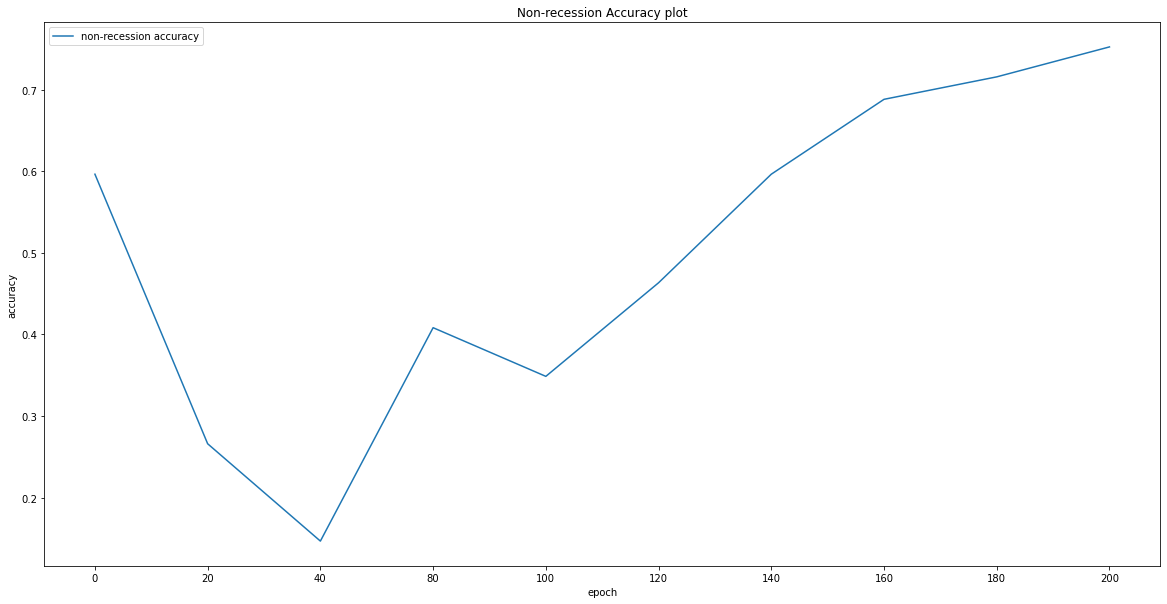

In [435]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

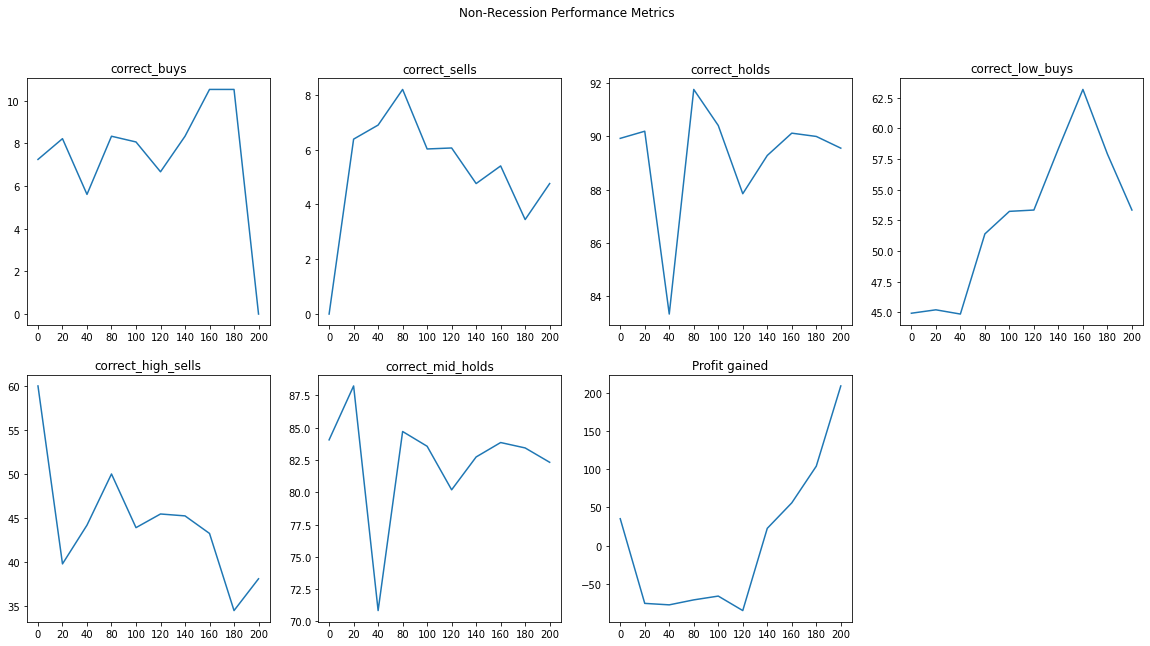

In [436]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

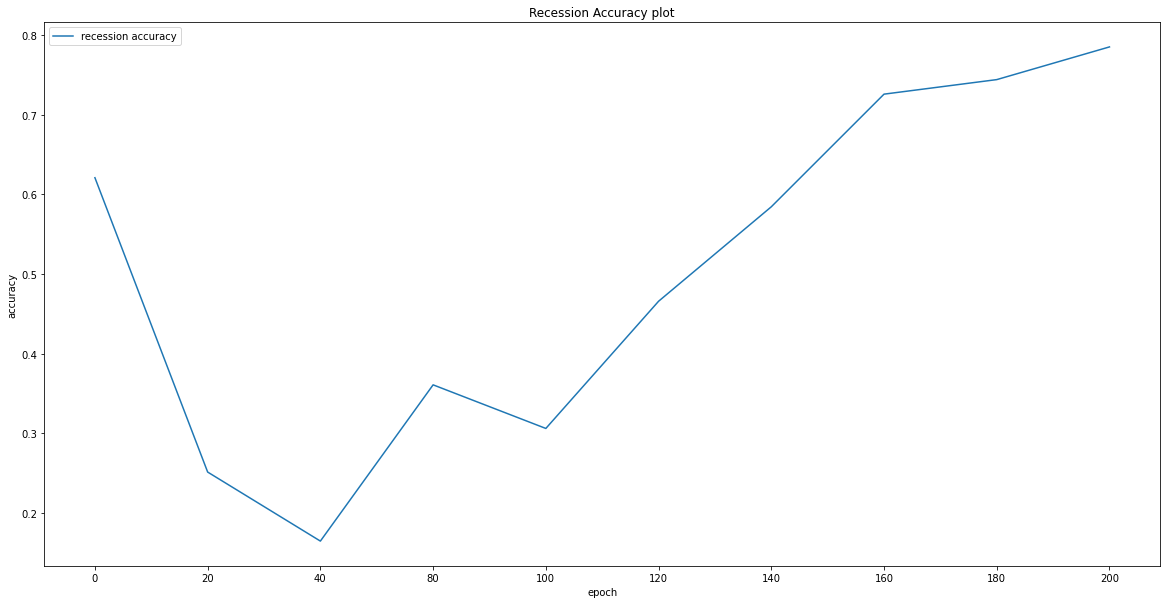

In [437]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()


Text(0.5, 1.0, 'Profit gained')

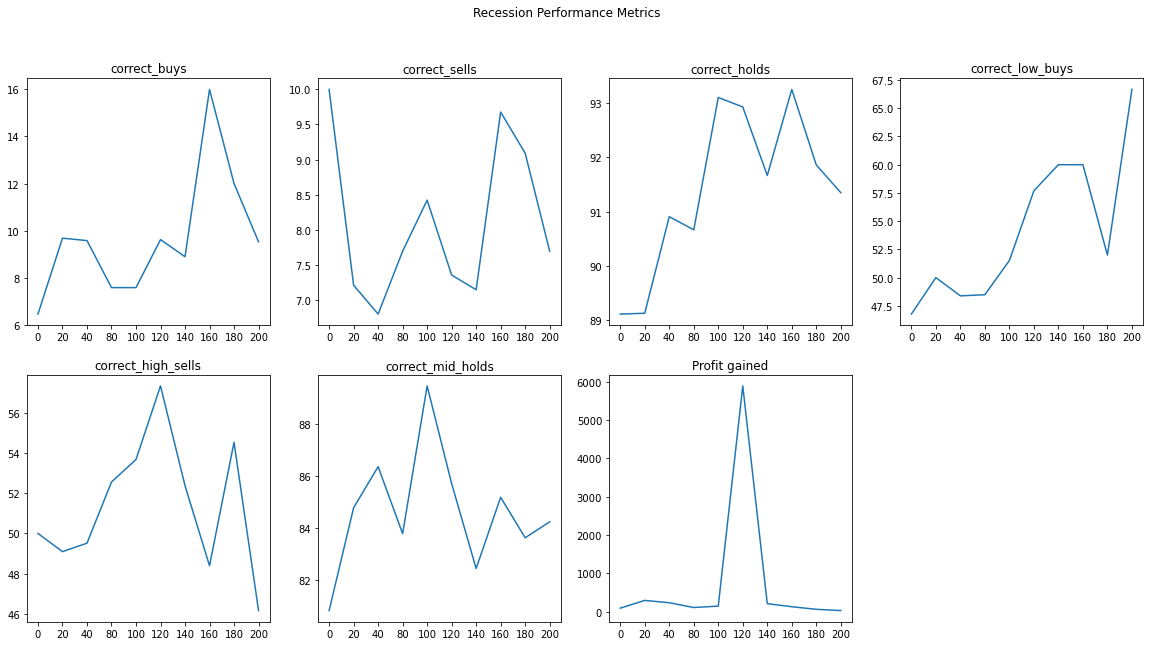

In [438]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")